In [1]:
import random, gc, os, pickle, csv, time

import datasets.utils
import models.utils
from models.cls_oml_ori_v2 import OML
from models.base_models_ori import LabelAwareReplayMemory

import numpy as np
import matplotlib.pyplot as plt

import higher
import torch
import torch.nn.functional as F
from torch.utils import data

# Constants

In [2]:
dataset_order_mapping = {
    1: [2, 0, 3, 1, 4],
    2: [3, 4, 0, 1, 2],
    3: [2, 4, 1, 3, 0],
    4: [0, 2, 1, 4, 3]
}
n_classes = 33
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
# model_path = "/data/model_runs/original_oml/aOML-order1-2022-07-18/OML-order1-id4-2022-07-18_17-53-13.518612.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr002-2022-07-31/OML-order1-id4-2022-07-31_14-53-46.456804.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr005-2022-07-31/OML-order1-id4-2022-07-31_18-47-41.477968.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr005-up20-2022-08-01/OML-order1-id4-2022-08-01_14-45-55.869765.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-07-31/OML-order1-id4-2022-07-31_21-18-36.241546.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr020-2022-08-16/OML-order1-id4-2022-08-16_11-37-19.424113.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr050-2022-08-16/OML-order1-id4-2022-08-16_14-16-12.167637.pt"

# v. SR 
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-08-29-sr/OML-order1-id4-2022-08-29_18-10-31.695669.pt"
# v. SR Query
model_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-08-30-sr-query/OML-order1-id4-2022-08-30_05-21-18.854228.pt"

# memory_path = "/data/model_runs/original_oml/aOML-order1-2022-07-18/OML-order1-id4-2022-07-18_17-53-13.518639_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr002-2022-07-31/OML-order1-id4-2022-07-31_14-53-46.456828_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr005-2022-07-31/OML-order1-id4-2022-07-31_18-47-41.477992_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr005-up20-2022-08-01/OML-order1-id4-2022-08-01_14-45-55.869797_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-07-31/OML-order1-id4-2022-07-31_21-18-36.241572_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr020-2022-08-16/OML-order1-id4-2022-08-16_11-37-19.424139_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr050-2022-08-16/OML-order1-id4-2022-08-16_14-16-12.167666_memory.pickle"
# v. SR 
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-08-29-sr/OML-order1-id4-2022-08-29_18-10-31.695692_memory.pickle"
# v. SR Query
memory_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-08-30-sr-query/OML-order1-id4-2022-08-30_05-21-18.854254_memory.pickle"
# Already TA
memory_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-08-30-sr-query/OML-order1-id4-2022-08-30_05-21-18.854228_memory_newkey.pickle"

# For Sample Score
TRIM_ER = 500
TOTAL_EPOCH = 600
# new_memory_path, ext = os.path.splitext(memory_path)
# new_memory_path = new_memory_path + "_label" + ext

use_db_cache = True
cache_dir = 'tmp'

In [3]:
args = {
    "order": 1,
    "n_epochs": 1,
    "lr": 3e-5,
    "inner_lr": 0.001*10,
    "meta_lr": 3e-5,
    "model": "bert",
    "learner": "oml",
    "mini_batch_size": 16,
    "updates": 5*1,
    "write_prob": 1.0,
    "max_length": 448,
    "seed": 42,
    "replay_rate": 0.01,
    "replay_every": 9600
}
updates = args["updates"]
mini_batch_size = args["mini_batch_size"]
order = args["order"]

In [4]:
torch.manual_seed(args["seed"])
random.seed(args["seed"])
np.random.seed(args["seed"])

# Load Dataset

In [5]:
print('Loading the datasets')
test_datasets = []
for dataset_id in dataset_order_mapping[order]:
    test_dataset_file = os.path.join(cache_dir, f"{dataset_id}.cache")
    if os.path.exists(test_dataset_file):
        with open(test_dataset_file, 'rb') as f:
            test_dataset = pickle.load(f)
    else:
        test_dataset = datasets.utils.get_dataset_test("", dataset_id)
        print('Loaded {}'.format(test_dataset.__class__.__name__))
        test_dataset = datasets.utils.offset_labels(test_dataset)
        pickle.dump(test_dataset, open( test_dataset_file, "wb" ), protocol=pickle.HIGHEST_PROTOCOL)
        print(f"Pickle saved at {test_dataset_file}")
    test_datasets.append(test_dataset)
print('Finished loading all the datasets')

Loading the datasets
Finished loading all the datasets


# Load Model

In [6]:
learner = OML(device=device, n_classes=n_classes, **args)
print('Using {} as learner'.format(learner.__class__.__name__))
learner.load_model(model_path)
with open(memory_path, 'rb') as f:
#     learner.memory = pickle.load(f)
    memory_buffer = pickle.load(f)


2022-12-01 18:02:55,262 - transformers.tokenization_utils_base - INFO - loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
2022-12-01 18:02:56,526 - transformers.configuration_utils - INFO - loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
2022-12-01 18:02:56,529 - transformers.configuration_utils - INFO - Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer

Using OML as learner


In [7]:
dataclass_mapper = {
    "AGNewsDataset": 0,
    "AmazonDataset": 1,
    "YelpDataset": 2,
    "DBPediaDataset": 3,
    "YahooAnswersDataset": 4
}
dataclass_mapper["AGNewsDataset"]

0

In [8]:
# Trim buffer dict to 1000 per class
memory_buffer.meta_length = 4
memory_buffer.reset_meta()
memory_buffer.trim_buffer_dict(limit_n=TRIM_ER)

In [9]:
len(memory_buffer.buffer_dict[list(memory_buffer.buffer_dict.keys())[0]])

500

# Get Scores for each sample in ER

In [14]:
# Returns preds,labels, labels_conf
def validate(fpln, validation_set):
    all_valid_preds, all_valid_labels, all_valid_label_conf = [], [], []
    
    for valid_text, valid_labels, _ in validation_set:        
        valid_labels = torch.tensor(valid_labels).to(device)
        valid_input_dict = learner.rln.encode_text(valid_text)
        valid_repr = learner.rln(valid_input_dict)
        valid_output = fpln(valid_repr) # Output has size of torch.Size([16, 33]) [BATCH, CLASSES]
        valid_loss = learner.loss_fn(valid_output, valid_labels)
        valid_loss = valid_loss.item()

        # output.detach().max(-1) max on each Batch, which will return [0] max, [1] indices
        valid_output_softmax = F.softmax(valid_output, -1)
        valid_label_conf = valid_output_softmax[np.arange(len(valid_output_softmax)), valid_labels] # Select labels in the softmax of 33 classes

        valid_pred = models.utils.make_prediction(valid_output.detach())
        
        
        # Put in things to return
        # all_valid_losses.extend(valid_loss)
        all_valid_preds.extend(valid_pred.tolist())
        all_valid_labels.extend(valid_labels.tolist())
        all_valid_label_conf.extend(valid_label_conf.tolist())
    return all_valid_preds, all_valid_labels, all_valid_label_conf # removed loss, since no need

# Compare diff results between the unadapted vs adapted
# Returns Dictionary of class_idx -> [ a - n, ...  ] for each i (300). Can np.sum() or np.mean() later
# validate_labels = The labels (Shared)
# validate_label_conf_0 = The label conf of validate_0
# validate_label_conf_n = The label conf of validate_n
def calculate_diff_class(validate_labels, validate_label_conf_0, validate_label_conf_n, initial_dict={}, return_dict=True): 
    # Adapted confs - NonAdapted Confs (a-n)
    validate_label_conf_diff = np.array(validate_label_conf_n) - np.array(validate_label_conf_0)
    
    if return_dict:
        # The dictionary to return  class_idx -> [ a - n, ...  ] 
        return_dict = initial_dict.copy()
        for i, class_idx in enumerate(validate_labels):
            # Filter conf_diff by class
            return_dict[class_idx] = return_dict.get(class_idx, []) + [validate_label_conf_diff[i]]
        return return_dict
    
    return validate_label_conf_diff

Every Task, we do `1 = 1` batch , there are 5 tasks so `1*5 = 5` per epoch (takes around 0.05s per task ~0.25s). So we need to do it `600*16` times so that it will be ~160 minutes (9600s) and it means `5*9600 = 48,000`, and hopefully support will be around  `9600/500 ~ 19.2` per sample.

```
Adapt Time: 0.057111501693725586 s
Support set metrics: Loss = 0.0102, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
```

```
For 9600 Epoch
Total Scoring Time: 160.0 m
```

In [15]:
TIC_score = time.time()
for epoch in range(TOTAL_EPOCH*16):
    print(f"This is epoch {epoch}/{TOTAL_EPOCH*16}")
    learner.rln.eval()
    learner.pln.train()
    
    for task_idx in memory_buffer.task_dict.keys():
        support_set = []
        #for _ in range(updates):
        for _ in range(1): # CHANGE THIS to 1 minibatch.
            text, labels, indexes = memory_buffer.read_batch_task(batch_size=1, task_idx=task_idx, \
                                                                  with_index=True, random_class=True)
            support_set.append((text, labels, indexes))
        #print(support_set)
        with higher.innerloop_ctx(learner.pln, learner.inner_optimizer,
                                  copy_initial_weights=False, track_higher_grads=False) as (fpln, diffopt):
            
            # Test validation_set BEFORE the update (update=0)
            with torch.no_grad():
                all_valid_preds_0, all_valid_labels_0, all_valid_label_conf_0  = validate(fpln, support_set)
            
            INNER_tic = time.time()
            # Inner loop
            task_predictions, task_labels, task_indexes = [], [], []
            support_loss = []
            for text, labels, indexes in support_set:
                labels = torch.tensor(labels).to(device)
                input_dict = learner.rln.encode_text(text)
                _repr = learner.rln(input_dict)
                output = fpln(_repr)
                loss = learner.loss_fn(output, labels)
                diffopt.step(loss)
                pred = models.utils.make_prediction(output.detach())
                support_loss.append(loss.item())
                task_predictions.extend(pred.tolist())
                task_labels.extend(labels.tolist())
                task_indexes.extend(indexes)
            INNER_toc = time.time() - INNER_tic
            print("Adapt Time: "+ str(INNER_toc) +" s" )
            
            # Test validation_set AFTER ALL the update
            with torch.no_grad():
                all_valid_preds_n, all_valid_labels_n, all_valid_label_conf_n = validate(fpln, support_set)
                diff_list = calculate_diff_class(all_valid_labels_0, all_valid_label_conf_0, all_valid_label_conf_n, return_dict=False)
                memory_buffer.update_meta(all_valid_labels_0, task_indexes, \
                                          np.array(all_valid_label_conf_0), np.array(all_valid_label_conf_n), diff_list, \
                                          task_id=task_idx)

            acc, prec, rec, f1 = models.utils.calculate_metrics(task_predictions, task_labels)

            print('Support set metrics: Loss = {:.4f}, accuracy = {:.4f}, precision = {:.4f}, '
                        'recall = {:.4f}, F1 score = {:.4f}'.format(np.mean(support_loss), acc, prec, rec, f1))

TOC_score = time.time() - TIC_score 
print("Total Scoring Time: "+ str(TOC_score//60) +" m" )

This is epoch 0/9600
Adapt Time: 0.02333211898803711 s
Support set metrics: Loss = 0.0490, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02767038345336914 s
Support set metrics: Loss = 1.2628, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.026496410369873047 s
Support set metrics: Loss = 0.0354, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02097463607788086 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.030874013900756836 s
Support set metrics: Loss = 0.3974, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1/9600
Adapt Time: 0.023264646530151367 s
Support set metrics: Loss = 0.0302, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021784305572509766 s
Support set metrics: Loss = 0.7542, accuracy = 1.0000, p

Adapt Time: 0.021292448043823242 s
Support set metrics: Loss = 0.0456, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018627643585205078 s
Support set metrics: Loss = 0.0098, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022597789764404297 s
Support set metrics: Loss = 0.2128, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 12/9600
Adapt Time: 0.02148127555847168 s
Support set metrics: Loss = 2.8021, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021239757537841797 s
Support set metrics: Loss = 1.0513, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019993066787719727 s
Support set metrics: Loss = 2.2682, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021625518798828125 s
Support set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.016714811325073242 s
Support set metrics: Loss = 0.1615, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015934467315673828 s
Support set metrics: Loss = 0.0893, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 23/9600
Adapt Time: 0.01554417610168457 s
Support set metrics: Loss = 0.0760, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016011953353881836 s
Support set metrics: Loss = 1.7965, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016056537628173828 s
Support set metrics: Loss = 1.1420, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01565408706665039 s
Support set metrics: Loss = 0.0035, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017703771591186523 s
Support set metrics: Loss = 0.1923, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.020682573318481445 s
Support set metrics: Loss = 0.5112, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017647504806518555 s
Support set metrics: Loss = 1.6483, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017119884490966797 s
Support set metrics: Loss = 0.0112, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016254901885986328 s
Support set metrics: Loss = 0.0266, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 35/9600
Adapt Time: 0.018422603607177734 s
Support set metrics: Loss = 0.7004, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019153118133544922 s
Support set metrics: Loss = 0.0873, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017962217330932617 s
Support set metrics: Loss = 1.1047, accuracy = 0.0000, precision = 0.0000

Adapt Time: 0.029529571533203125 s
Support set metrics: Loss = 0.4897, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016579151153564453 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015074968338012695 s
Support set metrics: Loss = 0.0298, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 46/9600
Adapt Time: 0.016681671142578125 s
Support set metrics: Loss = 0.0307, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017928361892700195 s
Support set metrics: Loss = 0.4014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02172708511352539 s
Support set metrics: Loss = 0.6578, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016159772872924805 s
Support set metrics: Loss = 0.0076, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.01606464385986328 s
Support set metrics: Loss = 0.0256, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016688823699951172 s
Support set metrics: Loss = 0.5793, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0217742919921875 s
Support set metrics: Loss = 2.0143, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017261266708374023 s
Support set metrics: Loss = 0.0227, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01678466796875 s
Support set metrics: Loss = 4.2807, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 58/9600
Adapt Time: 0.015756845474243164 s
Support set metrics: Loss = 0.0173, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017576932907104492 s
Support set metrics: Loss = 1.5794, accuracy = 0.0000, precision = 0.0000, recal

Adapt Time: 0.01972222328186035 s
Support set metrics: Loss = 1.7581, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01832890510559082 s
Support set metrics: Loss = 3.1651, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01876354217529297 s
Support set metrics: Loss = 0.0056, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02033090591430664 s
Support set metrics: Loss = 0.1135, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 69/9600
Adapt Time: 0.01923680305480957 s
Support set metrics: Loss = 0.0450, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022090911865234375 s
Support set metrics: Loss = 1.1476, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.023651599884033203 s
Support set metrics: Loss = 1.7926, accuracy = 0.0000, precision = 0.0000, rec

Adapt Time: 0.01567673683166504 s
Support set metrics: Loss = 0.0146, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018789052963256836 s
Support set metrics: Loss = 0.1106, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016659259796142578 s
Support set metrics: Loss = 0.0342, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01687312126159668 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01762247085571289 s
Support set metrics: Loss = 0.7558, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 81/9600
Adapt Time: 0.01520395278930664 s
Support set metrics: Loss = 4.3084, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017910480499267578 s
Support set metrics: Loss = 0.7926, accuracy = 1.0000, precision = 1.0000, re

Adapt Time: 0.026710987091064453 s
Support set metrics: Loss = 0.4878, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018419981002807617 s
Support set metrics: Loss = 0.0059, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0209808349609375 s
Support set metrics: Loss = 0.0881, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 92/9600
Adapt Time: 0.018521547317504883 s
Support set metrics: Loss = 0.0184, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019533872604370117 s
Support set metrics: Loss = 0.0427, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017607927322387695 s
Support set metrics: Loss = 0.8562, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02031254768371582 s
Support set metrics: Loss = 0.0049, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.0195767879486084 s
Support set metrics: Loss = 0.8331, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017966747283935547 s
Support set metrics: Loss = 0.0057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020893335342407227 s
Support set metrics: Loss = 0.1223, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 103/9600
Adapt Time: 0.017645835876464844 s
Support set metrics: Loss = 2.1701, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01990795135498047 s
Support set metrics: Loss = 0.0427, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024109363555908203 s
Support set metrics: Loss = 0.4745, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019100189208984375 s
Support set metrics: Loss = 0.0044, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.01969742774963379 s
Support set metrics: Loss = 2.4153, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020734786987304688 s
Support set metrics: Loss = 1.0136, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018822669982910156 s
Support set metrics: Loss = 0.1262, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 114/9600
Adapt Time: 0.019233226776123047 s
Support set metrics: Loss = 0.0171, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02077031135559082 s
Support set metrics: Loss = 0.8404, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02242445945739746 s
Support set metrics: Loss = 0.7594, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01825857162475586 s
Support set metrics: Loss = 0.0031, accuracy = 1.0000, precision = 1.0000, r

Support set metrics: Loss = 0.0105, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014842987060546875 s
Support set metrics: Loss = 1.1760, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015341758728027344 s
Support set metrics: Loss = 0.4419, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01607370376586914 s
Support set metrics: Loss = 0.0024, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01676344871520996 s
Support set metrics: Loss = 0.0236, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 126/9600
Adapt Time: 0.01633286476135254 s
Support set metrics: Loss = 0.0227, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017302274703979492 s
Support set metrics: Loss = 0.8498, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000


Adapt Time: 0.017212390899658203 s
Support set metrics: Loss = 0.0066, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01934218406677246 s
Support set metrics: Loss = 0.2273, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 137/9600
Adapt Time: 0.015324831008911133 s
Support set metrics: Loss = 0.0121, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01812005043029785 s
Support set metrics: Loss = 0.6109, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01615619659423828 s
Support set metrics: Loss = 0.5258, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016390562057495117 s
Support set metrics: Loss = 0.0056, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01931929588317871 s
Support set metrics: Loss = 0.0700, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.017969846725463867 s
Support set metrics: Loss = 0.0580, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016788005828857422 s
Support set metrics: Loss = 0.9097, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01677703857421875 s
Support set metrics: Loss = 0.0082, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017261743545532227 s
Support set metrics: Loss = 3.2113, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 149/9600
Adapt Time: 0.015679121017456055 s
Support set metrics: Loss = 0.0776, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017978906631469727 s
Support set metrics: Loss = 0.3659, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02315664291381836 s
Support set metrics: Loss = 1.6698, accuracy = 0.0000, precision = 0.0000,

Support set metrics: Loss = 1.0592, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017395496368408203 s
Support set metrics: Loss = 0.0071, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017580509185791016 s
Support set metrics: Loss = 0.7386, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 160/9600
Adapt Time: 0.015559673309326172 s
Support set metrics: Loss = 0.0107, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016771316528320312 s
Support set metrics: Loss = 0.1961, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0181887149810791 s
Support set metrics: Loss = 0.0350, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017805814743041992 s
Support set metrics: Loss = 0.0037, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000

Adapt Time: 0.01752495765686035 s
Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01691603660583496 s
Support set metrics: Loss = 0.1288, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 171/9600
Adapt Time: 0.016026735305786133 s
Support set metrics: Loss = 0.0290, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017731666564941406 s
Support set metrics: Loss = 0.1787, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020210981369018555 s
Support set metrics: Loss = 1.1092, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016961097717285156 s
Support set metrics: Loss = 0.0032, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016666412353515625 s
Support set metrics: Loss = 6.4240, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.01684117317199707 s
Support set metrics: Loss = 0.0208, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016232967376708984 s
Support set metrics: Loss = 0.2047, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015488147735595703 s
Support set metrics: Loss = 0.0936, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017459869384765625 s
Support set metrics: Loss = 0.0099, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015160799026489258 s
Support set metrics: Loss = 3.0382, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 183/9600
Adapt Time: 0.016142845153808594 s
Support set metrics: Loss = 0.0234, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016846895217895508 s
Support set metrics: Loss = 0.0409, accuracy = 1.0000, precision = 1.0000

Support set metrics: Loss = 0.0598, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015529870986938477 s
Support set metrics: Loss = 0.0594, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01891636848449707 s
Support set metrics: Loss = 0.2568, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 194/9600
Adapt Time: 0.0170135498046875 s
Support set metrics: Loss = 0.0214, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019665241241455078 s
Support set metrics: Loss = 0.2973, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02050638198852539 s
Support set metrics: Loss = 0.5371, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015994548797607422 s
Support set metrics: Loss = 0.0985, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
A

Adapt Time: 0.018525123596191406 s
Support set metrics: Loss = 0.1714, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01771092414855957 s
Support set metrics: Loss = 0.4268, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015524864196777344 s
Support set metrics: Loss = 0.1251, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014925479888916016 s
Support set metrics: Loss = 0.0028, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015510320663452148 s
Support set metrics: Loss = 0.8583, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 206/9600
Adapt Time: 0.016213417053222656 s
Support set metrics: Loss = 0.0099, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01777172088623047 s
Support set metrics: Loss = 1.7157, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.018536090850830078 s
Support set metrics: Loss = 3.7453, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019421815872192383 s
Support set metrics: Loss = 0.0659, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017940521240234375 s
Support set metrics: Loss = 0.0061, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017524003982543945 s
Support set metrics: Loss = 5.6353, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 217/9600
Adapt Time: 0.019633054733276367 s
Support set metrics: Loss = 0.3263, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020296096801757812 s
Support set metrics: Loss = 0.0611, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017682313919067383 s
Support set metrics: Loss = 0.7756, accuracy = 0.0000, precision = 0.000

Adapt Time: 0.021098852157592773 s
Support set metrics: Loss = 0.3797, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018370866775512695 s
Support set metrics: Loss = 0.0205, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015655994415283203 s
Support set metrics: Loss = 0.0032, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016564607620239258 s
Support set metrics: Loss = 0.0673, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 228/9600
Adapt Time: 0.01806783676147461 s
Support set metrics: Loss = 0.0194, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017531156539916992 s
Support set metrics: Loss = 2.2246, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01696181297302246 s
Support set metrics: Loss = 1.4593, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.024104833602905273 s
Support set metrics: Loss = 2.3773, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017071247100830078 s
Support set metrics: Loss = 0.0067, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016082048416137695 s
Support set metrics: Loss = 0.1391, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 239/9600
Adapt Time: 0.015400409698486328 s
Support set metrics: Loss = 0.0443, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014759302139282227 s
Support set metrics: Loss = 0.9303, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.014604330062866211 s
Support set metrics: Loss = 0.4044, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016279935836791992 s
Support set metrics: Loss = 0.0044, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.02826523780822754 s
Support set metrics: Loss = 0.4812, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018626928329467773 s
Support set metrics: Loss = 0.0024, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017487764358520508 s
Support set metrics: Loss = 0.0260, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 250/9600
Adapt Time: 0.018030405044555664 s
Support set metrics: Loss = 0.0154, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.028482675552368164 s
Support set metrics: Loss = 1.0678, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020171165466308594 s
Support set metrics: Loss = 1.2286, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020242691040039062 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.01871180534362793 s
Support set metrics: Loss = 0.0041, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014821290969848633 s
Support set metrics: Loss = 4.3170, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 261/9600
Adapt Time: 0.015299081802368164 s
Support set metrics: Loss = 0.9590, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018376588821411133 s
Support set metrics: Loss = 1.6354, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017039060592651367 s
Support set metrics: Loss = 1.0696, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020211219787597656 s
Support set metrics: Loss = 0.0072, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01829814910888672 s
Support set metrics: Loss = 1.1491, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.01731419563293457 s
Support set metrics: Loss = 0.6664, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 272/9600
Adapt Time: 0.01724696159362793 s
Support set metrics: Loss = 0.0156, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02014017105102539 s
Support set metrics: Loss = 0.9705, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020589828491210938 s
Support set metrics: Loss = 1.6911, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017628908157348633 s
Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01949930191040039 s
Support set metrics: Loss = 0.0693, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 273/9600
Adapt Time: 0.01778268814086914 s
Support set metrics: Loss = 0.0530, accuracy = 1.0000,

Adapt Time: 0.018470287322998047 s
Support set metrics: Loss = 0.0120, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015932798385620117 s
Support set metrics: Loss = 0.4282, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017288923263549805 s
Support set metrics: Loss = 0.7272, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015980243682861328 s
Support set metrics: Loss = 0.0059, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021207332611083984 s
Support set metrics: Loss = 0.7707, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 284/9600
Adapt Time: 0.015802383422851562 s
Support set metrics: Loss = 0.0096, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017749547958374023 s
Support set metrics: Loss = 0.7156, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.021146774291992188 s
Support set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01923537254333496 s
Support set metrics: Loss = 1.3676, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 296/9600
Adapt Time: 0.018535137176513672 s
Support set metrics: Loss = 0.0098, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018365859985351562 s
Support set metrics: Loss = 1.2365, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019394397735595703 s
Support set metrics: Loss = 0.9567, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017706632614135742 s
Support set metrics: Loss = 0.0084, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023204803466796875 s
Support set metrics: Loss = 0.0765, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.02110123634338379 s
Support set metrics: Loss = 0.0081, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023752689361572266 s
Support set metrics: Loss = 0.2156, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 307/9600
Adapt Time: 0.018448829650878906 s
Support set metrics: Loss = 0.0272, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020180225372314453 s
Support set metrics: Loss = 0.7241, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019323348999023438 s
Support set metrics: Loss = 0.6051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01874518394470215 s
Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02474069595336914 s
Support set metrics: Loss = 0.0800, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.018018245697021484 s
Support set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02046370506286621 s
Support set metrics: Loss = 0.0525, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 318/9600
Adapt Time: 0.0225830078125 s
Support set metrics: Loss = 0.0175, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02165055274963379 s
Support set metrics: Loss = 1.1044, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02235245704650879 s
Support set metrics: Loss = 1.8441, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.023321866989135742 s
Support set metrics: Loss = 0.0048, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022466421127319336 s
Support set metrics: Loss = 1.1389, accuracy = 1.0000, precision = 1.0000, recal

Adapt Time: 0.023036479949951172 s
Support set metrics: Loss = 0.0070, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0218198299407959 s
Support set metrics: Loss = 0.0616, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 329/9600
Adapt Time: 0.0234377384185791 s
Support set metrics: Loss = 0.0209, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022992849349975586 s
Support set metrics: Loss = 0.1106, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023073911666870117 s
Support set metrics: Loss = 0.0222, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02342367172241211 s
Support set metrics: Loss = 0.0042, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023390531539916992 s
Support set metrics: Loss = 0.1032, accuracy = 1.0000, precision = 1.0000, re

Support set metrics: Loss = 3.4096, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 340/9600
Adapt Time: 0.01998758316040039 s
Support set metrics: Loss = 0.0359, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02086329460144043 s
Support set metrics: Loss = 0.2136, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.026995420455932617 s
Support set metrics: Loss = 0.2621, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021122217178344727 s
Support set metrics: Loss = 0.0060, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020819664001464844 s
Support set metrics: Loss = 0.0239, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 341/9600
Adapt Time: 0.02027583122253418 s
Support set metrics: Loss = 0.0209, accuracy = 1.0000, precision = 1.0000, recall = 1.0

Adapt Time: 0.016314029693603516 s
Support set metrics: Loss = 1.4479, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019352436065673828 s
Support set metrics: Loss = 0.9726, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01976776123046875 s
Support set metrics: Loss = 0.5048, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016209840774536133 s
Support set metrics: Loss = 0.2209, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01766800880432129 s
Support set metrics: Loss = 0.4825, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 352/9600
Adapt Time: 0.015445470809936523 s
Support set metrics: Loss = 0.4449, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014878273010253906 s
Support set metrics: Loss = 2.0203, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.015918731689453125 s
Support set metrics: Loss = 0.0605, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01655864715576172 s
Support set metrics: Loss = 0.3270, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018131256103515625 s
Support set metrics: Loss = 0.4749, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015365839004516602 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018629074096679688 s
Support set metrics: Loss = 0.0365, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 363/9600
Adapt Time: 0.015894174575805664 s
Support set metrics: Loss = 0.0234, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015135765075683594 s
Support set metrics: Loss = 1.0836, accuracy = 0.0000, precision = 0.0000

Adapt Time: 0.017038583755493164 s
Support set metrics: Loss = 0.1355, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 374/9600
Adapt Time: 0.01575326919555664 s
Support set metrics: Loss = 0.0080, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016524791717529297 s
Support set metrics: Loss = 1.1161, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017041921615600586 s
Support set metrics: Loss = 0.0453, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014970779418945312 s
Support set metrics: Loss = 0.0112, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017055273056030273 s
Support set metrics: Loss = 0.2153, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 375/9600
Adapt Time: 0.01635432243347168 s
Support set metrics: Loss = 0.0279, accuracy = 1.00

Adapt Time: 0.020256757736206055 s
Support set metrics: Loss = 2.5302, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015678882598876953 s
Support set metrics: Loss = 0.0067, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.026867151260375977 s
Support set metrics: Loss = 0.3784, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 386/9600
Adapt Time: 0.01581287384033203 s
Support set metrics: Loss = 0.0186, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019297122955322266 s
Support set metrics: Loss = 1.4158, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018904685974121094 s
Support set metrics: Loss = 0.4171, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016740798950195312 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.017431974411010742 s
Support set metrics: Loss = 0.0703, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0152740478515625 s
Support set metrics: Loss = 0.3931, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015087604522705078 s
Support set metrics: Loss = 0.6268, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015019655227661133 s
Support set metrics: Loss = 0.0029, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017330646514892578 s
Support set metrics: Loss = 2.6736, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 398/9600
Adapt Time: 0.015473365783691406 s
Support set metrics: Loss = 0.0174, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01813220977783203 s
Support set metrics: Loss = 1.4335, accuracy = 0.0000, precision = 0.0000, 

Support set metrics: Loss = 0.0155, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01640033721923828 s
Support set metrics: Loss = 0.3419, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 409/9600
Adapt Time: 0.015366554260253906 s
Support set metrics: Loss = 0.0205, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01973700523376465 s
Support set metrics: Loss = 1.8591, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01576375961303711 s
Support set metrics: Loss = 0.0642, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015494823455810547 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02044081687927246 s
Support set metrics: Loss = 0.2686, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
T

Adapt Time: 0.027159690856933594 s
Support set metrics: Loss = 3.8887, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 420/9600
Adapt Time: 0.015900135040283203 s
Support set metrics: Loss = 0.0632, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019232988357543945 s
Support set metrics: Loss = 0.5113, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016097307205200195 s
Support set metrics: Loss = 1.5340, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016820192337036133 s
Support set metrics: Loss = 0.0070, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022043704986572266 s
Support set metrics: Loss = 4.3949, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 421/9600
Adapt Time: 0.015315771102905273 s
Support set metrics: Loss = 0.2239, accuracy = 1.

Adapt Time: 0.0228118896484375 s
Support set metrics: Loss = 0.0458, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020189285278320312 s
Support set metrics: Loss = 0.0083, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018007993698120117 s
Support set metrics: Loss = 5.3746, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 432/9600
Adapt Time: 0.01764845848083496 s
Support set metrics: Loss = 0.1940, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01784992218017578 s
Support set metrics: Loss = 0.0784, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018096923828125 s
Support set metrics: Loss = 0.6640, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020811080932617188 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, reca

Adapt Time: 0.01869487762451172 s
Support set metrics: Loss = 0.0104, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017049551010131836 s
Support set metrics: Loss = 0.4528, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 443/9600
Adapt Time: 0.017160892486572266 s
Support set metrics: Loss = 0.1091, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01700878143310547 s
Support set metrics: Loss = 0.5473, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020850419998168945 s
Support set metrics: Loss = 0.0712, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017653942108154297 s
Support set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017441272735595703 s
Support set metrics: Loss = 0.4228, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.02008366584777832 s
Support set metrics: Loss = 2.2495, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 454/9600
Adapt Time: 0.01704859733581543 s
Support set metrics: Loss = 0.0158, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01867198944091797 s
Support set metrics: Loss = 1.4469, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018227815628051758 s
Support set metrics: Loss = 0.0379, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01843094825744629 s
Support set metrics: Loss = 0.0049, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01979207992553711 s
Support set metrics: Loss = 1.0532, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 455/9600
Adapt Time: 0.015787839889526367 s
Support set metrics: Loss = 0.2107, accuracy = 1.0000,

Adapt Time: 0.01756453514099121 s
Support set metrics: Loss = 0.8466, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 465/9600
Adapt Time: 0.01769542694091797 s
Support set metrics: Loss = 0.1354, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017359495162963867 s
Support set metrics: Loss = 1.4458, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.023797988891601562 s
Support set metrics: Loss = 2.4135, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01869678497314453 s
Support set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01754903793334961 s
Support set metrics: Loss = 2.2045, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 466/9600
Adapt Time: 0.01658773422241211 s
Support set metrics: Loss = 0.1911, accuracy = 1.0000,

Adapt Time: 0.015493631362915039 s
Support set metrics: Loss = 0.6494, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015194416046142578 s
Support set metrics: Loss = 1.4835, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016482830047607422 s
Support set metrics: Loss = 0.4012, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015900611877441406 s
Support set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01564812660217285 s
Support set metrics: Loss = 0.1529, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 477/9600
Adapt Time: 0.015663623809814453 s
Support set metrics: Loss = 0.0348, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015588045120239258 s
Support set metrics: Loss = 1.9303, accuracy = 0.0000, precision = 0.0000

Support set metrics: Loss = 0.0016, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018970012664794922 s
Support set metrics: Loss = 0.9484, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 488/9600
Adapt Time: 0.015296459197998047 s
Support set metrics: Loss = 0.0166, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015996694564819336 s
Support set metrics: Loss = 1.0282, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016236066818237305 s
Support set metrics: Loss = 0.8244, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015462160110473633 s
Support set metrics: Loss = 0.0065, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015140295028686523 s
Support set metrics: Loss = 0.3115, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Adapt Time: 0.016933679580688477 s
Support set metrics: Loss = 0.3461, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019994258880615234 s
Support set metrics: Loss = 1.1575, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016600608825683594 s
Support set metrics: Loss = 0.0102, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019930124282836914 s
Support set metrics: Loss = 0.2212, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 500/9600
Adapt Time: 0.01639556884765625 s
Support set metrics: Loss = 0.1091, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01676487922668457 s
Support set metrics: Loss = 0.0769, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.027868986129760742 s
Support set metrics: Loss = 0.4848, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.018325328826904297 s
Support set metrics: Loss = 0.0509, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019132375717163086 s
Support set metrics: Loss = 3.3952, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01787590980529785 s
Support set metrics: Loss = 0.0031, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019642114639282227 s
Support set metrics: Loss = 3.7021, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 511/9600
Adapt Time: 0.019283771514892578 s
Support set metrics: Loss = 0.0432, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020218849182128906 s
Support set metrics: Loss = 0.7903, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.030009031295776367 s
Support set metrics: Loss = 0.4848, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.025015592575073242 s
Support set metrics: Loss = 0.7710, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019719839096069336 s
Support set metrics: Loss = 0.0057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019777536392211914 s
Support set metrics: Loss = 0.3213, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 522/9600
Adapt Time: 0.015958547592163086 s
Support set metrics: Loss = 0.1260, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01911473274230957 s
Support set metrics: Loss = 1.5811, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.014726638793945312 s
Support set metrics: Loss = 0.1366, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015173912048339844 s
Support set metrics: Loss = 0.0022, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.017249345779418945 s
Support set metrics: Loss = 0.7625, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 533/9600
Adapt Time: 0.015344381332397461 s
Support set metrics: Loss = 0.0586, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01883244514465332 s
Support set metrics: Loss = 1.3295, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017090320587158203 s
Support set metrics: Loss = 0.0428, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017495393753051758 s
Support set metrics: Loss = 0.0057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015491724014282227 s
Support set metrics: Loss = 0.0635, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 534/9600
Adapt Time: 0.015523672103881836 s
Support set metrics: Loss = 0.0730, accuracy = 1.0

Adapt Time: 0.020663738250732422 s
Support set metrics: Loss = 0.6494, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015422582626342773 s
Support set metrics: Loss = 0.0017, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016337871551513672 s
Support set metrics: Loss = 4.9980, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 545/9600
Adapt Time: 0.015118122100830078 s
Support set metrics: Loss = 0.2057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015942811965942383 s
Support set metrics: Loss = 0.3263, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019765853881835938 s
Support set metrics: Loss = 1.3929, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01591801643371582 s
Support set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.018961191177368164 s
Support set metrics: Loss = 0.0023, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021380901336669922 s
Support set metrics: Loss = 0.0936, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 556/9600
Adapt Time: 0.020711183547973633 s
Support set metrics: Loss = 0.0264, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024470090866088867 s
Support set metrics: Loss = 1.5171, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.03457140922546387 s
Support set metrics: Loss = 1.8015, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019995450973510742 s
Support set metrics: Loss = 0.0029, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023908615112304688 s
Support set metrics: Loss = 0.1101, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.021115779876708984 s
Support set metrics: Loss = 0.9320, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021452903747558594 s
Support set metrics: Loss = 2.0661, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01923370361328125 s
Support set metrics: Loss = 0.3374, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019529342651367188 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02082371711730957 s
Support set metrics: Loss = 0.6836, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 568/9600
Adapt Time: 0.019264698028564453 s
Support set metrics: Loss = 0.0215, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021640539169311523 s
Support set metrics: Loss = 0.2007, accuracy = 1.0000, precision = 1.0000,

Support set metrics: Loss = 0.0089, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020674943923950195 s
Support set metrics: Loss = 0.1083, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 579/9600
Adapt Time: 0.017946958541870117 s
Support set metrics: Loss = 0.0318, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01962113380432129 s
Support set metrics: Loss = 0.3053, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01871967315673828 s
Support set metrics: Loss = 0.2761, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01806926727294922 s
Support set metrics: Loss = 0.0146, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01736760139465332 s
Support set metrics: Loss = 0.4304, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
T

Adapt Time: 0.0170290470123291 s
Support set metrics: Loss = 0.0175, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015286445617675781 s
Support set metrics: Loss = 0.7126, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02015972137451172 s
Support set metrics: Loss = 1.5630, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016730785369873047 s
Support set metrics: Loss = 0.0029, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019249677658081055 s
Support set metrics: Loss = 0.1009, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 591/9600
Adapt Time: 0.015329122543334961 s
Support set metrics: Loss = 0.6720, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017914533615112305 s
Support set metrics: Loss = 0.4993, accuracy = 1.0000, precision = 1.0000, 

Support set metrics: Loss = 0.0697, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01569056510925293 s
Support set metrics: Loss = 0.6759, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01603841781616211 s
Support set metrics: Loss = 0.0495, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01577019691467285 s
Support set metrics: Loss = 0.0041, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019955158233642578 s
Support set metrics: Loss = 5.9612, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 602/9600
Adapt Time: 0.015500068664550781 s
Support set metrics: Loss = 0.0534, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01599431037902832 s
Support set metrics: Loss = 1.3053, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
A

Adapt Time: 0.01702713966369629 s
Support set metrics: Loss = 2.0510, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02604055404663086 s
Support set metrics: Loss = 0.3233, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018840789794921875 s
Support set metrics: Loss = 0.0064, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01760554313659668 s
Support set metrics: Loss = 1.5324, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 613/9600
Adapt Time: 0.016796112060546875 s
Support set metrics: Loss = 0.0526, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022272348403930664 s
Support set metrics: Loss = 1.2468, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021205425262451172 s
Support set metrics: Loss = 0.9301, accuracy = 0.0000, precision = 0.0000, 

Adapt Time: 0.020212650299072266 s
Support set metrics: Loss = 0.8906, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01737689971923828 s
Support set metrics: Loss = 0.2900, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01604461669921875 s
Support set metrics: Loss = 0.0035, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01685643196105957 s
Support set metrics: Loss = 0.0527, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 624/9600
Adapt Time: 0.01768970489501953 s
Support set metrics: Loss = 0.0101, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01774430274963379 s
Support set metrics: Loss = 2.3671, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021123170852661133 s
Support set metrics: Loss = 0.5582, accuracy = 1.0000, precision = 1.0000, re

Adapt Time: 0.032106876373291016 s
Support set metrics: Loss = 0.7830, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015442848205566406 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015639781951904297 s
Support set metrics: Loss = 0.0733, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 635/9600
Adapt Time: 0.016703128814697266 s
Support set metrics: Loss = 0.0175, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019431591033935547 s
Support set metrics: Loss = 0.3722, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015584707260131836 s
Support set metrics: Loss = 0.3127, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01614665985107422 s
Support set metrics: Loss = 0.0042, accuracy = 1.0000, precision = 1.0000

Support set metrics: Loss = 0.8242, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 646/9600
Adapt Time: 0.018480777740478516 s
Support set metrics: Loss = 0.0187, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016747474670410156 s
Support set metrics: Loss = 0.5169, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022676944732666016 s
Support set metrics: Loss = 0.3807, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017595767974853516 s
Support set metrics: Loss = 0.0064, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019535064697265625 s
Support set metrics: Loss = 1.0726, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 647/9600
Adapt Time: 0.017061233520507812 s
Support set metrics: Loss = 0.0205, accuracy = 1.0000, precision = 1.0000, recall = 

Adapt Time: 0.014928102493286133 s
Support set metrics: Loss = 0.5029, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016176700592041016 s
Support set metrics: Loss = 0.0067, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015223026275634766 s
Support set metrics: Loss = 0.1077, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 658/9600
Adapt Time: 0.015417814254760742 s
Support set metrics: Loss = 1.5545, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016695737838745117 s
Support set metrics: Loss = 1.0539, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016417980194091797 s
Support set metrics: Loss = 0.7114, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015532732009887695 s
Support set metrics: Loss = 0.0091, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.01891326904296875 s
Support set metrics: Loss = 0.0141, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017627477645874023 s
Support set metrics: Loss = 2.1777, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 669/9600
Adapt Time: 0.01743006706237793 s
Support set metrics: Loss = 0.0584, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016034364700317383 s
Support set metrics: Loss = 1.0616, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019838333129882812 s
Support set metrics: Loss = 0.2728, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020509004592895508 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018001556396484375 s
Support set metrics: Loss = 0.2690, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.019599199295043945 s
Support set metrics: Loss = 0.2183, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01760101318359375 s
Support set metrics: Loss = 0.6134, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018845796585083008 s
Support set metrics: Loss = 0.0771, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019430160522460938 s
Support set metrics: Loss = 0.0113, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02270650863647461 s
Support set metrics: Loss = 0.0794, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 681/9600
Adapt Time: 0.02073502540588379 s
Support set metrics: Loss = 0.0092, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021904706954956055 s
Support set metrics: Loss = 0.1478, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.023196697235107422 s
Support set metrics: Loss = 2.0594, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02401876449584961 s
Support set metrics: Loss = 0.5254, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017384767532348633 s
Support set metrics: Loss = 0.0050, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019195079803466797 s
Support set metrics: Loss = 0.0255, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 692/9600
Adapt Time: 0.01803302764892578 s
Support set metrics: Loss = 0.1714, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02059340476989746 s
Support set metrics: Loss = 0.9353, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.022479534149169922 s
Support set metrics: Loss = 0.6075, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.0174105167388916 s
Support set metrics: Loss = 0.0633, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 703/9600
Adapt Time: 0.015918254852294922 s
Support set metrics: Loss = 4.6032, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01653456687927246 s
Support set metrics: Loss = 3.6991, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021543502807617188 s
Support set metrics: Loss = 0.1972, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01774430274963379 s
Support set metrics: Loss = 0.0068, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015845060348510742 s
Support set metrics: Loss = 0.2240, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 704/9600
Adapt Time: 0.01687312126159668 s
Support set metrics: Loss = 0.1679, accuracy = 1.0000,

Adapt Time: 0.027474164962768555 s
Support set metrics: Loss = 1.5034, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01583576202392578 s
Support set metrics: Loss = 0.0073, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018479585647583008 s
Support set metrics: Loss = 3.7959, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 715/9600
Adapt Time: 0.01591944694519043 s
Support set metrics: Loss = 0.0169, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017938852310180664 s
Support set metrics: Loss = 1.0103, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017092227935791016 s
Support set metrics: Loss = 0.4299, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014606475830078125 s
Support set metrics: Loss = 0.0046, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.021139860153198242 s
Support set metrics: Loss = 0.0078, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.026506900787353516 s
Support set metrics: Loss = 0.2080, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 726/9600
Adapt Time: 0.01928877830505371 s
Support set metrics: Loss = 0.0451, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.030493736267089844 s
Support set metrics: Loss = 0.9432, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02629256248474121 s
Support set metrics: Loss = 0.0965, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018537521362304688 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02194666862487793 s
Support set metrics: Loss = 1.0765, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.018784046173095703 s
Support set metrics: Loss = 1.9262, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 737/9600
Adapt Time: 0.016475915908813477 s
Support set metrics: Loss = 0.0434, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0161130428314209 s
Support set metrics: Loss = 2.3805, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015830516815185547 s
Support set metrics: Loss = 1.7817, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016007661819458008 s
Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01933002471923828 s
Support set metrics: Loss = 0.1027, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 738/9600
Adapt Time: 0.01632976531982422 s
Support set metrics: Loss = 0.0180, accuracy = 1.0000

Support set metrics: Loss = 0.0173, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016841888427734375 s
Support set metrics: Loss = 3.1172, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016410112380981445 s
Support set metrics: Loss = 1.8380, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01684117317199707 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01640772819519043 s
Support set metrics: Loss = 0.2170, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 749/9600
Adapt Time: 0.017052173614501953 s
Support set metrics: Loss = 0.0265, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020599365234375 s
Support set metrics: Loss = 1.1596, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Ad

Adapt Time: 0.020097970962524414 s
Support set metrics: Loss = 0.3535, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 760/9600
Adapt Time: 0.01573348045349121 s
Support set metrics: Loss = 0.0853, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015071630477905273 s
Support set metrics: Loss = 0.8208, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01587653160095215 s
Support set metrics: Loss = 0.9542, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015479326248168945 s
Support set metrics: Loss = 0.0075, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019965648651123047 s
Support set metrics: Loss = 0.2159, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 761/9600
Adapt Time: 0.01504826545715332 s
Support set metrics: Loss = 0.0408, accuracy = 1.000

Support set metrics: Loss = 0.0117, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02058553695678711 s
Support set metrics: Loss = 1.4158, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01783275604248047 s
Support set metrics: Loss = 0.9935, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015469789505004883 s
Support set metrics: Loss = 0.0039, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0154266357421875 s
Support set metrics: Loss = 0.2255, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 772/9600
Adapt Time: 0.016268491744995117 s
Support set metrics: Loss = 0.0938, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0169374942779541 s
Support set metrics: Loss = 0.8238, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Ada

Adapt Time: 0.020311355590820312 s
Support set metrics: Loss = 0.6520, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016855478286743164 s
Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024988889694213867 s
Support set metrics: Loss = 0.0622, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 783/9600
Adapt Time: 0.016489028930664062 s
Support set metrics: Loss = 0.0105, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019119739532470703 s
Support set metrics: Loss = 0.6025, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02032160758972168 s
Support set metrics: Loss = 0.6632, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017039775848388672 s
Support set metrics: Loss = 0.0040, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.019793987274169922 s
Support set metrics: Loss = 0.0025, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021373748779296875 s
Support set metrics: Loss = 0.0626, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 794/9600
Adapt Time: 0.019623517990112305 s
Support set metrics: Loss = 0.0183, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020489215850830078 s
Support set metrics: Loss = 2.7538, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02301955223083496 s
Support set metrics: Loss = 2.5263, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019631385803222656 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02362656593322754 s
Support set metrics: Loss = 0.1115, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.019906044006347656 s
Support set metrics: Loss = 0.1685, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021564960479736328 s
Support set metrics: Loss = 1.0468, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015380620956420898 s
Support set metrics: Loss = 0.0121, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015667200088500977 s
Support set metrics: Loss = 3.2937, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 806/9600
Adapt Time: 0.018638134002685547 s
Support set metrics: Loss = 0.8319, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01854538917541504 s
Support set metrics: Loss = 0.4514, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016486167907714844 s
Support set metrics: Loss = 3.3843, accuracy = 0.0000, precision = 0.0000

Adapt Time: 0.019690513610839844 s
Support set metrics: Loss = 0.0827, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01990795135498047 s
Support set metrics: Loss = 0.0327, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018361568450927734 s
Support set metrics: Loss = 0.0025, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024887800216674805 s
Support set metrics: Loss = 0.1044, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 817/9600
Adapt Time: 0.015679121017456055 s
Support set metrics: Loss = 1.4114, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015235424041748047 s
Support set metrics: Loss = 0.0750, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01831531524658203 s
Support set metrics: Loss = 1.6180, accuracy = 0.0000, precision = 0.0000,

Support set metrics: Loss = 1.6029, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01893925666809082 s
Support set metrics: Loss = 0.0083, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022715091705322266 s
Support set metrics: Loss = 3.6792, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 828/9600
Adapt Time: 0.017752408981323242 s
Support set metrics: Loss = 0.1271, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02173304557800293 s
Support set metrics: Loss = 0.0400, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018900394439697266 s
Support set metrics: Loss = 1.5491, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017806529998779297 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000

Adapt Time: 0.019006729125976562 s
Support set metrics: Loss = 2.6774, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017004966735839844 s
Support set metrics: Loss = 0.6698, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015547513961791992 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.036200523376464844 s
Support set metrics: Loss = 2.2541, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 840/9600
Adapt Time: 0.0167238712310791 s
Support set metrics: Loss = 0.0180, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018622398376464844 s
Support set metrics: Loss = 0.9957, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01586127281188965 s
Support set metrics: Loss = 3.7322, accuracy = 0.0000, precision = 0.0000, 

Adapt Time: 0.020383596420288086 s
Support set metrics: Loss = 0.8400, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.049057722091674805 s
Support set metrics: Loss = 2.9910, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019021272659301758 s
Support set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02379751205444336 s
Support set metrics: Loss = 1.1463, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 851/9600
Adapt Time: 0.0181276798248291 s
Support set metrics: Loss = 0.0102, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01827859878540039 s
Support set metrics: Loss = 0.8046, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021454572677612305 s
Support set metrics: Loss = 1.2217, accuracy = 0.0000, precision = 0.0000, r

Adapt Time: 0.02287435531616211 s
Support set metrics: Loss = 0.0867, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 862/9600
Adapt Time: 0.01773810386657715 s
Support set metrics: Loss = 2.2459, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018102645874023438 s
Support set metrics: Loss = 0.7327, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01705193519592285 s
Support set metrics: Loss = 2.0967, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020307064056396484 s
Support set metrics: Loss = 0.0188, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016176700592041016 s
Support set metrics: Loss = 0.0314, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 863/9600
Adapt Time: 0.017490386962890625 s
Support set metrics: Loss = 0.3023, accuracy = 1.000

Adapt Time: 0.018256187438964844 s
Support set metrics: Loss = 0.0138, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018384695053100586 s
Support set metrics: Loss = 1.8327, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017499923706054688 s
Support set metrics: Loss = 0.5991, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018291473388671875 s
Support set metrics: Loss = 0.0128, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019790172576904297 s
Support set metrics: Loss = 0.0366, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 874/9600
Adapt Time: 0.015043020248413086 s
Support set metrics: Loss = 0.2338, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015869617462158203 s
Support set metrics: Loss = 0.1528, accuracy = 1.0000, precision = 1.000

Support set metrics: Loss = 0.5793, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017850875854492188 s
Support set metrics: Loss = 0.1526, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015778064727783203 s
Support set metrics: Loss = 0.0023, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020040512084960938 s
Support set metrics: Loss = 2.1594, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 885/9600
Adapt Time: 0.015233993530273438 s
Support set metrics: Loss = 0.0218, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019028186798095703 s
Support set metrics: Loss = 1.5357, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016597509384155273 s
Support set metrics: Loss = 1.0003, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020441770553588867 s
Support set metrics: Loss = 0.1510, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 896/9600
Adapt Time: 0.01634073257446289 s
Support set metrics: Loss = 0.0108, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019844770431518555 s
Support set metrics: Loss = 1.4547, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.026459217071533203 s
Support set metrics: Loss = 0.3233, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016407251358032227 s
Support set metrics: Loss = 0.0037, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01588273048400879 s
Support set metrics: Loss = 2.8719, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000

Adapt Time: 0.03017115592956543 s
Support set metrics: Loss = 0.1160, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 907/9600
Adapt Time: 0.017166614532470703 s
Support set metrics: Loss = 0.0142, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0163424015045166 s
Support set metrics: Loss = 2.7538, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02835869789123535 s
Support set metrics: Loss = 2.4394, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016946077346801758 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016485929489135742 s
Support set metrics: Loss = 2.8211, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 908/9600
Adapt Time: 0.01580953598022461 s
Support set metrics: Loss = 0.0590, accuracy = 1.0000,

Adapt Time: 0.018338441848754883 s
Support set metrics: Loss = 0.7979, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017740488052368164 s
Support set metrics: Loss = 0.7411, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016972064971923828 s
Support set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018934249877929688 s
Support set metrics: Loss = 0.2095, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 919/9600
Adapt Time: 0.01861715316772461 s
Support set metrics: Loss = 0.0184, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01557469367980957 s
Support set metrics: Loss = 0.7000, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01576972007751465 s
Support set metrics: Loss = 0.1372, accuracy = 1.0000, precision = 1.0000, 

Support set metrics: Loss = 0.0017, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016703367233276367 s
Support set metrics: Loss = 0.1612, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 930/9600
Adapt Time: 0.01587080955505371 s
Support set metrics: Loss = 0.1682, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016642093658447266 s
Support set metrics: Loss = 0.0416, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015891313552856445 s
Support set metrics: Loss = 1.2615, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015564918518066406 s
Support set metrics: Loss = 0.0035, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01797032356262207 s
Support set metrics: Loss = 2.7759, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000

Adapt Time: 0.02138805389404297 s
Support set metrics: Loss = 2.2763, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 941/9600
Adapt Time: 0.01739811897277832 s
Support set metrics: Loss = 3.0167, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020245790481567383 s
Support set metrics: Loss = 0.7594, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020264387130737305 s
Support set metrics: Loss = 0.6429, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018393754959106445 s
Support set metrics: Loss = 0.0048, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022444486618041992 s
Support set metrics: Loss = 0.1952, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 942/9600
Adapt Time: 0.018064498901367188 s
Support set metrics: Loss = 1.8799, accuracy = 0.00

Support set metrics: Loss = 0.0272, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017571210861206055 s
Support set metrics: Loss = 0.8923, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017502546310424805 s
Support set metrics: Loss = 1.8441, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01689291000366211 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01714015007019043 s
Support set metrics: Loss = 2.9503, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 953/9600
Adapt Time: 0.016007423400878906 s
Support set metrics: Loss = 0.0624, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016283512115478516 s
Support set metrics: Loss = 0.7746, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000

Adapt Time: 0.041892290115356445 s
Support set metrics: Loss = 0.6749, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022564172744750977 s
Support set metrics: Loss = 0.0075, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020726919174194336 s
Support set metrics: Loss = 4.6870, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 964/9600
Adapt Time: 0.019410371780395508 s
Support set metrics: Loss = 0.0248, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022902965545654297 s
Support set metrics: Loss = 4.5605, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.025237083435058594 s
Support set metrics: Loss = 0.3683, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01969003677368164 s
Support set metrics: Loss = 0.0058, accuracy = 1.0000, precision = 1.0000

Support set metrics: Loss = 0.2532, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023033857345581055 s
Support set metrics: Loss = 0.0141, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.03138232231140137 s
Support set metrics: Loss = 3.1348, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 975/9600
Adapt Time: 0.03518342971801758 s
Support set metrics: Loss = 0.0108, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024093151092529297 s
Support set metrics: Loss = 0.6210, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023572206497192383 s
Support set metrics: Loss = 0.0883, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022961854934692383 s
Support set metrics: Loss = 0.0030, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000

Adapt Time: 0.019833803176879883 s
Support set metrics: Loss = 0.0077, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01650524139404297 s
Support set metrics: Loss = 0.0481, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 986/9600
Adapt Time: 0.01765608787536621 s
Support set metrics: Loss = 0.0962, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01743626594543457 s
Support set metrics: Loss = 0.1511, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02434706687927246 s
Support set metrics: Loss = 3.6337, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018017292022705078 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01810312271118164 s
Support set metrics: Loss = 0.1868, accuracy = 1.0000, precision = 1.0000, re

Adapt Time: 0.017455339431762695 s
Support set metrics: Loss = 0.1294, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019252777099609375 s
Support set metrics: Loss = 0.0327, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01611185073852539 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019320249557495117 s
Support set metrics: Loss = 0.1799, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 998/9600
Adapt Time: 0.017856121063232422 s
Support set metrics: Loss = 0.0288, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018293142318725586 s
Support set metrics: Loss = 1.9946, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01793217658996582 s
Support set metrics: Loss = 0.3826, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.02315044403076172 s
Support set metrics: Loss = 1.0645, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018639564514160156 s
Support set metrics: Loss = 0.0041, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01671600341796875 s
Support set metrics: Loss = 0.0341, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1009/9600
Adapt Time: 0.016928672790527344 s
Support set metrics: Loss = 0.2988, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022297143936157227 s
Support set metrics: Loss = 0.1685, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017205476760864258 s
Support set metrics: Loss = 0.7673, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016907691955566406 s
Support set metrics: Loss = 0.0091, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.016008853912353516 s
Support set metrics: Loss = 0.0865, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1020/9600
Adapt Time: 0.01658463478088379 s
Support set metrics: Loss = 0.1127, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01760697364807129 s
Support set metrics: Loss = 0.1788, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016018390655517578 s
Support set metrics: Loss = 1.2547, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019661426544189453 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01803278923034668 s
Support set metrics: Loss = 0.1212, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1021/9600
Adapt Time: 0.016376256942749023 s
Support set metrics: Loss = 0.0100, accuracy = 1.0

Support set metrics: Loss = 1.2044, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01647329330444336 s
Support set metrics: Loss = 0.1007, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0199887752532959 s
Support set metrics: Loss = 0.2892, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01644301414489746 s
Support set metrics: Loss = 0.0079, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017453432083129883 s
Support set metrics: Loss = 0.0674, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1032/9600
Adapt Time: 0.016701459884643555 s
Support set metrics: Loss = 0.1127, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01643085479736328 s
Support set metrics: Loss = 0.8827, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
A

Adapt Time: 0.019099712371826172 s
Support set metrics: Loss = 1.0766, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1043/9600
Adapt Time: 0.019084930419921875 s
Support set metrics: Loss = 0.0175, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01988053321838379 s
Support set metrics: Loss = 2.7006, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.024843692779541016 s
Support set metrics: Loss = 1.0473, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016795873641967773 s
Support set metrics: Loss = 0.0090, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018357515335083008 s
Support set metrics: Loss = 1.0475, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1044/9600
Adapt Time: 0.020576000213623047 s
Support set metrics: Loss = 0.0080, accuracy = 1

Support set metrics: Loss = 1.9676, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1054/9600
Adapt Time: 0.015704631805419922 s
Support set metrics: Loss = 0.0092, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01764392852783203 s
Support set metrics: Loss = 1.1579, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01741766929626465 s
Support set metrics: Loss = 1.2440, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016078472137451172 s
Support set metrics: Loss = 0.0069, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016289949417114258 s
Support set metrics: Loss = 0.1492, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1055/9600
Adapt Time: 0.015606403350830078 s
Support set metrics: Loss = 0.0528, accuracy = 1.0000, precision = 1.0000, recall = 

Support set metrics: Loss = 0.5367, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01611042022705078 s
Support set metrics: Loss = 0.0037, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023032665252685547 s
Support set metrics: Loss = 0.4792, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1066/9600
Adapt Time: 0.01497030258178711 s
Support set metrics: Loss = 0.0291, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02072596549987793 s
Support set metrics: Loss = 1.3981, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015824556350708008 s
Support set metrics: Loss = 0.6248, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016240358352661133 s
Support set metrics: Loss = 0.0029, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000

Adapt Time: 0.01632547378540039 s
Support set metrics: Loss = 2.8812, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1077/9600
Adapt Time: 0.016755104064941406 s
Support set metrics: Loss = 0.1147, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015446186065673828 s
Support set metrics: Loss = 0.1826, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.030739307403564453 s
Support set metrics: Loss = 1.8015, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018108129501342773 s
Support set metrics: Loss = 0.0079, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01967906951904297 s
Support set metrics: Loss = 0.0782, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1078/9600
Adapt Time: 0.017312288284301758 s
Support set metrics: Loss = 0.0339, accuracy = 1.

Adapt Time: 0.017925262451171875 s
Support set metrics: Loss = 0.4668, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01689004898071289 s
Support set metrics: Loss = 0.5105, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016518354415893555 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020063161849975586 s
Support set metrics: Loss = 3.7940, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1089/9600
Adapt Time: 0.018686294555664062 s
Support set metrics: Loss = 0.0126, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016399860382080078 s
Support set metrics: Loss = 1.5869, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017698287963867188 s
Support set metrics: Loss = 0.1749, accuracy = 1.0000, precision = 1.000

Support set metrics: Loss = 0.0278, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018572092056274414 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016579627990722656 s
Support set metrics: Loss = 1.1174, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1100/9600
Adapt Time: 0.015484333038330078 s
Support set metrics: Loss = 0.0112, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018410444259643555 s
Support set metrics: Loss = 1.0913, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018513917922973633 s
Support set metrics: Loss = 0.1204, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02035999298095703 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Adapt Time: 0.018247365951538086 s
Support set metrics: Loss = 2.7667, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016814231872558594 s
Support set metrics: Loss = 0.6683, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016400575637817383 s
Support set metrics: Loss = 0.0035, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01663947105407715 s
Support set metrics: Loss = 0.1036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1112/9600
Adapt Time: 0.01734161376953125 s
Support set metrics: Loss = 0.0243, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017736196517944336 s
Support set metrics: Loss = 0.4471, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015657901763916016 s
Support set metrics: Loss = 1.4836, accuracy = 1.0000, precision = 1.0000

Support set metrics: Loss = 1.6469, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021794557571411133 s
Support set metrics: Loss = 1.4975, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017055988311767578 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023821353912353516 s
Support set metrics: Loss = 0.0289, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1123/9600
Adapt Time: 0.01768207550048828 s
Support set metrics: Loss = 0.0169, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016858577728271484 s
Support set metrics: Loss = 0.6399, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020756006240844727 s
Support set metrics: Loss = 0.1205, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Adapt Time: 0.018996715545654297 s
Support set metrics: Loss = 0.0073, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018937349319458008 s
Support set metrics: Loss = 0.2539, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1134/9600
Adapt Time: 0.016501426696777344 s
Support set metrics: Loss = 0.1258, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016923904418945312 s
Support set metrics: Loss = 1.2072, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.038533926010131836 s
Support set metrics: Loss = 0.4242, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015994548797607422 s
Support set metrics: Loss = 0.0029, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016054153442382812 s
Support set metrics: Loss = 3.6644, accuracy = 0.0000, precision = 0.00

Support set metrics: Loss = 0.0053, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016361713409423828 s
Support set metrics: Loss = 3.0644, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1145/9600
Adapt Time: 0.016575098037719727 s
Support set metrics: Loss = 0.0495, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017810344696044922 s
Support set metrics: Loss = 1.7531, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01807379722595215 s
Support set metrics: Loss = 0.1142, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016571044921875 s
Support set metrics: Loss = 0.0035, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0198667049407959 s
Support set metrics: Loss = 0.2512, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Th

Adapt Time: 0.018767833709716797 s
Support set metrics: Loss = 0.0217, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0186920166015625 s
Support set metrics: Loss = 2.1810, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017711400985717773 s
Support set metrics: Loss = 0.1462, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017835378646850586 s
Support set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021088600158691406 s
Support set metrics: Loss = 0.4237, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1157/9600
Adapt Time: 0.01855778694152832 s
Support set metrics: Loss = 0.0316, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01812458038330078 s
Support set metrics: Loss = 5.9939, accuracy = 0.0000, precision = 0.0000, 

Support set metrics: Loss = 0.0127, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016803979873657227 s
Support set metrics: Loss = 0.6091, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021016597747802734 s
Support set metrics: Loss = 0.3243, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01640796661376953 s
Support set metrics: Loss = 0.0024, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024985790252685547 s
Support set metrics: Loss = 0.1228, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1168/9600
Adapt Time: 0.01623392105102539 s
Support set metrics: Loss = 2.9195, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01841425895690918 s
Support set metrics: Loss = 0.6961, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000

Adapt Time: 0.01793050765991211 s
Support set metrics: Loss = 0.0045, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018082618713378906 s
Support set metrics: Loss = 2.9272, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1179/9600
Adapt Time: 0.015280723571777344 s
Support set metrics: Loss = 0.1448, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01612234115600586 s
Support set metrics: Loss = 2.0788, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01914072036743164 s
Support set metrics: Loss = 0.5525, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015609264373779297 s
Support set metrics: Loss = 0.0044, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020205259323120117 s
Support set metrics: Loss = 0.0610, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.016646146774291992 s
Support set metrics: Loss = 4.2789, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1190/9600
Adapt Time: 0.01758408546447754 s
Support set metrics: Loss = 0.0098, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020442724227905273 s
Support set metrics: Loss = 1.1873, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01668071746826172 s
Support set metrics: Loss = 0.0494, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020038843154907227 s
Support set metrics: Loss = 0.0076, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01874375343322754 s
Support set metrics: Loss = 0.0349, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1191/9600
Adapt Time: 0.01666998863220215 s
Support set metrics: Loss = 0.0098, accuracy = 1.00

Adapt Time: 0.01946711540222168 s
Support set metrics: Loss = 1.0216, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01852273941040039 s
Support set metrics: Loss = 0.0077, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019530534744262695 s
Support set metrics: Loss = 0.6636, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1202/9600
Adapt Time: 0.018591880798339844 s
Support set metrics: Loss = 0.0110, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0206911563873291 s
Support set metrics: Loss = 0.5788, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017457962036132812 s
Support set metrics: Loss = 2.0807, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017321109771728516 s
Support set metrics: Loss = 0.0046, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.016088247299194336 s
Support set metrics: Loss = 0.0282, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01515507698059082 s
Support set metrics: Loss = 3.1368, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015224218368530273 s
Support set metrics: Loss = 0.0373, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01701045036315918 s
Support set metrics: Loss = 0.0079, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01569223403930664 s
Support set metrics: Loss = 0.1221, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1214/9600
Adapt Time: 0.015946149826049805 s
Support set metrics: Loss = 0.0357, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01796865463256836 s
Support set metrics: Loss = 0.0600, accuracy = 1.0000, precision = 1.0000, 

Support set metrics: Loss = 0.7241, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017051219940185547 s
Support set metrics: Loss = 0.4120, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01753997802734375 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019639015197753906 s
Support set metrics: Loss = 0.0862, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1225/9600
Adapt Time: 0.017458677291870117 s
Support set metrics: Loss = 0.0583, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020630598068237305 s
Support set metrics: Loss = 0.2124, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017004013061523438 s
Support set metrics: Loss = 0.6107, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Adapt Time: 0.015297889709472656 s
Support set metrics: Loss = 0.1214, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01521444320678711 s
Support set metrics: Loss = 0.4818, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021193981170654297 s
Support set metrics: Loss = 0.8305, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016161441802978516 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01927351951599121 s
Support set metrics: Loss = 0.7887, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1237/9600
Adapt Time: 0.015493154525756836 s
Support set metrics: Loss = 0.0126, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017817258834838867 s
Support set metrics: Loss = 0.9557, accuracy = 0.0000, precision = 0.0000

Adapt Time: 0.017070293426513672 s
Support set metrics: Loss = 1.6499, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015412569046020508 s
Support set metrics: Loss = 0.0016, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019896984100341797 s
Support set metrics: Loss = 0.0711, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1248/9600
Adapt Time: 0.015317440032958984 s
Support set metrics: Loss = 0.0106, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019236087799072266 s
Support set metrics: Loss = 0.0357, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016472339630126953 s
Support set metrics: Loss = 1.6218, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016264677047729492 s
Support set metrics: Loss = 0.0026, accuracy = 1.0000, precision = 1.00

Adapt Time: 0.023852109909057617 s
Support set metrics: Loss = 0.4248, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1259/9600
Adapt Time: 0.016733884811401367 s
Support set metrics: Loss = 0.0080, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0185544490814209 s
Support set metrics: Loss = 0.0951, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015822172164916992 s
Support set metrics: Loss = 0.7446, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019121408462524414 s
Support set metrics: Loss = 0.0023, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018052101135253906 s
Support set metrics: Loss = 0.0618, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1260/9600
Adapt Time: 0.017115354537963867 s
Support set metrics: Loss = 0.0096, accuracy = 1.

Adapt Time: 0.017923593521118164 s
Support set metrics: Loss = 0.9469, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017059326171875 s
Support set metrics: Loss = 0.0061, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01682567596435547 s
Support set metrics: Loss = 0.3469, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1271/9600
Adapt Time: 0.015325784683227539 s
Support set metrics: Loss = 1.2827, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019144535064697266 s
Support set metrics: Loss = 3.9825, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017514705657958984 s
Support set metrics: Loss = 0.1337, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01601862907409668 s
Support set metrics: Loss = 0.0060, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.018529415130615234 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02378702163696289 s
Support set metrics: Loss = 0.1013, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1282/9600
Adapt Time: 0.01863408088684082 s
Support set metrics: Loss = 0.0286, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018316030502319336 s
Support set metrics: Loss = 0.4154, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018900156021118164 s
Support set metrics: Loss = 0.4187, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019535303115844727 s
Support set metrics: Loss = 0.0081, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019946575164794922 s
Support set metrics: Loss = 0.1475, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.024005651473999023 s
Support set metrics: Loss = 0.1000, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1293/9600
Adapt Time: 0.018503665924072266 s
Support set metrics: Loss = 0.0400, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020337820053100586 s
Support set metrics: Loss = 1.0264, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021814584732055664 s
Support set metrics: Loss = 0.3683, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01884913444519043 s
Support set metrics: Loss = 0.1495, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01964855194091797 s
Support set metrics: Loss = 2.5198, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1294/9600
Adapt Time: 0.01856398582458496 s
Support set metrics: Loss = 0.0159, accuracy = 1.0

Adapt Time: 0.018667936325073242 s
Support set metrics: Loss = 0.6364, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019530534744262695 s
Support set metrics: Loss = 0.0025, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01916980743408203 s
Support set metrics: Loss = 5.7250, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1305/9600
Adapt Time: 0.01790165901184082 s
Support set metrics: Loss = 0.0361, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01971578598022461 s
Support set metrics: Loss = 0.1966, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01754164695739746 s
Support set metrics: Loss = 0.5477, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01717376708984375 s
Support set metrics: Loss = 0.0041, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.01999640464782715 s
Support set metrics: Loss = 0.4819, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01786017417907715 s
Support set metrics: Loss = 0.0022, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019620895385742188 s
Support set metrics: Loss = 0.1208, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1316/9600
Adapt Time: 0.01779484748840332 s
Support set metrics: Loss = 0.0183, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019718647003173828 s
Support set metrics: Loss = 1.5198, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.030004024505615234 s
Support set metrics: Loss = 0.1028, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017378568649291992 s
Support set metrics: Loss = 0.0092, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.019800424575805664 s
Support set metrics: Loss = 0.8929, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017230510711669922 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020786762237548828 s
Support set metrics: Loss = 0.1061, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1327/9600
Adapt Time: 0.01822352409362793 s
Support set metrics: Loss = 0.0135, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020470619201660156 s
Support set metrics: Loss = 0.8681, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02029132843017578 s
Support set metrics: Loss = 0.3650, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017531871795654297 s
Support set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.02030658721923828 s
Support set metrics: Loss = 1.0659, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1338/9600
Adapt Time: 0.022017717361450195 s
Support set metrics: Loss = 0.0130, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02134084701538086 s
Support set metrics: Loss = 1.0028, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021827220916748047 s
Support set metrics: Loss = 0.3886, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02145695686340332 s
Support set metrics: Loss = 0.0039, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02130603790283203 s
Support set metrics: Loss = 4.4065, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1339/9600
Adapt Time: 0.02027106285095215 s
Support set metrics: Loss = 4.3084, accuracy = 0.000

Adapt Time: 0.020634889602661133 s
Support set metrics: Loss = 1.8638, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.014905929565429688 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021297216415405273 s
Support set metrics: Loss = 0.0956, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1350/9600
Adapt Time: 0.015376567840576172 s
Support set metrics: Loss = 0.0172, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018079280853271484 s
Support set metrics: Loss = 0.1874, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016514062881469727 s
Support set metrics: Loss = 0.4907, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016937732696533203 s
Support set metrics: Loss = 0.0073, accuracy = 1.0000, precision = 1.00

Adapt Time: 0.019756555557250977 s
Support set metrics: Loss = 0.5991, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020542383193969727 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019222497940063477 s
Support set metrics: Loss = 4.0407, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1361/9600
Adapt Time: 0.019702911376953125 s
Support set metrics: Loss = 0.0236, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024504899978637695 s
Support set metrics: Loss = 1.9733, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.024338960647583008 s
Support set metrics: Loss = 0.3656, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0198516845703125 s
Support set metrics: Loss = 0.0071, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.01936173439025879 s
Support set metrics: Loss = 0.0106, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01930403709411621 s
Support set metrics: Loss = 0.1146, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02094292640686035 s
Support set metrics: Loss = 0.2968, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019654035568237305 s
Support set metrics: Loss = 0.8283, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0187225341796875 s
Support set metrics: Loss = 0.0304, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1373/9600
Adapt Time: 0.01847529411315918 s
Support set metrics: Loss = 0.0246, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020100831985473633 s
Support set metrics: Loss = 1.0419, accuracy = 1.0000, precision = 1.0000, re

Adapt Time: 0.01663827896118164 s
Support set metrics: Loss = 1.2160, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015390872955322266 s
Support set metrics: Loss = 0.0022, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015104293823242188 s
Support set metrics: Loss = 1.2248, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1384/9600
Adapt Time: 0.015468358993530273 s
Support set metrics: Loss = 0.0743, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020188331604003906 s
Support set metrics: Loss = 1.4373, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0175020694732666 s
Support set metrics: Loss = 0.3681, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01600027084350586 s
Support set metrics: Loss = 0.0039, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.020674705505371094 s
Support set metrics: Loss = 0.4867, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015213966369628906 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017348766326904297 s
Support set metrics: Loss = 0.1154, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1395/9600
Adapt Time: 0.015623092651367188 s
Support set metrics: Loss = 0.0778, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014908075332641602 s
Support set metrics: Loss = 0.1597, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016360759735107422 s
Support set metrics: Loss = 0.2567, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015189647674560547 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.00

Adapt Time: 0.019979476928710938 s
Support set metrics: Loss = 0.0426, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02070331573486328 s
Support set metrics: Loss = 0.8024, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016659021377563477 s
Support set metrics: Loss = 0.8165, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01824951171875 s
Support set metrics: Loss = 0.0072, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019308805465698242 s
Support set metrics: Loss = 0.0257, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1407/9600
Adapt Time: 0.018961191177368164 s
Support set metrics: Loss = 0.0422, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0186920166015625 s
Support set metrics: Loss = 0.3553, accuracy = 1.0000, precision = 1.0000, rec

Adapt Time: 0.015927791595458984 s
Support set metrics: Loss = 0.4438, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020304441452026367 s
Support set metrics: Loss = 0.1767, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015594482421875 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01651167869567871 s
Support set metrics: Loss = 3.7208, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1418/9600
Adapt Time: 0.017124414443969727 s
Support set metrics: Loss = 0.0121, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01714611053466797 s
Support set metrics: Loss = 6.3596, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018823623657226562 s
Support set metrics: Loss = 0.0841, accuracy = 1.0000, precision = 1.0000, r

Support set metrics: Loss = 0.7131, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015810251235961914 s
Support set metrics: Loss = 0.0017, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01652240753173828 s
Support set metrics: Loss = 0.5656, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1429/9600
Adapt Time: 0.016983985900878906 s
Support set metrics: Loss = 0.0853, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018177509307861328 s
Support set metrics: Loss = 0.1024, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021718263626098633 s
Support set metrics: Loss = 0.4203, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017930030822753906 s
Support set metrics: Loss = 0.0258, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Support set metrics: Loss = 0.0300, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019612550735473633 s
Support set metrics: Loss = 1.9510, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017892122268676758 s
Support set metrics: Loss = 0.0857, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01636958122253418 s
Support set metrics: Loss = 0.0052, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.025081872940063477 s
Support set metrics: Loss = 4.5159, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1441/9600
Adapt Time: 0.017104625701904297 s
Support set metrics: Loss = 0.0332, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016823530197143555 s
Support set metrics: Loss = 0.6320, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Support set metrics: Loss = 0.1304, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01639080047607422 s
Support set metrics: Loss = 0.0031, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015033483505249023 s
Support set metrics: Loss = 0.1749, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1452/9600
Adapt Time: 0.016083717346191406 s
Support set metrics: Loss = 0.0102, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018052339553833008 s
Support set metrics: Loss = 0.2977, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017171621322631836 s
Support set metrics: Loss = 0.8182, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015634775161743164 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Support set metrics: Loss = 1.6891, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016268253326416016 s
Support set metrics: Loss = 0.0397, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016518831253051758 s
Support set metrics: Loss = 0.0066, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015161275863647461 s
Support set metrics: Loss = 0.2440, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1464/9600
Adapt Time: 0.017548799514770508 s
Support set metrics: Loss = 2.9939, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019829750061035156 s
Support set metrics: Loss = 2.1995, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01841568946838379 s
Support set metrics: Loss = 1.0574, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.00

Support set metrics: Loss = 0.8707, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01708221435546875 s
Support set metrics: Loss = 0.0058, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01581287384033203 s
Support set metrics: Loss = 0.0257, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1475/9600
Adapt Time: 0.01533961296081543 s
Support set metrics: Loss = 0.0696, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019178152084350586 s
Support set metrics: Loss = 0.2136, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.026941537857055664 s
Support set metrics: Loss = 1.0931, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02085399627685547 s
Support set metrics: Loss = 0.0027, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000


Adapt Time: 0.017229080200195312 s
Support set metrics: Loss = 0.0282, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01715230941772461 s
Support set metrics: Loss = 1.0571, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.027548551559448242 s
Support set metrics: Loss = 0.3521, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01624751091003418 s
Support set metrics: Loss = 0.0028, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018445253372192383 s
Support set metrics: Loss = 0.0482, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1487/9600
Adapt Time: 0.016317367553710938 s
Support set metrics: Loss = 0.0145, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01596999168395996 s
Support set metrics: Loss = 0.5965, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.01831841468811035 s
Support set metrics: Loss = 0.0463, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019672393798828125 s
Support set metrics: Loss = 1.0913, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02113175392150879 s
Support set metrics: Loss = 0.4745, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017281293869018555 s
Support set metrics: Loss = 0.0067, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01766037940979004 s
Support set metrics: Loss = 0.1149, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1498/9600
Adapt Time: 0.015984535217285156 s
Support set metrics: Loss = 0.0177, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01952505111694336 s
Support set metrics: Loss = 1.9532, accuracy = 0.0000, precision = 0.0000, 

Adapt Time: 0.015692472457885742 s
Support set metrics: Loss = 0.1297, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01525115966796875 s
Support set metrics: Loss = 0.9383, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02126288414001465 s
Support set metrics: Loss = 0.7134, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014885902404785156 s
Support set metrics: Loss = 0.0030, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016148805618286133 s
Support set metrics: Loss = 2.3400, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1509/9600
Adapt Time: 0.015904664993286133 s
Support set metrics: Loss = 0.0099, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015661001205444336 s
Support set metrics: Loss = 1.4128, accuracy = 0.0000, precision = 0.0000

Adapt Time: 0.01899552345275879 s
Support set metrics: Loss = 0.0142, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022368907928466797 s
Support set metrics: Loss = 0.8731, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016567707061767578 s
Support set metrics: Loss = 1.7153, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01913595199584961 s
Support set metrics: Loss = 0.0049, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023407459259033203 s
Support set metrics: Loss = 0.8992, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1520/9600
Adapt Time: 0.01725625991821289 s
Support set metrics: Loss = 0.2672, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01816415786743164 s
Support set metrics: Loss = 1.5756, accuracy = 0.0000, precision = 0.0000, 

Support set metrics: Loss = 1.6085, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017278194427490234 s
Support set metrics: Loss = 0.4959, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016342639923095703 s
Support set metrics: Loss = 0.1200, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01865839958190918 s
Support set metrics: Loss = 0.4619, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1531/9600
Adapt Time: 0.016368865966796875 s
Support set metrics: Loss = 0.0146, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01697397232055664 s
Support set metrics: Loss = 0.1365, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019116878509521484 s
Support set metrics: Loss = 0.5351, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.02231574058532715 s
Support set metrics: Loss = 1.1870, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015693187713623047 s
Support set metrics: Loss = 0.0046, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023200035095214844 s
Support set metrics: Loss = 0.1456, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1542/9600
Adapt Time: 0.01650691032409668 s
Support set metrics: Loss = 0.0435, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019486427307128906 s
Support set metrics: Loss = 4.0920, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01702404022216797 s
Support set metrics: Loss = 0.3999, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017338275909423828 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.020610570907592773 s
Support set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019230127334594727 s
Support set metrics: Loss = 1.2864, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1553/9600
Adapt Time: 0.01709151268005371 s
Support set metrics: Loss = 0.0803, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017868995666503906 s
Support set metrics: Loss = 0.6362, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022434711456298828 s
Support set metrics: Loss = 0.5474, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017145156860351562 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02069854736328125 s
Support set metrics: Loss = 0.3645, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.017238855361938477 s
Support set metrics: Loss = 0.0104, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017526865005493164 s
Support set metrics: Loss = 0.2439, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1564/9600
Adapt Time: 0.015451192855834961 s
Support set metrics: Loss = 0.4230, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01892685890197754 s
Support set metrics: Loss = 0.7471, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02496933937072754 s
Support set metrics: Loss = 0.4704, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016562461853027344 s
Support set metrics: Loss = 0.0064, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018517494201660156 s
Support set metrics: Loss = 1.4531, accuracy = 0.0000, precision = 0.0000

Support set metrics: Loss = 0.0094, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016980409622192383 s
Support set metrics: Loss = 0.2175, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1575/9600
Adapt Time: 0.01540374755859375 s
Support set metrics: Loss = 0.0148, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015816926956176758 s
Support set metrics: Loss = 1.4760, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018072128295898438 s
Support set metrics: Loss = 0.9681, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01603078842163086 s
Support set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015031099319458008 s
Support set metrics: Loss = 0.1035, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Support set metrics: Loss = 0.6111, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01537322998046875 s
Support set metrics: Loss = 1.9012, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015475273132324219 s
Support set metrics: Loss = 1.9856, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01584458351135254 s
Support set metrics: Loss = 0.0066, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019300460815429688 s
Support set metrics: Loss = 0.1620, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1587/9600
Adapt Time: 0.017275333404541016 s
Support set metrics: Loss = 0.0198, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01739335060119629 s
Support set metrics: Loss = 2.0521, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000

Adapt Time: 0.02256464958190918 s
Support set metrics: Loss = 1.3830, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01692509651184082 s
Support set metrics: Loss = 1.2085, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01840043067932129 s
Support set metrics: Loss = 0.0047, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02207040786743164 s
Support set metrics: Loss = 1.6101, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1598/9600
Adapt Time: 0.018294811248779297 s
Support set metrics: Loss = 0.0887, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020168066024780273 s
Support set metrics: Loss = 0.9596, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017641067504882812 s
Support set metrics: Loss = 0.9195, accuracy = 0.0000, precision = 0.0000, 

Support set metrics: Loss = 0.5180, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016361474990844727 s
Support set metrics: Loss = 0.0053, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01567983627319336 s
Support set metrics: Loss = 1.7532, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1609/9600
Adapt Time: 0.016248464584350586 s
Support set metrics: Loss = 0.0108, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019869565963745117 s
Support set metrics: Loss = 0.6481, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016246318817138672 s
Support set metrics: Loss = 0.0410, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016149282455444336 s
Support set metrics: Loss = 0.0115, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Adapt Time: 0.019130945205688477 s
Support set metrics: Loss = 0.0712, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1620/9600
Adapt Time: 0.015773534774780273 s
Support set metrics: Loss = 0.0158, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016978979110717773 s
Support set metrics: Loss = 1.3155, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018396615982055664 s
Support set metrics: Loss = 1.1047, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01942276954650879 s
Support set metrics: Loss = 0.0074, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02019810676574707 s
Support set metrics: Loss = 1.4464, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1621/9600
Adapt Time: 0.015949487686157227 s
Support set metrics: Loss = 0.0146, accuracy = 1.

Adapt Time: 0.02069258689880371 s
Support set metrics: Loss = 0.0438, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1631/9600
Adapt Time: 0.01810169219970703 s
Support set metrics: Loss = 0.0290, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019779682159423828 s
Support set metrics: Loss = 1.0451, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024683713912963867 s
Support set metrics: Loss = 0.3959, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017164230346679688 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.027005910873413086 s
Support set metrics: Loss = 1.0186, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1632/9600
Adapt Time: 0.017526626586914062 s
Support set metrics: Loss = 0.0334, accuracy = 1.

Support set metrics: Loss = 0.0725, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022705793380737305 s
Support set metrics: Loss = 0.0041, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020216941833496094 s
Support set metrics: Loss = 0.0754, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1643/9600
Adapt Time: 0.01959991455078125 s
Support set metrics: Loss = 0.0077, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021085023880004883 s
Support set metrics: Loss = 3.2917, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.023703336715698242 s
Support set metrics: Loss = 0.3331, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018804311752319336 s
Support set metrics: Loss = 0.0081, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Adapt Time: 0.017902135848999023 s
Support set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020284175872802734 s
Support set metrics: Loss = 0.1142, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1654/9600
Adapt Time: 0.01698589324951172 s
Support set metrics: Loss = 1.5236, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01770925521850586 s
Support set metrics: Loss = 0.5033, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01756000518798828 s
Support set metrics: Loss = 0.4215, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017877817153930664 s
Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021689176559448242 s
Support set metrics: Loss = 0.0735, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.022768735885620117 s
Support set metrics: Loss = 7.2533, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019219636917114258 s
Support set metrics: Loss = 0.0565, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019337177276611328 s
Support set metrics: Loss = 0.0032, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019654035568237305 s
Support set metrics: Loss = 0.3548, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1666/9600
Adapt Time: 0.01989150047302246 s
Support set metrics: Loss = 0.0357, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020940542221069336 s
Support set metrics: Loss = 1.3907, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020937204360961914 s
Support set metrics: Loss = 0.6406, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.015670299530029297 s
Support set metrics: Loss = 2.1126, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01611161231994629 s
Support set metrics: Loss = 1.1155, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017933130264282227 s
Support set metrics: Loss = 0.0057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016360044479370117 s
Support set metrics: Loss = 0.0578, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1677/9600
Adapt Time: 0.01625227928161621 s
Support set metrics: Loss = 1.0751, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015420198440551758 s
Support set metrics: Loss = 0.6464, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017286062240600586 s
Support set metrics: Loss = 0.7284, accuracy = 1.0000, precision = 1.0000

Support set metrics: Loss = 1.3147, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015964746475219727 s
Support set metrics: Loss = 0.0028, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016201257705688477 s
Support set metrics: Loss = 4.2807, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1688/9600
Adapt Time: 0.015500545501708984 s
Support set metrics: Loss = 0.0172, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01770305633544922 s
Support set metrics: Loss = 0.0377, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016853809356689453 s
Support set metrics: Loss = 0.2528, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015844106674194336 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Adapt Time: 0.017547607421875 s
Support set metrics: Loss = 0.1578, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018808603286743164 s
Support set metrics: Loss = 0.0970, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019137859344482422 s
Support set metrics: Loss = 0.0321, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01717686653137207 s
Support set metrics: Loss = 0.0027, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021106243133544922 s
Support set metrics: Loss = 0.1250, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1700/9600
Adapt Time: 0.01911020278930664 s
Support set metrics: Loss = 0.0118, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01864480972290039 s
Support set metrics: Loss = 0.2730, accuracy = 1.0000, precision = 1.0000, re

Support set metrics: Loss = 1.5850, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018001556396484375 s
Support set metrics: Loss = 0.6391, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016139984130859375 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017921924591064453 s
Support set metrics: Loss = 0.0897, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1711/9600
Adapt Time: 0.016328811645507812 s
Support set metrics: Loss = 0.0095, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0158541202545166 s
Support set metrics: Loss = 0.3338, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02704644203186035 s
Support set metrics: Loss = 0.3755, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000

Adapt Time: 0.017747879028320312 s
Support set metrics: Loss = 0.0324, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01750779151916504 s
Support set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016153573989868164 s
Support set metrics: Loss = 0.0292, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1722/9600
Adapt Time: 0.015900850296020508 s
Support set metrics: Loss = 2.0779, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016264915466308594 s
Support set metrics: Loss = 0.5577, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01587390899658203 s
Support set metrics: Loss = 1.9340, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017040729522705078 s
Support set metrics: Loss = 0.0054, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.01915121078491211 s
Support set metrics: Loss = 3.2208, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1733/9600
Adapt Time: 0.016324281692504883 s
Support set metrics: Loss = 0.0244, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016755342483520508 s
Support set metrics: Loss = 1.2624, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018153667449951172 s
Support set metrics: Loss = 0.7201, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017734766006469727 s
Support set metrics: Loss = 0.0061, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01970648765563965 s
Support set metrics: Loss = 4.0336, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1734/9600
Adapt Time: 0.015526533126831055 s
Support set metrics: Loss = 0.0127, accuracy = 1.

Adapt Time: 0.015091419219970703 s
Support set metrics: Loss = 0.9348, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1744/9600
Adapt Time: 0.015425920486450195 s
Support set metrics: Loss = 0.0333, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017344951629638672 s
Support set metrics: Loss = 0.1365, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0161893367767334 s
Support set metrics: Loss = 0.5839, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015565156936645508 s
Support set metrics: Loss = 0.0041, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015213727951049805 s
Support set metrics: Loss = 0.8307, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1745/9600
Adapt Time: 0.015473604202270508 s
Support set metrics: Loss = 0.0303, accuracy = 1.

Adapt Time: 0.033037424087524414 s
Support set metrics: Loss = 3.6847, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1755/9600
Adapt Time: 0.01769089698791504 s
Support set metrics: Loss = 0.3340, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017031431198120117 s
Support set metrics: Loss = 1.1873, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01810932159423828 s
Support set metrics: Loss = 0.6972, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021759748458862305 s
Support set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020127296447753906 s
Support set metrics: Loss = 0.0652, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1756/9600
Adapt Time: 0.018839597702026367 s
Support set metrics: Loss = 0.0154, accuracy = 1.

Support set metrics: Loss = 0.1380, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017163753509521484 s
Support set metrics: Loss = 0.0066, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016958236694335938 s
Support set metrics: Loss = 1.1542, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1767/9600
Adapt Time: 0.01723003387451172 s
Support set metrics: Loss = 0.0159, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01938652992248535 s
Support set metrics: Loss = 0.5857, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020400285720825195 s
Support set metrics: Loss = 1.3025, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02120518684387207 s
Support set metrics: Loss = 0.0061, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000

Adapt Time: 0.025523900985717773 s
Support set metrics: Loss = 1.0658, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1778/9600
Adapt Time: 0.017795085906982422 s
Support set metrics: Loss = 0.0408, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018044233322143555 s
Support set metrics: Loss = 1.5199, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019857406616210938 s
Support set metrics: Loss = 0.5912, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016892671585083008 s
Support set metrics: Loss = 0.0021, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017826557159423828 s
Support set metrics: Loss = 0.1033, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1779/9600
Adapt Time: 0.016339540481567383 s
Support set metrics: Loss = 0.4690, accuracy = 

Adapt Time: 0.018382787704467773 s
Support set metrics: Loss = 0.8376, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016785621643066406 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02668023109436035 s
Support set metrics: Loss = 2.4016, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1790/9600
Adapt Time: 0.016147136688232422 s
Support set metrics: Loss = 0.0241, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019096851348876953 s
Support set metrics: Loss = 1.6234, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02485823631286621 s
Support set metrics: Loss = 0.1048, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019168853759765625 s
Support set metrics: Loss = 0.0040, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.015716552734375 s
Support set metrics: Loss = 0.0092, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015424251556396484 s
Support set metrics: Loss = 0.7670, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015925884246826172 s
Support set metrics: Loss = 0.4239, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016026735305786133 s
Support set metrics: Loss = 0.0044, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015456199645996094 s
Support set metrics: Loss = 0.2174, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1802/9600
Adapt Time: 0.015614509582519531 s
Support set metrics: Loss = 0.0138, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015685319900512695 s
Support set metrics: Loss = 2.5059, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.01973438262939453 s
Support set metrics: Loss = 0.0127, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01848149299621582 s
Support set metrics: Loss = 1.0991, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019295692443847656 s
Support set metrics: Loss = 1.2722, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0181272029876709 s
Support set metrics: Loss = 0.0064, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019223690032958984 s
Support set metrics: Loss = 0.6460, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1813/9600
Adapt Time: 0.017475128173828125 s
Support set metrics: Loss = 0.0385, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018058300018310547 s
Support set metrics: Loss = 1.3868, accuracy = 0.0000, precision = 0.0000, 

Adapt Time: 0.02092289924621582 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023855209350585938 s
Support set metrics: Loss = 0.1247, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1824/9600
Adapt Time: 0.017340898513793945 s
Support set metrics: Loss = 0.0203, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018773317337036133 s
Support set metrics: Loss = 0.1023, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01949787139892578 s
Support set metrics: Loss = 0.6148, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01867198944091797 s
Support set metrics: Loss = 0.0107, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019875288009643555 s
Support set metrics: Loss = 0.1009, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.018924474716186523 s
Support set metrics: Loss = 0.0054, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021001815795898438 s
Support set metrics: Loss = 0.0850, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1835/9600
Adapt Time: 0.01746344566345215 s
Support set metrics: Loss = 0.5541, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01750802993774414 s
Support set metrics: Loss = 0.8480, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020188331604003906 s
Support set metrics: Loss = 0.0565, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017361879348754883 s
Support set metrics: Loss = 0.0081, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01795816421508789 s
Support set metrics: Loss = 1.0396, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.018047809600830078 s
Support set metrics: Loss = 1.0905, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.03334808349609375 s
Support set metrics: Loss = 0.4016, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01946091651916504 s
Support set metrics: Loss = 0.0066, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021831750869750977 s
Support set metrics: Loss = 1.1517, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1847/9600
Adapt Time: 0.01812911033630371 s
Support set metrics: Loss = 0.1085, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019751787185668945 s
Support set metrics: Loss = 0.0971, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019607067108154297 s
Support set metrics: Loss = 1.0826, accuracy = 0.0000, precision = 0.0000,

Support set metrics: Loss = 0.0882, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1858/9600
Adapt Time: 0.01513814926147461 s
Support set metrics: Loss = 0.0264, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014948129653930664 s
Support set metrics: Loss = 0.3476, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016671180725097656 s
Support set metrics: Loss = 0.6244, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015696287155151367 s
Support set metrics: Loss = 0.0047, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015082597732543945 s
Support set metrics: Loss = 0.0301, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1859/9600
Adapt Time: 0.015933513641357422 s
Support set metrics: Loss = 0.0093, accuracy = 1.0000, precision = 1.0000, recall =

Adapt Time: 0.0192105770111084 s
Support set metrics: Loss = 0.0041, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018250226974487305 s
Support set metrics: Loss = 0.1481, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1870/9600
Adapt Time: 0.015980958938598633 s
Support set metrics: Loss = 0.0186, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017229318618774414 s
Support set metrics: Loss = 0.4668, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01961374282836914 s
Support set metrics: Loss = 2.5905, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017363309860229492 s
Support set metrics: Loss = 0.0069, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022855043411254883 s
Support set metrics: Loss = 4.3949, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.01937079429626465 s
Support set metrics: Loss = 0.1166, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1881/9600
Adapt Time: 0.018079757690429688 s
Support set metrics: Loss = 0.0196, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023131608963012695 s
Support set metrics: Loss = 2.3430, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01956462860107422 s
Support set metrics: Loss = 0.2149, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02060532569885254 s
Support set metrics: Loss = 0.0088, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020484209060668945 s
Support set metrics: Loss = 0.2047, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1882/9600
Adapt Time: 0.019998788833618164 s
Support set metrics: Loss = 0.0249, accuracy = 1.0

Adapt Time: 0.02813863754272461 s
Support set metrics: Loss = 0.4599, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02147507667541504 s
Support set metrics: Loss = 0.0070, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023051738739013672 s
Support set metrics: Loss = 0.1710, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1893/9600
Adapt Time: 0.020047664642333984 s
Support set metrics: Loss = 2.3733, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02181243896484375 s
Support set metrics: Loss = 1.3161, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020193099975585938 s
Support set metrics: Loss = 0.1554, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01957535743713379 s
Support set metrics: Loss = 6.7916, accuracy = 0.0000, precision = 0.0000, 

Adapt Time: 0.01902151107788086 s
Support set metrics: Loss = 0.0600, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019353628158569336 s
Support set metrics: Loss = 0.7587, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017413854598999023 s
Support set metrics: Loss = 0.1526, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019553184509277344 s
Support set metrics: Loss = 0.0219, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01983022689819336 s
Support set metrics: Loss = 1.2205, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1905/9600
Adapt Time: 0.018952608108520508 s
Support set metrics: Loss = 0.0361, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01831531524658203 s
Support set metrics: Loss = 0.3295, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.018456220626831055 s
Support set metrics: Loss = 0.0147, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016983985900878906 s
Support set metrics: Loss = 1.6143, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.029002904891967773 s
Support set metrics: Loss = 0.5548, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01841902732849121 s
Support set metrics: Loss = 0.0043, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016521453857421875 s
Support set metrics: Loss = 3.5245, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1916/9600
Adapt Time: 0.01662588119506836 s
Support set metrics: Loss = 3.1632, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018475770950317383 s
Support set metrics: Loss = 0.3735, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.020395994186401367 s
Support set metrics: Loss = 2.9195, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021613359451293945 s
Support set metrics: Loss = 0.6852, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020818710327148438 s
Support set metrics: Loss = 1.1529, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021161556243896484 s
Support set metrics: Loss = 0.0026, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020567893981933594 s
Support set metrics: Loss = 0.1142, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1927/9600
Adapt Time: 0.019635438919067383 s
Support set metrics: Loss = 0.0125, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020854473114013672 s
Support set metrics: Loss = 0.4415, accuracy = 1.0000, precision = 1.00

Adapt Time: 0.01788473129272461 s
Support set metrics: Loss = 0.0029, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0239412784576416 s
Support set metrics: Loss = 0.1443, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1938/9600
Adapt Time: 0.017864465713500977 s
Support set metrics: Loss = 0.0118, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018529891967773438 s
Support set metrics: Loss = 1.1113, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020979881286621094 s
Support set metrics: Loss = 1.2327, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019362926483154297 s
Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0200498104095459 s
Support set metrics: Loss = 1.6389, accuracy = 0.0000, precision = 0.0000, r

Adapt Time: 0.018886566162109375 s
Support set metrics: Loss = 0.9858, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020481109619140625 s
Support set metrics: Loss = 0.7923, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020975351333618164 s
Support set metrics: Loss = 0.0044, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02210855484008789 s
Support set metrics: Loss = 0.8501, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1950/9600
Adapt Time: 0.020555973052978516 s
Support set metrics: Loss = 0.0384, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022786855697631836 s
Support set metrics: Loss = 0.0252, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019475221633911133 s
Support set metrics: Loss = 0.4932, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.02005934715270996 s
Support set metrics: Loss = 0.9012, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1961/9600
Adapt Time: 0.016704797744750977 s
Support set metrics: Loss = 0.1059, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017688274383544922 s
Support set metrics: Loss = 0.4174, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02740168571472168 s
Support set metrics: Loss = 0.1850, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019499778747558594 s
Support set metrics: Loss = 0.0039, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018519163131713867 s
Support set metrics: Loss = 2.8192, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 1962/9600
Adapt Time: 0.0174407958984375 s
Support set metrics: Loss = 0.0363, accuracy = 1.00

Adapt Time: 0.016714811325073242 s
Support set metrics: Loss = 4.6060, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017000436782836914 s
Support set metrics: Loss = 1.4165, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02272319793701172 s
Support set metrics: Loss = 2.7739, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01678633689880371 s
Support set metrics: Loss = 0.0064, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016091346740722656 s
Support set metrics: Loss = 0.0486, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1973/9600
Adapt Time: 0.015993833541870117 s
Support set metrics: Loss = 0.0703, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016524791717529297 s
Support set metrics: Loss = 1.1205, accuracy = 0.0000, precision = 0.0000

Adapt Time: 0.023171186447143555 s
Support set metrics: Loss = 0.6533, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017309904098510742 s
Support set metrics: Loss = 0.0016, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016481876373291016 s
Support set metrics: Loss = 0.3374, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1984/9600
Adapt Time: 0.017564058303833008 s
Support set metrics: Loss = 0.8555, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.022249937057495117 s
Support set metrics: Loss = 3.1246, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02062392234802246 s
Support set metrics: Loss = 1.2370, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019170761108398438 s
Support set metrics: Loss = 0.0067, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.018673419952392578 s
Support set metrics: Loss = 0.3374, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0167236328125 s
Support set metrics: Loss = 0.0047, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018031597137451172 s
Support set metrics: Loss = 0.3851, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 1995/9600
Adapt Time: 0.015519142150878906 s
Support set metrics: Loss = 0.1095, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018492937088012695 s
Support set metrics: Loss = 0.7156, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014700651168823242 s
Support set metrics: Loss = 3.1193, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015027046203613281 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, r

Support set metrics: Loss = 0.4093, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2006/9600
Adapt Time: 0.015712976455688477 s
Support set metrics: Loss = 0.0357, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015360355377197266 s
Support set metrics: Loss = 0.6528, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01728224754333496 s
Support set metrics: Loss = 0.0638, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016261816024780273 s
Support set metrics: Loss = 0.0042, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015391111373901367 s
Support set metrics: Loss = 0.2021, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2007/9600
Adapt Time: 0.0165860652923584 s
Support set metrics: Loss = 0.8555, accuracy = 0.0000, precision = 0.0000, recall = 0

Support set metrics: Loss = 0.9365, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016510725021362305 s
Support set metrics: Loss = 2.5077, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017586469650268555 s
Support set metrics: Loss = 0.0164, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015181303024291992 s
Support set metrics: Loss = 0.0277, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2018/9600
Adapt Time: 0.01491236686706543 s
Support set metrics: Loss = 2.6529, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01628899574279785 s
Support set metrics: Loss = 1.0463, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01530003547668457 s
Support set metrics: Loss = 1.1623, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000

Support set metrics: Loss = 0.5612, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017226219177246094 s
Support set metrics: Loss = 0.0141, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018131256103515625 s
Support set metrics: Loss = 0.9203, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2029/9600
Adapt Time: 0.017561912536621094 s
Support set metrics: Loss = 0.0106, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01866459846496582 s
Support set metrics: Loss = 1.4960, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017488479614257812 s
Support set metrics: Loss = 1.8906, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01672840118408203 s
Support set metrics: Loss = 0.0020, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Support set metrics: Loss = 0.2687, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2040/9600
Adapt Time: 0.015906810760498047 s
Support set metrics: Loss = 0.0385, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017931699752807617 s
Support set metrics: Loss = 0.7758, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016414165496826172 s
Support set metrics: Loss = 0.5260, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0149993896484375 s
Support set metrics: Loss = 0.0028, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016655921936035156 s
Support set metrics: Loss = 0.0306, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2041/9600
Adapt Time: 0.017095565795898438 s
Support set metrics: Loss = 0.0430, accuracy = 1.0000, precision = 1.0000, recall = 

Adapt Time: 0.018549680709838867 s
Support set metrics: Loss = 0.0057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017436981201171875 s
Support set metrics: Loss = 0.0413, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2052/9600
Adapt Time: 0.016600370407104492 s
Support set metrics: Loss = 0.1717, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01778435707092285 s
Support set metrics: Loss = 0.0977, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01741957664489746 s
Support set metrics: Loss = 0.4503, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016747474670410156 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015995264053344727 s
Support set metrics: Loss = 4.8048, accuracy = 0.0000, precision = 0.0000

Support set metrics: Loss = 0.0032, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01793980598449707 s
Support set metrics: Loss = 0.2274, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2063/9600
Adapt Time: 0.0182034969329834 s
Support set metrics: Loss = 0.0278, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017746686935424805 s
Support set metrics: Loss = 0.8843, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.044171810150146484 s
Support set metrics: Loss = 1.1679, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017908811569213867 s
Support set metrics: Loss = 0.0035, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01682758331298828 s
Support set metrics: Loss = 2.8161, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000


Adapt Time: 0.01730513572692871 s
Support set metrics: Loss = 0.0311, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01857137680053711 s
Support set metrics: Loss = 0.4474, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01583266258239746 s
Support set metrics: Loss = 0.4952, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016469955444335938 s
Support set metrics: Loss = 0.0096, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01941704750061035 s
Support set metrics: Loss = 0.0950, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2075/9600
Adapt Time: 0.015558481216430664 s
Support set metrics: Loss = 0.0095, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017843008041381836 s
Support set metrics: Loss = 0.6645, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.01613640785217285 s
Support set metrics: Loss = 3.5873, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02081775665283203 s
Support set metrics: Loss = 0.6959, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016037464141845703 s
Support set metrics: Loss = 0.0049, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01603102684020996 s
Support set metrics: Loss = 0.5625, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2086/9600
Adapt Time: 0.016912221908569336 s
Support set metrics: Loss = 0.0134, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015439510345458984 s
Support set metrics: Loss = 0.0440, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017992734909057617 s
Support set metrics: Loss = 0.8707, accuracy = 0.0000, precision = 0.0000,

Support set metrics: Loss = 0.7533, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2097/9600
Adapt Time: 0.017426490783691406 s
Support set metrics: Loss = 0.7355, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02114272117614746 s
Support set metrics: Loss = 0.4860, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01719951629638672 s
Support set metrics: Loss = 0.3009, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017645835876464844 s
Support set metrics: Loss = 0.0152, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01779937744140625 s
Support set metrics: Loss = 0.0405, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2098/9600
Adapt Time: 0.016129493713378906 s
Support set metrics: Loss = 0.2338, accuracy = 1.0000, precision = 1.0000, recall = 1

Support set metrics: Loss = 0.2637, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01884174346923828 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01977825164794922 s
Support set metrics: Loss = 0.7618, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2109/9600
Adapt Time: 0.01605677604675293 s
Support set metrics: Loss = 0.0199, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018098115921020508 s
Support set metrics: Loss = 0.4041, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02003622055053711 s
Support set metrics: Loss = 0.3355, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01660442352294922 s
Support set metrics: Loss = 0.0026, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
A

Support set metrics: Loss = 0.0038, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01979970932006836 s
Support set metrics: Loss = 0.0801, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2120/9600
Adapt Time: 0.018773555755615234 s
Support set metrics: Loss = 0.0158, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01804351806640625 s
Support set metrics: Loss = 0.5570, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019185781478881836 s
Support set metrics: Loss = 0.0773, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02021193504333496 s
Support set metrics: Loss = 0.0043, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019518613815307617 s
Support set metrics: Loss = 0.0996, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000

Adapt Time: 0.01915431022644043 s
Support set metrics: Loss = 1.4628, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020516157150268555 s
Support set metrics: Loss = 0.8330, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017041444778442383 s
Support set metrics: Loss = 0.0031, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02092432975769043 s
Support set metrics: Loss = 2.7934, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 2132/9600
Adapt Time: 0.018015146255493164 s
Support set metrics: Loss = 0.0548, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019886493682861328 s
Support set metrics: Loss = 0.3663, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02176690101623535 s
Support set metrics: Loss = 0.9030, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.01809525489807129 s
Support set metrics: Loss = 0.7587, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015845060348510742 s
Support set metrics: Loss = 0.2730, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01658940315246582 s
Support set metrics: Loss = 0.0042, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02018117904663086 s
Support set metrics: Loss = 0.1605, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2143/9600
Adapt Time: 0.016602516174316406 s
Support set metrics: Loss = 0.9967, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017037391662597656 s
Support set metrics: Loss = 1.2236, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01567387580871582 s
Support set metrics: Loss = 1.5340, accuracy = 0.0000, precision = 0.0000, 

Support set metrics: Loss = 0.1070, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2154/9600
Adapt Time: 0.015709877014160156 s
Support set metrics: Loss = 0.0422, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0178067684173584 s
Support set metrics: Loss = 0.9570, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015418767929077148 s
Support set metrics: Loss = 1.2160, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01591324806213379 s
Support set metrics: Loss = 0.0041, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021393537521362305 s
Support set metrics: Loss = 0.4019, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2155/9600
Adapt Time: 0.01569056510925293 s
Support set metrics: Loss = 0.0600, accuracy = 1.0000, precision = 1.0000, recall = 1.

Adapt Time: 0.016555070877075195 s
Support set metrics: Loss = 0.0234, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01620936393737793 s
Support set metrics: Loss = 0.0562, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.048604726791381836 s
Support set metrics: Loss = 0.3604, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017450332641601562 s
Support set metrics: Loss = 0.0030, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020586729049682617 s
Support set metrics: Loss = 0.2045, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2166/9600
Adapt Time: 0.01622486114501953 s
Support set metrics: Loss = 0.0081, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019602298736572266 s
Support set metrics: Loss = 1.2477, accuracy = 0.0000, precision = 0.0000

Adapt Time: 0.02062058448791504 s
Support set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017622709274291992 s
Support set metrics: Loss = 0.2566, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2177/9600
Adapt Time: 0.01716470718383789 s
Support set metrics: Loss = 0.0526, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0183868408203125 s
Support set metrics: Loss = 1.4023, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.025121450424194336 s
Support set metrics: Loss = 0.9593, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015897035598754883 s
Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02233290672302246 s
Support set metrics: Loss = 0.1023, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.02347850799560547 s
Support set metrics: Loss = 0.0845, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2188/9600
Adapt Time: 0.015966176986694336 s
Support set metrics: Loss = 0.1271, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02060413360595703 s
Support set metrics: Loss = 0.3815, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017699003219604492 s
Support set metrics: Loss = 0.3214, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02299785614013672 s
Support set metrics: Loss = 0.0054, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016147613525390625 s
Support set metrics: Loss = 0.1346, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2189/9600
Adapt Time: 0.015718460083007812 s
Support set metrics: Loss = 0.0158, accuracy = 1.0

Support set metrics: Loss = 1.4520, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016496896743774414 s
Support set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015398502349853516 s
Support set metrics: Loss = 3.1712, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 2200/9600
Adapt Time: 0.014891862869262695 s
Support set metrics: Loss = 0.0129, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016935110092163086 s
Support set metrics: Loss = 1.3850, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017052888870239258 s
Support set metrics: Loss = 0.2427, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015459537506103516 s
Support set metrics: Loss = 0.0192, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0

Adapt Time: 0.02133631706237793 s
Support set metrics: Loss = 0.2190, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019514083862304688 s
Support set metrics: Loss = 3.1529, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018856287002563477 s
Support set metrics: Loss = 0.0449, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017645835876464844 s
Support set metrics: Loss = 0.0375, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2212/9600
Adapt Time: 0.02036261558532715 s
Support set metrics: Loss = 0.2843, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020433664321899414 s
Support set metrics: Loss = 0.4254, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.027364730834960938 s
Support set metrics: Loss = 0.8576, accuracy = 0.0000, precision = 0.0000

Adapt Time: 0.018949508666992188 s
Support set metrics: Loss = 0.0026, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018144845962524414 s
Support set metrics: Loss = 0.2369, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2223/9600
Adapt Time: 0.020755767822265625 s
Support set metrics: Loss = 0.0341, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023812294006347656 s
Support set metrics: Loss = 0.4860, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02112555503845215 s
Support set metrics: Loss = 0.2375, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017472028732299805 s
Support set metrics: Loss = 0.0902, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022097349166870117 s
Support set metrics: Loss = 0.9536, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.018549680709838867 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019536733627319336 s
Support set metrics: Loss = 0.4767, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2234/9600
Adapt Time: 0.018956899642944336 s
Support set metrics: Loss = 0.0120, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019232511520385742 s
Support set metrics: Loss = 0.8192, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01885819435119629 s
Support set metrics: Loss = 2.2566, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020852327346801758 s
Support set metrics: Loss = 0.0031, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018951416015625 s
Support set metrics: Loss = 0.0541, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.01947331428527832 s
Support set metrics: Loss = 1.2591, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 2245/9600
Adapt Time: 0.016443252563476562 s
Support set metrics: Loss = 0.0143, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017266511917114258 s
Support set metrics: Loss = 0.4584, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02141547203063965 s
Support set metrics: Loss = 0.0685, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018754959106445312 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017192363739013672 s
Support set metrics: Loss = 0.1397, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2246/9600
Adapt Time: 0.0193331241607666 s
Support set metrics: Loss = 0.0354, accuracy = 1.00

Support set metrics: Loss = 0.0261, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015186309814453125 s
Support set metrics: Loss = 0.5169, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022351741790771484 s
Support set metrics: Loss = 0.6618, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01694202423095703 s
Support set metrics: Loss = 0.0031, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021379470825195312 s
Support set metrics: Loss = 1.8374, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 2257/9600
Adapt Time: 0.01495361328125 s
Support set metrics: Loss = 0.0384, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015311717987060547 s
Support set metrics: Loss = 2.6092, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
A

Support set metrics: Loss = 1.7299, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01634359359741211 s
Support set metrics: Loss = 0.0074, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014526844024658203 s
Support set metrics: Loss = 1.8944, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 2268/9600
Adapt Time: 0.015494823455810547 s
Support set metrics: Loss = 0.0434, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01853346824645996 s
Support set metrics: Loss = 0.8682, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014698982238769531 s
Support set metrics: Loss = 0.2807, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01568603515625 s
Support set metrics: Loss = 0.0103, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Ad

Adapt Time: 0.022037267684936523 s
Support set metrics: Loss = 0.5773, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2279/9600
Adapt Time: 0.017679929733276367 s
Support set metrics: Loss = 0.0177, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01736140251159668 s
Support set metrics: Loss = 0.0424, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019913434982299805 s
Support set metrics: Loss = 0.7745, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021798133850097656 s
Support set metrics: Loss = 0.0066, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019310712814331055 s
Support set metrics: Loss = 0.1880, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2280/9600
Adapt Time: 0.0184628963470459 s
Support set metrics: Loss = 0.0084, accuracy = 1.0

Adapt Time: 0.021231651306152344 s
Support set metrics: Loss = 0.3222, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2290/9600
Adapt Time: 0.01713871955871582 s
Support set metrics: Loss = 0.0161, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016907453536987305 s
Support set metrics: Loss = 0.3349, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017767906188964844 s
Support set metrics: Loss = 0.6647, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020502090454101562 s
Support set metrics: Loss = 0.0053, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02130126953125 s
Support set metrics: Loss = 0.2025, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2291/9600
Adapt Time: 0.01734757423400879 s
Support set metrics: Loss = 0.2156, accuracy = 1.0000

Adapt Time: 0.023809432983398438 s
Support set metrics: Loss = 0.6709, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2301/9600
Adapt Time: 0.01866936683654785 s
Support set metrics: Loss = 0.0257, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018744468688964844 s
Support set metrics: Loss = 1.0930, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.023033618927001953 s
Support set metrics: Loss = 1.0766, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02006220817565918 s
Support set metrics: Loss = 0.0060, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019460439682006836 s
Support set metrics: Loss = 0.1281, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2302/9600
Adapt Time: 0.01701974868774414 s
Support set metrics: Loss = 0.1198, accuracy = 1.0

Support set metrics: Loss = 0.1390, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2312/9600
Adapt Time: 0.01788949966430664 s
Support set metrics: Loss = 0.0151, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018883228302001953 s
Support set metrics: Loss = 0.5329, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01873922348022461 s
Support set metrics: Loss = 0.6963, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017023801803588867 s
Support set metrics: Loss = 0.0091, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0206601619720459 s
Support set metrics: Loss = 0.1082, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2313/9600
Adapt Time: 0.017665863037109375 s
Support set metrics: Loss = 0.0184, accuracy = 1.0000, precision = 1.0000, recall = 1.

Support set metrics: Loss = 0.1001, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2323/9600
Adapt Time: 0.015633583068847656 s
Support set metrics: Loss = 0.0249, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015753984451293945 s
Support set metrics: Loss = 0.7115, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0174102783203125 s
Support set metrics: Loss = 0.8387, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016208887100219727 s
Support set metrics: Loss = 0.0103, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015752553939819336 s
Support set metrics: Loss = 0.1031, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2324/9600
Adapt Time: 0.01523280143737793 s
Support set metrics: Loss = 0.0079, accuracy = 1.0000, precision = 1.0000, recall = 1

Adapt Time: 0.017647743225097656 s
Support set metrics: Loss = 1.8380, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01587200164794922 s
Support set metrics: Loss = 0.0035, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01682901382446289 s
Support set metrics: Loss = 0.1949, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2335/9600
Adapt Time: 0.016282081604003906 s
Support set metrics: Loss = 0.0248, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01618647575378418 s
Support set metrics: Loss = 0.3082, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017411470413208008 s
Support set metrics: Loss = 0.8921, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01758599281311035 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.01839470863342285 s
Support set metrics: Loss = 0.0049, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019910335540771484 s
Support set metrics: Loss = 0.1101, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2346/9600
Adapt Time: 0.016692399978637695 s
Support set metrics: Loss = 1.5546, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015887975692749023 s
Support set metrics: Loss = 0.6147, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018024444580078125 s
Support set metrics: Loss = 0.1788, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0168759822845459 s
Support set metrics: Loss = 0.0067, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01656341552734375 s
Support set metrics: Loss = 2.4985, accuracy = 0.0000, precision = 0.0000, 

Support set metrics: Loss = 0.0740, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2357/9600
Adapt Time: 0.01767134666442871 s
Support set metrics: Loss = 0.8555, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01686406135559082 s
Support set metrics: Loss = 0.9975, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017009973526000977 s
Support set metrics: Loss = 0.4730, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019150733947753906 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021266937255859375 s
Support set metrics: Loss = 0.1098, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2358/9600
Adapt Time: 0.016486406326293945 s
Support set metrics: Loss = 0.0303, accuracy = 1.0000, precision = 1.0000, recall = 

Adapt Time: 0.019425392150878906 s
Support set metrics: Loss = 1.5892, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0164182186126709 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01601862907409668 s
Support set metrics: Loss = 0.1253, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2369/9600
Adapt Time: 0.014901876449584961 s
Support set metrics: Loss = 0.0243, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015949010848999023 s
Support set metrics: Loss = 1.1159, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020733356475830078 s
Support set metrics: Loss = 0.2924, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01619243621826172 s
Support set metrics: Loss = 0.0627, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.0237884521484375 s
Support set metrics: Loss = 0.0643, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2380/9600
Adapt Time: 0.014782190322875977 s
Support set metrics: Loss = 0.0505, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01665329933166504 s
Support set metrics: Loss = 1.1085, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02712535858154297 s
Support set metrics: Loss = 0.0545, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015453815460205078 s
Support set metrics: Loss = 0.0026, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01583719253540039 s
Support set metrics: Loss = 0.0530, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2381/9600
Adapt Time: 0.015175580978393555 s
Support set metrics: Loss = 0.0605, accuracy = 1.000

Adapt Time: 0.0203399658203125 s
Support set metrics: Loss = 0.0341, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2391/9600
Adapt Time: 0.0172884464263916 s
Support set metrics: Loss = 0.0093, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01768040657043457 s
Support set metrics: Loss = 1.1539, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02324652671813965 s
Support set metrics: Loss = 1.7299, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01665782928466797 s
Support set metrics: Loss = 0.0083, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019657135009765625 s
Support set metrics: Loss = 0.0611, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 2392/9600
Adapt Time: 0.015097618103027344 s
Support set metrics: Loss = 0.0114, accuracy = 1.0000,

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Adapt Time: 0.022671222686767578 s
Support set metrics: Loss = 2.6445, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019525766372680664 s
Support set metrics: Loss = 0.0092, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.025977373123168945 s
Support set metrics: Loss = 0.3827, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5693/9600
Adapt Time: 0.017440319061279297 s
Support set metrics: Loss = 0.0251, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019168376922607422 s
Support set metrics: Loss = 3.8428, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018724679946899414 s
Support set metrics: Loss = 0.9669, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018458843231201172 s
Support set metrics: Loss = 0.0019, accuracy = 1.0000, precision = 1.00

Adapt Time: 0.019015789031982422 s
Support set metrics: Loss = 1.2459, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01560354232788086 s
Support set metrics: Loss = 0.0152, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018975257873535156 s
Support set metrics: Loss = 0.0356, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5704/9600
Adapt Time: 0.015183448791503906 s
Support set metrics: Loss = 0.0162, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018900394439697266 s
Support set metrics: Loss = 0.6530, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016543865203857422 s
Support set metrics: Loss = 0.4928, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016321659088134766 s
Support set metrics: Loss = 0.0044, accuracy = 1.0000, precision = 1.000

Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018154621124267578 s
Support set metrics: Loss = 0.0466, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5715/9600
Adapt Time: 0.018532276153564453 s
Support set metrics: Loss = 0.0122, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0201418399810791 s
Support set metrics: Loss = 0.0553, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017810583114624023 s
Support set metrics: Loss = 0.1166, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01932525634765625 s
Support set metrics: Loss = 0.0026, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02993011474609375 s
Support set metrics: Loss = 0.0981, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000


Support set metrics: Loss = 0.3922, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.025498151779174805 s
Support set metrics: Loss = 0.2480, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0196225643157959 s
Support set metrics: Loss = 0.0026, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016549110412597656 s
Support set metrics: Loss = 0.0309, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5727/9600
Adapt Time: 0.018764019012451172 s
Support set metrics: Loss = 0.0379, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017833948135375977 s
Support set metrics: Loss = 0.0575, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017760753631591797 s
Support set metrics: Loss = 0.4039, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Support set metrics: Loss = 0.0135, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01949310302734375 s
Support set metrics: Loss = 2.8273, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018868207931518555 s
Support set metrics: Loss = 0.5743, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014977693557739258 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.025426864624023438 s
Support set metrics: Loss = 0.1228, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5739/9600
Adapt Time: 0.016330957412719727 s
Support set metrics: Loss = 0.2175, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01624321937561035 s
Support set metrics: Loss = 0.7723, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.01824045181274414 s
Support set metrics: Loss = 1.1054, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016241788864135742 s
Support set metrics: Loss = 0.0068, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018827199935913086 s
Support set metrics: Loss = 0.3640, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5750/9600
Adapt Time: 0.016971588134765625 s
Support set metrics: Loss = 0.8663, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020129680633544922 s
Support set metrics: Loss = 0.1189, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018036365509033203 s
Support set metrics: Loss = 0.1396, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017928361892700195 s
Support set metrics: Loss = 0.0072, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.022249937057495117 s
Support set metrics: Loss = 2.0989, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017200231552124023 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018065690994262695 s
Support set metrics: Loss = 0.1457, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5761/9600
Adapt Time: 0.017106294631958008 s
Support set metrics: Loss = 0.0160, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019072532653808594 s
Support set metrics: Loss = 1.1355, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018151521682739258 s
Support set metrics: Loss = 0.0933, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017687082290649414 s
Support set metrics: Loss = 0.0035, accuracy = 1.0000, precision = 1.00

Support set metrics: Loss = 0.0902, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5772/9600
Adapt Time: 0.016673803329467773 s
Support set metrics: Loss = 1.9373, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01784968376159668 s
Support set metrics: Loss = 0.8405, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01866459846496582 s
Support set metrics: Loss = 0.0398, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017720460891723633 s
Support set metrics: Loss = 0.0041, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01690363883972168 s
Support set metrics: Loss = 0.0989, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5773/9600
Adapt Time: 0.01651477813720703 s
Support set metrics: Loss = 0.1324, accuracy = 1.0000, precision = 1.0000, recall = 1.

Adapt Time: 0.02054882049560547 s
Support set metrics: Loss = 0.0031, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02435898780822754 s
Support set metrics: Loss = 0.1203, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5784/9600
Adapt Time: 0.01814723014831543 s
Support set metrics: Loss = 0.0175, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020602703094482422 s
Support set metrics: Loss = 1.2154, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02097797393798828 s
Support set metrics: Loss = 0.5233, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01773858070373535 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019116640090942383 s
Support set metrics: Loss = 0.7337, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.018424034118652344 s
Support set metrics: Loss = 0.0044, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02069997787475586 s
Support set metrics: Loss = 0.1774, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5795/9600
Adapt Time: 0.01707601547241211 s
Support set metrics: Loss = 0.0279, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01769280433654785 s
Support set metrics: Loss = 0.3771, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02295827865600586 s
Support set metrics: Loss = 1.7778, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017159461975097656 s
Support set metrics: Loss = 0.0083, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015522956848144531 s
Support set metrics: Loss = 0.8583, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.0161590576171875 s
Support set metrics: Loss = 0.9963, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.014953136444091797 s
Support set metrics: Loss = 0.0023, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017963409423828125 s
Support set metrics: Loss = 0.2000, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5807/9600
Adapt Time: 0.015697240829467773 s
Support set metrics: Loss = 0.1239, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016802549362182617 s
Support set metrics: Loss = 1.4519, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019507408142089844 s
Support set metrics: Loss = 0.0896, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014904975891113281 s
Support set metrics: Loss = 0.0042, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.01661515235900879 s
Support set metrics: Loss = 2.4244, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.03755903244018555 s
Support set metrics: Loss = 1.5943, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01637578010559082 s
Support set metrics: Loss = 0.0061, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01818537712097168 s
Support set metrics: Loss = 0.6626, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5819/9600
Adapt Time: 0.01628255844116211 s
Support set metrics: Loss = 0.0198, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020244359970092773 s
Support set metrics: Loss = 2.3679, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016331911087036133 s
Support set metrics: Loss = 0.0565, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.01834249496459961 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01861262321472168 s
Support set metrics: Loss = 0.1711, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5830/9600
Adapt Time: 0.01728200912475586 s
Support set metrics: Loss = 4.6060, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016952037811279297 s
Support set metrics: Loss = 1.2477, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018647193908691406 s
Support set metrics: Loss = 0.7398, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016480445861816406 s
Support set metrics: Loss = 0.0028, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015850305557250977 s
Support set metrics: Loss = 3.4642, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.01584029197692871 s
Support set metrics: Loss = 1.1679, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017776966094970703 s
Support set metrics: Loss = 0.0802, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018140077590942383 s
Support set metrics: Loss = 0.0059, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018460750579833984 s
Support set metrics: Loss = 0.1306, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5842/9600
Adapt Time: 0.018521547317504883 s
Support set metrics: Loss = 0.0799, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019412994384765625 s
Support set metrics: Loss = 1.2192, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019734621047973633 s
Support set metrics: Loss = 1.0804, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.01803302764892578 s
Support set metrics: Loss = 0.4374, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018907546997070312 s
Support set metrics: Loss = 0.6593, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0170137882232666 s
Support set metrics: Loss = 0.0057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017820358276367188 s
Support set metrics: Loss = 0.2527, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5853/9600
Adapt Time: 0.01777172088623047 s
Support set metrics: Loss = 0.0088, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017538070678710938 s
Support set metrics: Loss = 0.1767, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016565322875976562 s
Support set metrics: Loss = 0.1166, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.020081520080566406 s
Support set metrics: Loss = 1.0473, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016995906829833984 s
Support set metrics: Loss = 0.0327, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016490697860717773 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019227266311645508 s
Support set metrics: Loss = 1.4699, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5864/9600
Adapt Time: 0.018551111221313477 s
Support set metrics: Loss = 0.0227, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017937660217285156 s
Support set metrics: Loss = 1.0175, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019582033157348633 s
Support set metrics: Loss = 0.0758, accuracy = 1.0000, precision = 1.00

Adapt Time: 0.02192831039428711 s
Support set metrics: Loss = 0.5064, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016345500946044922 s
Support set metrics: Loss = 0.0152, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014565706253051758 s
Support set metrics: Loss = 2.2638, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5875/9600
Adapt Time: 0.015030622482299805 s
Support set metrics: Loss = 0.0403, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016595125198364258 s
Support set metrics: Loss = 0.3735, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014955759048461914 s
Support set metrics: Loss = 0.4769, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014540433883666992 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.018517017364501953 s
Support set metrics: Loss = 0.5762, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020801782608032227 s
Support set metrics: Loss = 5.9945, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01628422737121582 s
Support set metrics: Loss = 0.0017, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01813220977783203 s
Support set metrics: Loss = 2.3363, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5887/9600
Adapt Time: 0.015552759170532227 s
Support set metrics: Loss = 0.0296, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016382455825805664 s
Support set metrics: Loss = 0.6688, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01602768898010254 s
Support set metrics: Loss = 1.5372, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.024881362915039062 s
Support set metrics: Loss = 0.7943, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018836021423339844 s
Support set metrics: Loss = 0.0043, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02267765998840332 s
Support set metrics: Loss = 0.0216, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5898/9600
Adapt Time: 0.019086599349975586 s
Support set metrics: Loss = 0.0382, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01857137680053711 s
Support set metrics: Loss = 1.6891, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02220630645751953 s
Support set metrics: Loss = 0.8625, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02112889289855957 s
Support set metrics: Loss = 0.0087, accuracy = 1.0000, precision = 1.0000, 

Support set metrics: Loss = 0.0072, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018322467803955078 s
Support set metrics: Loss = 0.7827, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5909/9600
Adapt Time: 0.01818084716796875 s
Support set metrics: Loss = 0.0213, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02294445037841797 s
Support set metrics: Loss = 1.3165, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019820690155029297 s
Support set metrics: Loss = 0.3411, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019686222076416016 s
Support set metrics: Loss = 0.0077, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02005791664123535 s
Support set metrics: Loss = 3.3687, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000

Adapt Time: 0.017932891845703125 s
Support set metrics: Loss = 0.1684, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017679214477539062 s
Support set metrics: Loss = 0.1279, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023479461669921875 s
Support set metrics: Loss = 1.0383, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020701169967651367 s
Support set metrics: Loss = 0.0045, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019684314727783203 s
Support set metrics: Loss = 0.5121, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5921/9600
Adapt Time: 0.020038843154907227 s
Support set metrics: Loss = 0.0112, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02407670021057129 s
Support set metrics: Loss = 0.4474, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.019498586654663086 s
Support set metrics: Loss = 0.0201, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019271135330200195 s
Support set metrics: Loss = 1.8172, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021134138107299805 s
Support set metrics: Loss = 0.5091, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018578767776489258 s
Support set metrics: Loss = 0.0060, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020075082778930664 s
Support set metrics: Loss = 4.1827, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5932/9600
Adapt Time: 0.01806187629699707 s
Support set metrics: Loss = 0.0197, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018928050994873047 s
Support set metrics: Loss = 0.2730, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.017929553985595703 s
Support set metrics: Loss = 1.4283, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01872086524963379 s
Support set metrics: Loss = 0.3104, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016332626342773438 s
Support set metrics: Loss = 0.0052, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01523280143737793 s
Support set metrics: Loss = 3.6930, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 5943/9600
Adapt Time: 0.016641616821289062 s
Support set metrics: Loss = 0.0232, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015303611755371094 s
Support set metrics: Loss = 1.4271, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015678882598876953 s
Support set metrics: Loss = 1.7530, accuracy = 0.0000, precision = 0.0000

Adapt Time: 0.022203445434570312 s
Support set metrics: Loss = 6.5153, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021166324615478516 s
Support set metrics: Loss = 0.3340, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5954/9600
Adapt Time: 0.02015376091003418 s
Support set metrics: Loss = 0.0371, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023000001907348633 s
Support set metrics: Loss = 0.3790, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022266626358032227 s
Support set metrics: Loss = 0.4929, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020569324493408203 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018804550170898438 s
Support set metrics: Loss = 0.5464, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.018143415451049805 s
Support set metrics: Loss = 0.1152, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017642974853515625 s
Support set metrics: Loss = 0.8283, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020984411239624023 s
Support set metrics: Loss = 1.4221, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018695592880249023 s
Support set metrics: Loss = 0.0037, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019034147262573242 s
Support set metrics: Loss = 1.2038, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5966/9600
Adapt Time: 0.01939558982849121 s
Support set metrics: Loss = 0.2156, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022359132766723633 s
Support set metrics: Loss = 0.3379, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.018617630004882812 s
Support set metrics: Loss = 0.0143, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021416902542114258 s
Support set metrics: Loss = 0.5980, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.025576114654541016 s
Support set metrics: Loss = 0.5064, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02008962631225586 s
Support set metrics: Loss = 0.0065, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02024555206298828 s
Support set metrics: Loss = 0.0325, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5977/9600
Adapt Time: 0.020161867141723633 s
Support set metrics: Loss = 0.0802, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020109176635742188 s
Support set metrics: Loss = 0.5095, accuracy = 1.0000, precision = 1.0000

Support set metrics: Loss = 1.6125, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016265153884887695 s
Support set metrics: Loss = 0.0043, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020943880081176758 s
Support set metrics: Loss = 0.0908, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 5988/9600
Adapt Time: 0.01524496078491211 s
Support set metrics: Loss = 0.0086, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01794123649597168 s
Support set metrics: Loss = 0.7998, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018283605575561523 s
Support set metrics: Loss = 0.3263, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01657247543334961 s
Support set metrics: Loss = 0.0022, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000

Support set metrics: Loss = 0.7042, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02215123176574707 s
Support set metrics: Loss = 0.3590, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016798973083496094 s
Support set metrics: Loss = 0.0017, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018181800842285156 s
Support set metrics: Loss = 1.1216, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6000/9600
Adapt Time: 0.021728038787841797 s
Support set metrics: Loss = 0.3949, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018042325973510742 s
Support set metrics: Loss = 0.4698, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01758122444152832 s
Support set metrics: Loss = 0.4730, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Support set metrics: Loss = 0.0294, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01600193977355957 s
Support set metrics: Loss = 0.7620, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018494367599487305 s
Support set metrics: Loss = 1.3945, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01580810546875 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016572237014770508 s
Support set metrics: Loss = 0.0660, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6012/9600
Adapt Time: 0.01567816734313965 s
Support set metrics: Loss = 0.0150, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015369653701782227 s
Support set metrics: Loss = 1.0384, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Ad

Adapt Time: 0.01838397979736328 s
Support set metrics: Loss = 0.0077, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01589488983154297 s
Support set metrics: Loss = 1.0197, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6023/9600
Adapt Time: 0.01700282096862793 s
Support set metrics: Loss = 0.1611, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015860319137573242 s
Support set metrics: Loss = 1.2324, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016435861587524414 s
Support set metrics: Loss = 0.3714, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01605701446533203 s
Support set metrics: Loss = 0.0031, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0172576904296875 s
Support set metrics: Loss = 1.0714, accuracy = 1.0000, precision = 1.0000, re

Adapt Time: 0.01700568199157715 s
Support set metrics: Loss = 0.0941, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6034/9600
Adapt Time: 0.016278982162475586 s
Support set metrics: Loss = 0.0124, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018803834915161133 s
Support set metrics: Loss = 0.5016, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02277851104736328 s
Support set metrics: Loss = 1.3680, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017438650131225586 s
Support set metrics: Loss = 0.0029, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021137475967407227 s
Support set metrics: Loss = 0.3414, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6035/9600
Adapt Time: 0.015940427780151367 s
Support set metrics: Loss = 0.0484, accuracy = 1.

Adapt Time: 0.020184040069580078 s
Support set metrics: Loss = 0.5124, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6045/9600
Adapt Time: 0.01770329475402832 s
Support set metrics: Loss = 0.3300, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018839120864868164 s
Support set metrics: Loss = 1.4760, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01754903793334961 s
Support set metrics: Loss = 0.9636, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018975257873535156 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019900083541870117 s
Support set metrics: Loss = 2.6462, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6046/9600
Adapt Time: 0.016032934188842773 s
Support set metrics: Loss = 0.1799, accuracy = 1.

Support set metrics: Loss = 0.9876, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016144752502441406 s
Support set metrics: Loss = 1.0216, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015060186386108398 s
Support set metrics: Loss = 0.0035, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015985727310180664 s
Support set metrics: Loss = 0.0466, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6057/9600
Adapt Time: 0.015270233154296875 s
Support set metrics: Loss = 0.1714, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015893936157226562 s
Support set metrics: Loss = 1.6334, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.014648914337158203 s
Support set metrics: Loss = 0.7104, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0

Support set metrics: Loss = 0.0407, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6068/9600
Adapt Time: 0.016475915908813477 s
Support set metrics: Loss = 0.0600, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015825510025024414 s
Support set metrics: Loss = 0.7507, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02024245262145996 s
Support set metrics: Loss = 0.2852, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016366243362426758 s
Support set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020400047302246094 s
Support set metrics: Loss = 0.0735, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6069/9600
Adapt Time: 0.015235185623168945 s
Support set metrics: Loss = 1.1212, accuracy = 0.0000, precision = 0.0000, recall =

Adapt Time: 0.02082538604736328 s
Support set metrics: Loss = 0.0112, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0207366943359375 s
Support set metrics: Loss = 2.1041, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020300626754760742 s
Support set metrics: Loss = 1.0646, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01825118064880371 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020539522171020508 s
Support set metrics: Loss = 3.4061, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6080/9600
Adapt Time: 0.017963171005249023 s
Support set metrics: Loss = 0.0937, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018141984939575195 s
Support set metrics: Loss = 2.0471, accuracy = 0.0000, precision = 0.0000, 

Adapt Time: 0.01938772201538086 s
Support set metrics: Loss = 0.0526, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016089200973510742 s
Support set metrics: Loss = 0.0056, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01788187026977539 s
Support set metrics: Loss = 1.7234, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6091/9600
Adapt Time: 0.01567387580871582 s
Support set metrics: Loss = 0.0877, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021099567413330078 s
Support set metrics: Loss = 0.9811, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.025818824768066406 s
Support set metrics: Loss = 0.0699, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01664900779724121 s
Support set metrics: Loss = 0.0058, accuracy = 1.0000, precision = 1.0000, 

Support set metrics: Loss = 0.0458, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6102/9600
Adapt Time: 0.014964818954467773 s
Support set metrics: Loss = 0.0161, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015154838562011719 s
Support set metrics: Loss = 0.4537, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.013878345489501953 s
Support set metrics: Loss = 0.0936, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015068531036376953 s
Support set metrics: Loss = 0.0042, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.03417563438415527 s
Support set metrics: Loss = 0.2781, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6103/9600
Adapt Time: 0.015020370483398438 s
Support set metrics: Loss = 0.0742, accuracy = 1.0000, precision = 1.0000, recall =

Adapt Time: 0.019126415252685547 s
Support set metrics: Loss = 0.7626, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01798391342163086 s
Support set metrics: Loss = 0.7235, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01698613166809082 s
Support set metrics: Loss = 0.0119, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018665313720703125 s
Support set metrics: Loss = 2.5388, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6114/9600
Adapt Time: 0.018723249435424805 s
Support set metrics: Loss = 0.0200, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020605087280273438 s
Support set metrics: Loss = 0.2124, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018450260162353516 s
Support set metrics: Loss = 0.4421, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.01663970947265625 s
Support set metrics: Loss = 5.2152, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.014796018600463867 s
Support set metrics: Loss = 0.0056, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01983022689819336 s
Support set metrics: Loss = 4.4497, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6125/9600
Adapt Time: 0.014897823333740234 s
Support set metrics: Loss = 0.0153, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019919395446777344 s
Support set metrics: Loss = 0.5041, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018619060516357422 s
Support set metrics: Loss = 0.5048, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015691757202148438 s
Support set metrics: Loss = 0.0108, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.020948410034179688 s
Support set metrics: Loss = 1.1802, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019484281539916992 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019144773483276367 s
Support set metrics: Loss = 0.0643, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6136/9600
Adapt Time: 0.018715858459472656 s
Support set metrics: Loss = 0.0206, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020760059356689453 s
Support set metrics: Loss = 0.5968, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023932695388793945 s
Support set metrics: Loss = 0.6135, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02037358283996582 s
Support set metrics: Loss = 0.0050, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.020145416259765625 s
Support set metrics: Loss = 0.0324, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022731542587280273 s
Support set metrics: Loss = 0.5938, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02219414710998535 s
Support set metrics: Loss = 0.9110, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018814802169799805 s
Support set metrics: Loss = 0.0083, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019576311111450195 s
Support set metrics: Loss = 0.0300, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6148/9600
Adapt Time: 0.020552635192871094 s
Support set metrics: Loss = 0.0259, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01981186866760254 s
Support set metrics: Loss = 0.4877, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.0185849666595459 s
Support set metrics: Loss = 0.9876, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015107393264770508 s
Support set metrics: Loss = 0.0366, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015428543090820312 s
Support set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015922069549560547 s
Support set metrics: Loss = 0.3146, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6159/9600
Adapt Time: 0.014875650405883789 s
Support set metrics: Loss = 0.0281, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016930341720581055 s
Support set metrics: Loss = 0.3918, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016895771026611328 s
Support set metrics: Loss = 0.5334, accuracy = 1.0000, precision = 1.0000

Support set metrics: Loss = 1.1489, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.014568805694580078 s
Support set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016285181045532227 s
Support set metrics: Loss = 0.4577, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6170/9600
Adapt Time: 0.015649795532226562 s
Support set metrics: Loss = 0.0277, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017826557159423828 s
Support set metrics: Loss = 0.6109, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016263246536254883 s
Support set metrics: Loss = 0.5939, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01533198356628418 s
Support set metrics: Loss = 0.0126, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Support set metrics: Loss = 1.3803, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6181/9600
Adapt Time: 0.015596389770507812 s
Support set metrics: Loss = 0.0159, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014815807342529297 s
Support set metrics: Loss = 0.9833, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02088308334350586 s
Support set metrics: Loss = 1.2320, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015986204147338867 s
Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014669418334960938 s
Support set metrics: Loss = 0.0382, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6182/9600
Adapt Time: 0.01533055305480957 s
Support set metrics: Loss = 0.0471, accuracy = 1.0000, precision = 1.0000, recall = 

Adapt Time: 0.01716017723083496 s
Support set metrics: Loss = 0.0234, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018656015396118164 s
Support set metrics: Loss = 3.9081, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020517826080322266 s
Support set metrics: Loss = 3.0978, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017437219619750977 s
Support set metrics: Loss = 0.0080, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019134044647216797 s
Support set metrics: Loss = 0.0856, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6193/9600
Adapt Time: 0.017174243927001953 s
Support set metrics: Loss = 0.0392, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01925206184387207 s
Support set metrics: Loss = 0.2924, accuracy = 1.0000, precision = 1.0000

Support set metrics: Loss = 0.4207, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.03128862380981445 s
Support set metrics: Loss = 0.0666, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01868152618408203 s
Support set metrics: Loss = 0.0065, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018962621688842773 s
Support set metrics: Loss = 0.1112, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6204/9600
Adapt Time: 0.017419815063476562 s
Support set metrics: Loss = 0.0179, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017464399337768555 s
Support set metrics: Loss = 0.4836, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019832849502563477 s
Support set metrics: Loss = 0.9761, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.020847558975219727 s
Support set metrics: Loss = 2.6160, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019699573516845703 s
Support set metrics: Loss = 0.0049, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023537874221801758 s
Support set metrics: Loss = 0.0272, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6215/9600
Adapt Time: 0.01737666130065918 s
Support set metrics: Loss = 0.0419, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020401477813720703 s
Support set metrics: Loss = 0.5029, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023731708526611328 s
Support set metrics: Loss = 0.7789, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015600204467773438 s
Support set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.01708674430847168 s
Support set metrics: Loss = 0.1589, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016155242919921875 s
Support set metrics: Loss = 1.4756, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02039480209350586 s
Support set metrics: Loss = 0.4745, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015410900115966797 s
Support set metrics: Loss = 0.0032, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017899036407470703 s
Support set metrics: Loss = 1.8539, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6227/9600
Adapt Time: 0.015450000762939453 s
Support set metrics: Loss = 0.6414, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01891183853149414 s
Support set metrics: Loss = 0.7374, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.01524662971496582 s
Support set metrics: Loss = 0.4282, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01914072036743164 s
Support set metrics: Loss = 0.5072, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015139102935791016 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014754295349121094 s
Support set metrics: Loss = 3.1255, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6238/9600
Adapt Time: 0.015947341918945312 s
Support set metrics: Loss = 0.0566, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017675161361694336 s
Support set metrics: Loss = 1.1579, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01763606071472168 s
Support set metrics: Loss = 2.1174, accuracy = 0.0000, precision = 0.0000,

Support set metrics: Loss = 3.9798, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019788742065429688 s
Support set metrics: Loss = 0.0042, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016277790069580078 s
Support set metrics: Loss = 0.7676, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6249/9600
Adapt Time: 0.017810583114624023 s
Support set metrics: Loss = 0.0172, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01755690574645996 s
Support set metrics: Loss = 0.9402, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02384495735168457 s
Support set metrics: Loss = 0.6018, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02010631561279297 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000

Adapt Time: 0.023909330368041992 s
Support set metrics: Loss = 0.0813, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6260/9600
Adapt Time: 0.019445419311523438 s
Support set metrics: Loss = 0.0153, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01980900764465332 s
Support set metrics: Loss = 0.5569, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01949453353881836 s
Support set metrics: Loss = 0.7104, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021192550659179688 s
Support set metrics: Loss = 0.0026, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.026083707809448242 s
Support set metrics: Loss = 1.8782, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6261/9600
Adapt Time: 0.01964879035949707 s
Support set metrics: Loss = 0.5541, accuracy = 1.0

Support set metrics: Loss = 0.3245, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019128084182739258 s
Support set metrics: Loss = 0.7744, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01645493507385254 s
Support set metrics: Loss = 0.0071, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020067453384399414 s
Support set metrics: Loss = 0.0789, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6272/9600
Adapt Time: 0.017543792724609375 s
Support set metrics: Loss = 0.0902, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016126632690429688 s
Support set metrics: Loss = 0.7079, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018445253372192383 s
Support set metrics: Loss = 1.1378, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.00

Adapt Time: 0.017373085021972656 s
Support set metrics: Loss = 0.6683, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01751422882080078 s
Support set metrics: Loss = 0.0038, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022115468978881836 s
Support set metrics: Loss = 0.1307, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6283/9600
Adapt Time: 0.016213178634643555 s
Support set metrics: Loss = 0.0869, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014887094497680664 s
Support set metrics: Loss = 2.9044, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018200397491455078 s
Support set metrics: Loss = 0.9507, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015836477279663086 s
Support set metrics: Loss = 0.0904, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.02457594871520996 s
Support set metrics: Loss = 1.9554, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020381927490234375 s
Support set metrics: Loss = 0.0032, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021843433380126953 s
Support set metrics: Loss = 0.0972, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6294/9600
Adapt Time: 0.021208524703979492 s
Support set metrics: Loss = 0.0108, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021306514739990234 s
Support set metrics: Loss = 2.4491, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.023995399475097656 s
Support set metrics: Loss = 0.9247, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021376609802246094 s
Support set metrics: Loss = 0.0071, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.021349191665649414 s
Support set metrics: Loss = 3.9860, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018208026885986328 s
Support set metrics: Loss = 0.0083, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01806950569152832 s
Support set metrics: Loss = 0.9048, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6305/9600
Adapt Time: 0.017990589141845703 s
Support set metrics: Loss = 0.0316, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021054744720458984 s
Support set metrics: Loss = 1.0201, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019565105438232422 s
Support set metrics: Loss = 0.0564, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019205331802368164 s
Support set metrics: Loss = 0.0037, accuracy = 1.0000, precision = 1.000

Support set metrics: Loss = 0.4342, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016271591186523438 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017233610153198242 s
Support set metrics: Loss = 3.2036, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6316/9600
Adapt Time: 0.015897512435913086 s
Support set metrics: Loss = 0.6414, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015493392944335938 s
Support set metrics: Loss = 1.4119, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01816534996032715 s
Support set metrics: Loss = 1.2626, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01546335220336914 s
Support set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Adapt Time: 0.01936936378479004 s
Support set metrics: Loss = 0.0837, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6327/9600
Adapt Time: 0.0172576904296875 s
Support set metrics: Loss = 0.0196, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020290374755859375 s
Support set metrics: Loss = 0.3757, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022718191146850586 s
Support set metrics: Loss = 0.4460, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016867399215698242 s
Support set metrics: Loss = 0.0104, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016051292419433594 s
Support set metrics: Loss = 4.5773, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6328/9600
Adapt Time: 0.017301321029663086 s
Support set metrics: Loss = 0.0138, accuracy = 1.0

Support set metrics: Loss = 1.8947, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01850104331970215 s
Support set metrics: Loss = 0.4346, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016032934188842773 s
Support set metrics: Loss = 0.0040, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018433809280395508 s
Support set metrics: Loss = 0.4721, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6339/9600
Adapt Time: 0.015642881393432617 s
Support set metrics: Loss = 0.0381, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016173839569091797 s
Support set metrics: Loss = 0.9392, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01630997657775879 s
Support set metrics: Loss = 1.0528, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.000

Adapt Time: 0.016397714614868164 s
Support set metrics: Loss = 0.0035, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021606922149658203 s
Support set metrics: Loss = 3.8775, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6350/9600
Adapt Time: 0.014980792999267578 s
Support set metrics: Loss = 0.0214, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015092849731445312 s
Support set metrics: Loss = 1.0137, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01845383644104004 s
Support set metrics: Loss = 0.8281, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016903400421142578 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016309499740600586 s
Support set metrics: Loss = 0.1059, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.019845008850097656 s
Support set metrics: Loss = 1.6808, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.025018692016601562 s
Support set metrics: Loss = 0.7311, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018151521682739258 s
Support set metrics: Loss = 0.0064, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019850492477416992 s
Support set metrics: Loss = 0.0491, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6362/9600
Adapt Time: 0.017183780670166016 s
Support set metrics: Loss = 0.0286, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01738142967224121 s
Support set metrics: Loss = 1.4693, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01752305030822754 s
Support set metrics: Loss = 0.0284, accuracy = 1.0000, precision = 1.0000

Support set metrics: Loss = 3.6881, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018970251083374023 s
Support set metrics: Loss = 0.5816, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015885114669799805 s
Support set metrics: Loss = 0.0044, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015775203704833984 s
Support set metrics: Loss = 3.0195, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6373/9600
Adapt Time: 0.01674056053161621 s
Support set metrics: Loss = 0.0476, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018337249755859375 s
Support set metrics: Loss = 1.0434, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01868724822998047 s
Support set metrics: Loss = 0.6185, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Support set metrics: Loss = 0.0042, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01806330680847168 s
Support set metrics: Loss = 0.3725, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6384/9600
Adapt Time: 0.01606607437133789 s
Support set metrics: Loss = 0.0794, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01848769187927246 s
Support set metrics: Loss = 0.0533, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017644405364990234 s
Support set metrics: Loss = 0.4854, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015094995498657227 s
Support set metrics: Loss = 0.0038, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01834726333618164 s
Support set metrics: Loss = 0.2913, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000


Support set metrics: Loss = 0.6025, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022335052490234375 s
Support set metrics: Loss = 0.4704, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01486063003540039 s
Support set metrics: Loss = 0.0029, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019639968872070312 s
Support set metrics: Loss = 0.0839, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6396/9600
Adapt Time: 0.016994714736938477 s
Support set metrics: Loss = 0.0129, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016764163970947266 s
Support set metrics: Loss = 1.5213, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017876148223876953 s
Support set metrics: Loss = 0.5131, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Adapt Time: 0.02196788787841797 s
Support set metrics: Loss = 0.0827, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6407/9600
Adapt Time: 0.018182992935180664 s
Support set metrics: Loss = 0.0124, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019942045211791992 s
Support set metrics: Loss = 0.0682, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018526315689086914 s
Support set metrics: Loss = 0.1157, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01958918571472168 s
Support set metrics: Loss = 0.0067, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01799464225769043 s
Support set metrics: Loss = 1.7624, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6408/9600
Adapt Time: 0.017554521560668945 s
Support set metrics: Loss = 0.0279, accuracy = 1.0

Adapt Time: 0.01912975311279297 s
Support set metrics: Loss = 0.9129, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021434545516967773 s
Support set metrics: Loss = 1.7323, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019791603088378906 s
Support set metrics: Loss = 0.0021, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020105600357055664 s
Support set metrics: Loss = 0.1059, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6419/9600
Adapt Time: 0.018643617630004883 s
Support set metrics: Loss = 0.0398, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01818704605102539 s
Support set metrics: Loss = 0.2689, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02208542823791504 s
Support set metrics: Loss = 0.0758, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.01754021644592285 s
Support set metrics: Loss = 0.3539, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02480316162109375 s
Support set metrics: Loss = 1.6600, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017526626586914062 s
Support set metrics: Loss = 0.0069, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01764059066772461 s
Support set metrics: Loss = 0.0566, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6430/9600
Adapt Time: 0.01711726188659668 s
Support set metrics: Loss = 0.0189, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019030332565307617 s
Support set metrics: Loss = 2.3404, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01830148696899414 s
Support set metrics: Loss = 3.5095, accuracy = 0.0000, precision = 0.0000, r

Adapt Time: 0.022167444229125977 s
Support set metrics: Loss = 1.9593, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02646183967590332 s
Support set metrics: Loss = 1.0948, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0237884521484375 s
Support set metrics: Loss = 0.0037, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0260772705078125 s
Support set metrics: Loss = 0.0666, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6441/9600
Adapt Time: 0.020104646682739258 s
Support set metrics: Loss = 0.0092, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020677566528320312 s
Support set metrics: Loss = 1.1024, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.028355836868286133 s
Support set metrics: Loss = 0.7629, accuracy = 0.0000, precision = 0.0000, r

Adapt Time: 0.01716446876525879 s
Support set metrics: Loss = 6.9178, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016593217849731445 s
Support set metrics: Loss = 0.0327, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016222238540649414 s
Support set metrics: Loss = 0.0049, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020017623901367188 s
Support set metrics: Loss = 0.3414, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6452/9600
Adapt Time: 0.01753544807434082 s
Support set metrics: Loss = 0.1160, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01720261573791504 s
Support set metrics: Loss = 0.1908, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02597975730895996 s
Support set metrics: Loss = 1.3202, accuracy = 0.0000, precision = 0.0000, 

Adapt Time: 0.017707109451293945 s
Support set metrics: Loss = 0.0486, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6463/9600
Adapt Time: 0.014986515045166016 s
Support set metrics: Loss = 0.0217, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014771699905395508 s
Support set metrics: Loss = 0.6395, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01526784896850586 s
Support set metrics: Loss = 3.9798, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016574621200561523 s
Support set metrics: Loss = 0.0352, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016041040420532227 s
Support set metrics: Loss = 1.4762, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6464/9600
Adapt Time: 0.015288114547729492 s
Support set metrics: Loss = 0.0796, accuracy = 1

Adapt Time: 0.022676706314086914 s
Support set metrics: Loss = 1.4975, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017096281051635742 s
Support set metrics: Loss = 0.0035, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019720077514648438 s
Support set metrics: Loss = 0.1113, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6475/9600
Adapt Time: 0.017031192779541016 s
Support set metrics: Loss = 0.1770, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018685102462768555 s
Support set metrics: Loss = 1.7147, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01885199546813965 s
Support set metrics: Loss = 2.0663, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01710963249206543 s
Support set metrics: Loss = 0.0019, accuracy = 1.0000, precision = 1.0000

Support set metrics: Loss = 0.0078, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018921852111816406 s
Support set metrics: Loss = 0.1870, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6486/9600
Adapt Time: 0.016111373901367188 s
Support set metrics: Loss = 2.0072, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016866207122802734 s
Support set metrics: Loss = 0.5720, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017078399658203125 s
Support set metrics: Loss = 0.4068, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016091585159301758 s
Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021376848220825195 s
Support set metrics: Loss = 0.5850, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0

Adapt Time: 0.019943952560424805 s
Support set metrics: Loss = 0.2779, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6497/9600
Adapt Time: 0.01715540885925293 s
Support set metrics: Loss = 0.0230, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01721787452697754 s
Support set metrics: Loss = 1.2341, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0169522762298584 s
Support set metrics: Loss = 0.0518, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01851654052734375 s
Support set metrics: Loss = 0.0078, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017982006072998047 s
Support set metrics: Loss = 2.1797, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6498/9600
Adapt Time: 0.01720452308654785 s
Support set metrics: Loss = 0.0131, accuracy = 1.0000

Support set metrics: Loss = 4.3993, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6508/9600
Adapt Time: 0.019437313079833984 s
Support set metrics: Loss = 0.1160, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0182039737701416 s
Support set metrics: Loss = 1.0728, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.023134708404541016 s
Support set metrics: Loss = 0.2860, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019168615341186523 s
Support set metrics: Loss = 0.0055, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021131038665771484 s
Support set metrics: Loss = 0.4713, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6509/9600
Adapt Time: 0.0177001953125 s
Support set metrics: Loss = 0.0127, accuracy = 1.0000, precision = 1.0000, recall = 1.000

Adapt Time: 0.018060684204101562 s
Support set metrics: Loss = 0.0158, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017209529876708984 s
Support set metrics: Loss = 0.1284, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01829242706298828 s
Support set metrics: Loss = 0.2538, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015301942825317383 s
Support set metrics: Loss = 0.0236, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015080928802490234 s
Support set metrics: Loss = 0.1019, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6520/9600
Adapt Time: 0.015516996383666992 s
Support set metrics: Loss = 0.0142, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017122507095336914 s
Support set metrics: Loss = 0.0348, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.018634557723999023 s
Support set metrics: Loss = 1.4455, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016013383865356445 s
Support set metrics: Loss = 2.5546, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015958070755004883 s
Support set metrics: Loss = 0.0759, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6531/9600
Adapt Time: 0.019821882247924805 s
Support set metrics: Loss = 0.0309, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021717309951782227 s
Support set metrics: Loss = 0.8498, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019430160522460938 s
Support set metrics: Loss = 1.1214, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017705917358398438 s
Support set metrics: Loss = 0.0083, accuracy = 1.0000, precision = 1.00

Adapt Time: 0.01792740821838379 s
Support set metrics: Loss = 0.4437, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017314434051513672 s
Support set metrics: Loss = 0.0042, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01657724380493164 s
Support set metrics: Loss = 4.1949, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6542/9600
Adapt Time: 0.016475439071655273 s
Support set metrics: Loss = 0.0443, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017786502838134766 s
Support set metrics: Loss = 0.7518, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01742076873779297 s
Support set metrics: Loss = 0.9758, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01762843132019043 s
Support set metrics: Loss = 0.2298, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.022797346115112305 s
Support set metrics: Loss = 0.0286, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023886680603027344 s
Support set metrics: Loss = 1.4112, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.023937702178955078 s
Support set metrics: Loss = 0.2982, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023451805114746094 s
Support set metrics: Loss = 0.0066, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.028689146041870117 s
Support set metrics: Loss = 1.4408, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6554/9600
Adapt Time: 0.022041797637939453 s
Support set metrics: Loss = 1.2827, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021672487258911133 s
Support set metrics: Loss = 0.7425, accuracy = 1.0000, precision = 1.00

Adapt Time: 0.023971080780029297 s
Support set metrics: Loss = 0.0219, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018955469131469727 s
Support set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022861003875732422 s
Support set metrics: Loss = 3.7563, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6565/9600
Adapt Time: 0.017638683319091797 s
Support set metrics: Loss = 0.0143, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017433643341064453 s
Support set metrics: Loss = 0.5087, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023727893829345703 s
Support set metrics: Loss = 0.8739, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01683783531188965 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.000

Support set metrics: Loss = 0.0717, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6576/9600
Adapt Time: 0.015697717666625977 s
Support set metrics: Loss = 0.0127, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016295194625854492 s
Support set metrics: Loss = 0.1812, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018087148666381836 s
Support set metrics: Loss = 1.3839, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016137123107910156 s
Support set metrics: Loss = 0.0035, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024821996688842773 s
Support set metrics: Loss = 0.0655, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6577/9600
Adapt Time: 0.015913009643554688 s
Support set metrics: Loss = 0.1346, accuracy = 1.0000, precision = 1.0000, recall 

Support set metrics: Loss = 0.3507, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6587/9600
Adapt Time: 0.018186092376708984 s
Support set metrics: Loss = 0.3224, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01747417449951172 s
Support set metrics: Loss = 0.5288, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020885705947875977 s
Support set metrics: Loss = 0.9360, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017511606216430664 s
Support set metrics: Loss = 0.0047, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021087169647216797 s
Support set metrics: Loss = 0.9169, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6588/9600
Adapt Time: 0.016299962997436523 s
Support set metrics: Loss = 0.0078, accuracy = 1.0000, precision = 1.0000, recall =

Adapt Time: 0.018093585968017578 s
Support set metrics: Loss = 0.0127, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020257234573364258 s
Support set metrics: Loss = 0.4607, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017552852630615234 s
Support set metrics: Loss = 1.0022, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0181124210357666 s
Support set metrics: Loss = 2.7821, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.023363828659057617 s
Support set metrics: Loss = 1.2667, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6599/9600
Adapt Time: 0.023950815200805664 s
Support set metrics: Loss = 0.0986, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020018577575683594 s
Support set metrics: Loss = 0.5864, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.018389463424682617 s
Support set metrics: Loss = 0.0192, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020556211471557617 s
Support set metrics: Loss = 0.5977, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017263412475585938 s
Support set metrics: Loss = 0.5758, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015592575073242188 s
Support set metrics: Loss = 0.0055, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020265817642211914 s
Support set metrics: Loss = 0.1468, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6610/9600
Adapt Time: 0.016628265380859375 s
Support set metrics: Loss = 0.0448, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01773667335510254 s
Support set metrics: Loss = 1.5205, accuracy = 0.0000, precision = 0.000

Adapt Time: 0.01985335350036621 s
Support set metrics: Loss = 0.0984, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01850605010986328 s
Support set metrics: Loss = 0.0369, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017259597778320312 s
Support set metrics: Loss = 0.5500, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020029067993164062 s
Support set metrics: Loss = 0.0041, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023123502731323242 s
Support set metrics: Loss = 1.8298, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6621/9600
Adapt Time: 0.02011585235595703 s
Support set metrics: Loss = 0.0279, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022024154663085938 s
Support set metrics: Loss = 0.9475, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.01608133316040039 s
Support set metrics: Loss = 0.0093, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015305042266845703 s
Support set metrics: Loss = 0.6667, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0153045654296875 s
Support set metrics: Loss = 0.5161, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016717195510864258 s
Support set metrics: Loss = 0.0064, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015520334243774414 s
Support set metrics: Loss = 0.4821, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6632/9600
Adapt Time: 0.015549182891845703 s
Support set metrics: Loss = 0.0096, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015027761459350586 s
Support set metrics: Loss = 0.6977, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.015258312225341797 s
Support set metrics: Loss = 0.8884, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6643/9600
Adapt Time: 0.015596628189086914 s
Support set metrics: Loss = 0.0880, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016135454177856445 s
Support set metrics: Loss = 1.5528, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02014899253845215 s
Support set metrics: Loss = 0.1462, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017876625061035156 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019302845001220703 s
Support set metrics: Loss = 0.0947, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6644/9600
Adapt Time: 0.01666545867919922 s
Support set metrics: Loss = 0.0101, accuracy = 1.

Adapt Time: 0.017706632614135742 s
Support set metrics: Loss = 0.0559, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017296314239501953 s
Support set metrics: Loss = 0.4688, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01521158218383789 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01622462272644043 s
Support set metrics: Loss = 0.9204, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6655/9600
Adapt Time: 0.016393661499023438 s
Support set metrics: Loss = 0.0095, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017767667770385742 s
Support set metrics: Loss = 2.0440, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020877838134765625 s
Support set metrics: Loss = 0.6434, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.018280029296875 s
Support set metrics: Loss = 0.7037, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6666/9600
Adapt Time: 0.016943931579589844 s
Support set metrics: Loss = 0.4763, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017834186553955078 s
Support set metrics: Loss = 0.1257, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017850637435913086 s
Support set metrics: Loss = 2.2138, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020059823989868164 s
Support set metrics: Loss = 1.0391, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01963353157043457 s
Support set metrics: Loss = 0.4112, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6667/9600
Adapt Time: 0.01813983917236328 s
Support set metrics: Loss = 0.0156, accuracy = 1.000

Support set metrics: Loss = 1.0186, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6677/9600
Adapt Time: 0.015433549880981445 s
Support set metrics: Loss = 0.0103, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015872478485107422 s
Support set metrics: Loss = 0.0509, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015914440155029297 s
Support set metrics: Loss = 1.0350, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015043020248413086 s
Support set metrics: Loss = 0.0041, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01701974868774414 s
Support set metrics: Loss = 0.0798, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6678/9600
Adapt Time: 0.01556539535522461 s
Support set metrics: Loss = 0.4198, accuracy = 1.0000, precision = 1.0000, recall = 

Support set metrics: Loss = 0.0535, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01721644401550293 s
Support set metrics: Loss = 0.0032, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015498876571655273 s
Support set metrics: Loss = 5.0152, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6689/9600
Adapt Time: 0.015291213989257812 s
Support set metrics: Loss = 0.0769, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01711750030517578 s
Support set metrics: Loss = 0.4993, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01712942123413086 s
Support set metrics: Loss = 0.7293, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01692676544189453 s
Support set metrics: Loss = 0.0045, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000


Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015123844146728516 s
Support set metrics: Loss = 0.3146, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6700/9600
Adapt Time: 0.015789508819580078 s
Support set metrics: Loss = 0.0529, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016116619110107422 s
Support set metrics: Loss = 0.0865, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014888763427734375 s
Support set metrics: Loss = 0.9402, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016886234283447266 s
Support set metrics: Loss = 0.0036, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015552997589111328 s
Support set metrics: Loss = 0.4623, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0

Adapt Time: 0.0202484130859375 s
Support set metrics: Loss = 2.6908, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02016758918762207 s
Support set metrics: Loss = 0.8582, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017252445220947266 s
Support set metrics: Loss = 0.0071, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017759084701538086 s
Support set metrics: Loss = 0.0377, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6712/9600
Adapt Time: 0.01710200309753418 s
Support set metrics: Loss = 0.0526, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018604278564453125 s
Support set metrics: Loss = 0.4009, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01814436912536621 s
Support set metrics: Loss = 0.2860, accuracy = 1.0000, precision = 1.0000, r

Support set metrics: Loss = 0.0807, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6723/9600
Adapt Time: 0.01600170135498047 s
Support set metrics: Loss = 0.1198, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016858339309692383 s
Support set metrics: Loss = 0.6549, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01697707176208496 s
Support set metrics: Loss = 0.1328, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016975879669189453 s
Support set metrics: Loss = 0.0046, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018845558166503906 s
Support set metrics: Loss = 4.3196, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6724/9600
Adapt Time: 0.015779972076416016 s
Support set metrics: Loss = 0.0505, accuracy = 1.0000, precision = 1.0000, recall = 

Adapt Time: 0.01782393455505371 s
Support set metrics: Loss = 0.0853, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019050121307373047 s
Support set metrics: Loss = 1.0905, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017592906951904297 s
Support set metrics: Loss = 0.5161, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017154216766357422 s
Support set metrics: Loss = 0.0045, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01848578453063965 s
Support set metrics: Loss = 0.0944, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6735/9600
Adapt Time: 0.015468358993530273 s
Support set metrics: Loss = 0.0154, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015891313552856445 s
Support set metrics: Loss = 3.4723, accuracy = 0.0000, precision = 0.0000

Adapt Time: 0.017045974731445312 s
Support set metrics: Loss = 0.0106, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015193939208984375 s
Support set metrics: Loss = 0.6859, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018426895141601562 s
Support set metrics: Loss = 0.3502, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01631474494934082 s
Support set metrics: Loss = 0.0057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019727706909179688 s
Support set metrics: Loss = 0.0777, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6746/9600
Adapt Time: 0.015717744827270508 s
Support set metrics: Loss = 0.0134, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0153961181640625 s
Support set metrics: Loss = 1.3435, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.019356727600097656 s
Support set metrics: Loss = 1.1685, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01596379280090332 s
Support set metrics: Loss = 1.3165, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015733957290649414 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.03190159797668457 s
Support set metrics: Loss = 0.2896, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6757/9600
Adapt Time: 0.015400171279907227 s
Support set metrics: Loss = 0.0120, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01709747314453125 s
Support set metrics: Loss = 1.7157, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015465736389160156 s
Support set metrics: Loss = 1.7544, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.019998788833618164 s
Support set metrics: Loss = 0.2352, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017885446548461914 s
Support set metrics: Loss = 0.0044, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021386384963989258 s
Support set metrics: Loss = 0.1408, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6768/9600
Adapt Time: 0.01748180389404297 s
Support set metrics: Loss = 0.0726, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018436670303344727 s
Support set metrics: Loss = 1.2477, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02142047882080078 s
Support set metrics: Loss = 0.4865, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018534183502197266 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.023476600646972656 s
Support set metrics: Loss = 0.1498, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6779/9600
Adapt Time: 0.018429994583129883 s
Support set metrics: Loss = 0.1631, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020510196685791016 s
Support set metrics: Loss = 0.0462, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023544788360595703 s
Support set metrics: Loss = 0.3211, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018753528594970703 s
Support set metrics: Loss = 0.0013, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021903038024902344 s
Support set metrics: Loss = 1.2657, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6780/9600
Adapt Time: 0.018509864807128906 s
Support set metrics: Loss = 0.7148, accuracy = 

Adapt Time: 0.023698806762695312 s
Support set metrics: Loss = 2.3773, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015742778778076172 s
Support set metrics: Loss = 0.0031, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0225069522857666 s
Support set metrics: Loss = 0.1183, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6791/9600
Adapt Time: 0.015920400619506836 s
Support set metrics: Loss = 3.1632, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017683744430541992 s
Support set metrics: Loss = 3.9825, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021164655685424805 s
Support set metrics: Loss = 0.4385, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016213178634643555 s
Support set metrics: Loss = 0.0082, accuracy = 1.0000, precision = 1.0000

Support set metrics: Loss = 0.0264, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0169522762298584 s
Support set metrics: Loss = 0.0977, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02014899253845215 s
Support set metrics: Loss = 1.5558, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018199682235717773 s
Support set metrics: Loss = 0.0043, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018642187118530273 s
Support set metrics: Loss = 0.2821, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6803/9600
Adapt Time: 0.017215967178344727 s
Support set metrics: Loss = 0.0261, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018211841583251953 s
Support set metrics: Loss = 0.8540, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000

Adapt Time: 0.016480445861816406 s
Support set metrics: Loss = 1.5476, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02031087875366211 s
Support set metrics: Loss = 1.3725, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.014949321746826172 s
Support set metrics: Loss = 2.0358, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015909910202026367 s
Support set metrics: Loss = 0.1182, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6814/9600
Adapt Time: 0.017239093780517578 s
Support set metrics: Loss = 0.0103, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016354084014892578 s
Support set metrics: Loss = 3.4889, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01586604118347168 s
Support set metrics: Loss = 1.1589, accuracy = 0.0000, precision = 0.0000

Adapt Time: 0.024353981018066406 s
Support set metrics: Loss = 4.0108, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019744396209716797 s
Support set metrics: Loss = 0.0140, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018366098403930664 s
Support set metrics: Loss = 0.0598, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6825/9600
Adapt Time: 0.01859283447265625 s
Support set metrics: Loss = 0.0127, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022109508514404297 s
Support set metrics: Loss = 1.1749, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02010965347290039 s
Support set metrics: Loss = 0.0655, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01809835433959961 s
Support set metrics: Loss = 0.0053, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.017649173736572266 s
Support set metrics: Loss = 0.2756, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6836/9600
Adapt Time: 0.018709659576416016 s
Support set metrics: Loss = 1.2082, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.020097017288208008 s
Support set metrics: Loss = 0.7594, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.03006291389465332 s
Support set metrics: Loss = 0.1368, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020964860916137695 s
Support set metrics: Loss = 0.0054, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020120620727539062 s
Support set metrics: Loss = 0.0229, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6837/9600
Adapt Time: 0.018396854400634766 s
Support set metrics: Loss = 0.0110, accuracy = 1

Adapt Time: 0.020892620086669922 s
Support set metrics: Loss = 3.0918, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.022433042526245117 s
Support set metrics: Loss = 0.2900, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02102208137512207 s
Support set metrics: Loss = 0.0053, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.027905702590942383 s
Support set metrics: Loss = 0.3454, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6848/9600
Adapt Time: 0.021900415420532227 s
Support set metrics: Loss = 0.0094, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02485966682434082 s
Support set metrics: Loss = 1.1789, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.022313356399536133 s
Support set metrics: Loss = 1.6366, accuracy = 0.0000, precision = 0.0000

Adapt Time: 0.024058103561401367 s
Support set metrics: Loss = 0.7899, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019339561462402344 s
Support set metrics: Loss = 0.0027, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020281076431274414 s
Support set metrics: Loss = 0.7332, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6859/9600
Adapt Time: 0.018655061721801758 s
Support set metrics: Loss = 0.0887, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02042698860168457 s
Support set metrics: Loss = 0.1506, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019002199172973633 s
Support set metrics: Loss = 3.1478, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018154621124267578 s
Support set metrics: Loss = 0.0047, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.01929950714111328 s
Support set metrics: Loss = 0.0055, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01917266845703125 s
Support set metrics: Loss = 2.6943, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6870/9600
Adapt Time: 0.017700672149658203 s
Support set metrics: Loss = 1.4436, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019164085388183594 s
Support set metrics: Loss = 1.6070, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018725872039794922 s
Support set metrics: Loss = 2.1954, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018251657485961914 s
Support set metrics: Loss = 0.0071, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019292593002319336 s
Support set metrics: Loss = 2.1175, accuracy = 0.0000, precision = 0.0000

Support set metrics: Loss = 4.3565, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6881/9600
Adapt Time: 0.01976752281188965 s
Support set metrics: Loss = 0.0183, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019431114196777344 s
Support set metrics: Loss = 1.4739, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.027684688568115234 s
Support set metrics: Loss = 2.3773, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018892765045166016 s
Support set metrics: Loss = 0.0038, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019189834594726562 s
Support set metrics: Loss = 0.1149, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6882/9600
Adapt Time: 0.015892505645751953 s
Support set metrics: Loss = 0.5003, accuracy = 1.0000, precision = 1.0000, recall =

Adapt Time: 0.01924443244934082 s
Support set metrics: Loss = 0.0502, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017965078353881836 s
Support set metrics: Loss = 0.7872, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02081584930419922 s
Support set metrics: Loss = 0.1869, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01689934730529785 s
Support set metrics: Loss = 0.0045, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01951122283935547 s
Support set metrics: Loss = 0.1488, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6893/9600
Adapt Time: 0.016368627548217773 s
Support set metrics: Loss = 0.1767, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01573491096496582 s
Support set metrics: Loss = 0.1491, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.02092719078063965 s
Support set metrics: Loss = 0.1523, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018335580825805664 s
Support set metrics: Loss = 1.3169, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016362905502319336 s
Support set metrics: Loss = 0.0067, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02072739601135254 s
Support set metrics: Loss = 0.1047, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6904/9600
Adapt Time: 0.016881704330444336 s
Support set metrics: Loss = 0.0312, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01785874366760254 s
Support set metrics: Loss = 1.7915, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018316030502319336 s
Support set metrics: Loss = 1.9169, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.017322063446044922 s
Support set metrics: Loss = 1.2743, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01572871208190918 s
Support set metrics: Loss = 0.0464, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014941930770874023 s
Support set metrics: Loss = 0.0045, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019516706466674805 s
Support set metrics: Loss = 0.1631, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6915/9600
Adapt Time: 0.017926454544067383 s
Support set metrics: Loss = 0.1611, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016045093536376953 s
Support set metrics: Loss = 1.8662, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01631474494934082 s
Support set metrics: Loss = 0.0761, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.020489215850830078 s
Support set metrics: Loss = 0.5233, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015302896499633789 s
Support set metrics: Loss = 0.0092, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01525425910949707 s
Support set metrics: Loss = 0.1279, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6926/9600
Adapt Time: 0.01599264144897461 s
Support set metrics: Loss = 0.0288, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015246868133544922 s
Support set metrics: Loss = 0.0424, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015271186828613281 s
Support set metrics: Loss = 0.6411, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015976905822753906 s
Support set metrics: Loss = 0.0035, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.017717361450195312 s
Support set metrics: Loss = 4.1949, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6937/9600
Adapt Time: 0.016085386276245117 s
Support set metrics: Loss = 0.0255, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016951799392700195 s
Support set metrics: Loss = 5.1551, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016712665557861328 s
Support set metrics: Loss = 0.5900, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015433549880981445 s
Support set metrics: Loss = 0.0024, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016516923904418945 s
Support set metrics: Loss = 2.4473, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6938/9600
Adapt Time: 0.01564478874206543 s
Support set metrics: Loss = 0.0179, accuracy = 1

Adapt Time: 0.0212099552154541 s
Support set metrics: Loss = 0.4012, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021239757537841797 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018561124801635742 s
Support set metrics: Loss = 0.0485, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6949/9600
Adapt Time: 0.01908278465270996 s
Support set metrics: Loss = 0.0663, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02124810218811035 s
Support set metrics: Loss = 0.3880, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024782657623291016 s
Support set metrics: Loss = 0.4715, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021114587783813477 s
Support set metrics: Loss = 0.0044, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.01809525489807129 s
Support set metrics: Loss = 0.0144, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022913694381713867 s
Support set metrics: Loss = 0.6308, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02266693115234375 s
Support set metrics: Loss = 1.3171, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021647214889526367 s
Support set metrics: Loss = 0.0059, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02660393714904785 s
Support set metrics: Loss = 0.2397, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6961/9600
Adapt Time: 0.0194549560546875 s
Support set metrics: Loss = 0.0726, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02150416374206543 s
Support set metrics: Loss = 0.1997, accuracy = 1.0000, precision = 1.0000, re

Adapt Time: 0.01885390281677246 s
Support set metrics: Loss = 2.0978, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0162198543548584 s
Support set metrics: Loss = 0.0746, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015521049499511719 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01669788360595703 s
Support set metrics: Loss = 0.9012, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6972/9600
Adapt Time: 0.017092466354370117 s
Support set metrics: Loss = 0.0133, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018654584884643555 s
Support set metrics: Loss = 2.1811, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019025087356567383 s
Support set metrics: Loss = 0.3772, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.019939184188842773 s
Support set metrics: Loss = 0.0043, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017103195190429688 s
Support set metrics: Loss = 0.0281, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 6983/9600
Adapt Time: 0.017334699630737305 s
Support set metrics: Loss = 0.0092, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019031286239624023 s
Support set metrics: Loss = 0.9976, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023710966110229492 s
Support set metrics: Loss = 0.4598, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019169092178344727 s
Support set metrics: Loss = 0.0046, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018738508224487305 s
Support set metrics: Loss = 2.6406, accuracy = 0.0000, precision = 0.00

Adapt Time: 0.024297237396240234 s
Support set metrics: Loss = 5.5135, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6994/9600
Adapt Time: 0.016988515853881836 s
Support set metrics: Loss = 0.0302, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01653599739074707 s
Support set metrics: Loss = 1.2624, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019456863403320312 s
Support set metrics: Loss = 0.5247, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01794743537902832 s
Support set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017594099044799805 s
Support set metrics: Loss = 0.7890, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 6995/9600
Adapt Time: 0.016663074493408203 s
Support set metrics: Loss = 0.0124, accuracy = 1.

Adapt Time: 0.018903255462646484 s
Support set metrics: Loss = 0.0243, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01898646354675293 s
Support set metrics: Loss = 1.1024, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02090620994567871 s
Support set metrics: Loss = 1.6618, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01653575897216797 s
Support set metrics: Loss = 0.0032, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01847052574157715 s
Support set metrics: Loss = 2.8812, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7006/9600
Adapt Time: 0.018208980560302734 s
Support set metrics: Loss = 0.1820, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01756143569946289 s
Support set metrics: Loss = 0.8800, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.021608591079711914 s
Support set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.026041507720947266 s
Support set metrics: Loss = 0.1902, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7017/9600
Adapt Time: 0.019413471221923828 s
Support set metrics: Loss = 0.1456, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022316694259643555 s
Support set metrics: Loss = 0.3613, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020113229751586914 s
Support set metrics: Loss = 0.2144, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01907205581665039 s
Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020212650299072266 s
Support set metrics: Loss = 0.1450, accuracy = 1.0000, precision = 1.000

Support set metrics: Loss = 0.5609, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017072677612304688 s
Support set metrics: Loss = 0.2528, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01562952995300293 s
Support set metrics: Loss = 0.0021, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015212059020996094 s
Support set metrics: Loss = 0.0395, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7029/9600
Adapt Time: 0.016179800033569336 s
Support set metrics: Loss = 0.0140, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01508641242980957 s
Support set metrics: Loss = 5.2000, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021602869033813477 s
Support set metrics: Loss = 0.1317, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Support set metrics: Loss = 0.0023, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022709369659423828 s
Support set metrics: Loss = 0.0278, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7040/9600
Adapt Time: 0.01570272445678711 s
Support set metrics: Loss = 0.0357, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016283273696899414 s
Support set metrics: Loss = 0.0506, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01894211769104004 s
Support set metrics: Loss = 0.0215, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016019344329833984 s
Support set metrics: Loss = 0.0070, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016547441482543945 s
Support set metrics: Loss = 1.9129, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.000

Adapt Time: 0.020517349243164062 s
Support set metrics: Loss = 2.0226, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7051/9600
Adapt Time: 0.017030000686645508 s
Support set metrics: Loss = 0.0204, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019283533096313477 s
Support set metrics: Loss = 0.1697, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.028371095657348633 s
Support set metrics: Loss = 0.6956, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019422292709350586 s
Support set metrics: Loss = 0.0067, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02037215232849121 s
Support set metrics: Loss = 0.0227, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7052/9600
Adapt Time: 0.017570972442626953 s
Support set metrics: Loss = 2.0072, accuracy = 0

Support set metrics: Loss = 0.0351, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7062/9600
Adapt Time: 0.01655411720275879 s
Support set metrics: Loss = 0.0663, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016009807586669922 s
Support set metrics: Loss = 0.6223, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018310070037841797 s
Support set metrics: Loss = 0.0387, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016836166381835938 s
Support set metrics: Loss = 0.0028, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016003131866455078 s
Support set metrics: Loss = 1.0867, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7063/9600
Adapt Time: 0.015572547912597656 s
Support set metrics: Loss = 3.3944, accuracy = 0.0000, precision = 0.0000, recall =

Adapt Time: 0.01709747314453125 s
Support set metrics: Loss = 0.7446, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015220880508422852 s
Support set metrics: Loss = 0.0031, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016596555709838867 s
Support set metrics: Loss = 0.1457, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7074/9600
Adapt Time: 0.0157012939453125 s
Support set metrics: Loss = 0.0154, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018021583557128906 s
Support set metrics: Loss = 0.1646, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018270492553710938 s
Support set metrics: Loss = 1.4361, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01648235321044922 s
Support set metrics: Loss = 0.0044, accuracy = 1.0000, precision = 1.0000, 

Support set metrics: Loss = 2.4548, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7085/9600
Adapt Time: 0.016247034072875977 s
Support set metrics: Loss = 0.0388, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016618013381958008 s
Support set metrics: Loss = 1.8733, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.021683931350708008 s
Support set metrics: Loss = 0.6196, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015260457992553711 s
Support set metrics: Loss = 0.0031, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02047252655029297 s
Support set metrics: Loss = 0.3745, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7086/9600
Adapt Time: 0.01556396484375 s
Support set metrics: Loss = 0.0194, accuracy = 1.0000, precision = 1.0000, recall = 1.0

Adapt Time: 0.01761937141418457 s
Support set metrics: Loss = 5.3556, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01739811897277832 s
Support set metrics: Loss = 2.8426, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.023143529891967773 s
Support set metrics: Loss = 0.9710, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01892709732055664 s
Support set metrics: Loss = 0.0059, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017042160034179688 s
Support set metrics: Loss = 1.0002, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7097/9600
Adapt Time: 0.01641988754272461 s
Support set metrics: Loss = 0.0203, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017143964767456055 s
Support set metrics: Loss = 0.6114, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.019314050674438477 s
Support set metrics: Loss = 0.0050, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017696142196655273 s
Support set metrics: Loss = 1.8461, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7108/9600
Adapt Time: 0.017126798629760742 s
Support set metrics: Loss = 1.1614, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0167236328125 s
Support set metrics: Loss = 0.0707, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020732641220092773 s
Support set metrics: Loss = 1.4259, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017148971557617188 s
Support set metrics: Loss = 0.0037, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017818450927734375 s
Support set metrics: Loss = 0.1710, accuracy = 1.0000, precision = 1.0000, r

Support set metrics: Loss = 0.7130, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7119/9600
Adapt Time: 0.016927480697631836 s
Support set metrics: Loss = 0.1271, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016829729080200195 s
Support set metrics: Loss = 0.2478, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020387887954711914 s
Support set metrics: Loss = 1.4033, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01792454719543457 s
Support set metrics: Loss = 0.0159, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01679515838623047 s
Support set metrics: Loss = 0.5397, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7120/9600
Adapt Time: 0.016546010971069336 s
Support set metrics: Loss = 0.0103, accuracy = 1.0000, precision = 1.0000, recall = 

Support set metrics: Loss = 2.8099, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0189361572265625 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019817829132080078 s
Support set metrics: Loss = 1.3367, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7131/9600
Adapt Time: 0.017647981643676758 s
Support set metrics: Loss = 0.0526, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0211639404296875 s
Support set metrics: Loss = 0.8750, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01835012435913086 s
Support set metrics: Loss = 1.8190, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01842355728149414 s
Support set metrics: Loss = 0.0058, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Ad

Adapt Time: 0.015259981155395508 s
Support set metrics: Loss = 0.0068, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01523280143737793 s
Support set metrics: Loss = 1.6640, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7142/9600
Adapt Time: 0.01674056053161621 s
Support set metrics: Loss = 0.0862, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01662278175354004 s
Support set metrics: Loss = 0.8576, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0191805362701416 s
Support set metrics: Loss = 0.0569, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015021800994873047 s
Support set metrics: Loss = 2.9200, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016813039779663086 s
Support set metrics: Loss = 0.0917, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.01748490333557129 s
Support set metrics: Loss = 0.0090, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016955137252807617 s
Support set metrics: Loss = 1.0175, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019741296768188477 s
Support set metrics: Loss = 1.6786, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016767263412475586 s
Support set metrics: Loss = 0.0026, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017427921295166016 s
Support set metrics: Loss = 0.1016, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7154/9600
Adapt Time: 0.01636028289794922 s
Support set metrics: Loss = 0.0124, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015256643295288086 s
Support set metrics: Loss = 1.6545, accuracy = 0.0000, precision = 0.0000

Adapt Time: 0.019570589065551758 s
Support set metrics: Loss = 0.2703, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019215822219848633 s
Support set metrics: Loss = 0.4722, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01871323585510254 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019444704055786133 s
Support set metrics: Loss = 0.4969, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7165/9600
Adapt Time: 0.020897388458251953 s
Support set metrics: Loss = 0.0107, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01876974105834961 s
Support set metrics: Loss = 1.5174, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02088618278503418 s
Support set metrics: Loss = 0.4299, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.021506309509277344 s
Support set metrics: Loss = 0.8939, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018536090850830078 s
Support set metrics: Loss = 0.1085, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018071889877319336 s
Support set metrics: Loss = 0.0230, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018774986267089844 s
Support set metrics: Loss = 0.0844, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7176/9600
Adapt Time: 0.01823711395263672 s
Support set metrics: Loss = 0.0331, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018887042999267578 s
Support set metrics: Loss = 0.0753, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018398761749267578 s
Support set metrics: Loss = 1.0604, accuracy = 0.0000, precision = 0.000

Adapt Time: 0.018608570098876953 s
Support set metrics: Loss = 2.7182, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01608729362487793 s
Support set metrics: Loss = 0.0070, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01639533042907715 s
Support set metrics: Loss = 0.1215, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7187/9600
Adapt Time: 0.015302181243896484 s
Support set metrics: Loss = 4.1033, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02007889747619629 s
Support set metrics: Loss = 0.6877, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02689337730407715 s
Support set metrics: Loss = 0.0493, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015705108642578125 s
Support set metrics: Loss = 0.0042, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.019793033599853516 s
Support set metrics: Loss = 0.0052, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018169641494750977 s
Support set metrics: Loss = 0.0721, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7198/9600
Adapt Time: 0.017017602920532227 s
Support set metrics: Loss = 0.0590, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016561508178710938 s
Support set metrics: Loss = 0.0236, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019819974899291992 s
Support set metrics: Loss = 0.7977, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01832437515258789 s
Support set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01607537269592285 s
Support set metrics: Loss = 0.0694, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.016963958740234375 s
Support set metrics: Loss = 0.0039, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017554283142089844 s
Support set metrics: Loss = 2.0771, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7209/9600
Adapt Time: 0.014887571334838867 s
Support set metrics: Loss = 0.0378, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016016006469726562 s
Support set metrics: Loss = 2.7192, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.025005340576171875 s
Support set metrics: Loss = 0.4388, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016935110092163086 s
Support set metrics: Loss = 0.0042, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017191648483276367 s
Support set metrics: Loss = 0.0452, accuracy = 1.0000, precision = 1.00

Adapt Time: 0.022234439849853516 s
Support set metrics: Loss = 2.4809, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019588232040405273 s
Support set metrics: Loss = 0.4514, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015904664993286133 s
Support set metrics: Loss = 0.0050, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0158383846282959 s
Support set metrics: Loss = 0.0424, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7221/9600
Adapt Time: 0.017439603805541992 s
Support set metrics: Loss = 0.8365, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02073979377746582 s
Support set metrics: Loss = 2.0056, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.03320169448852539 s
Support set metrics: Loss = 0.5551, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.01865530014038086 s
Support set metrics: Loss = 0.2124, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7232/9600
Adapt Time: 0.018040895462036133 s
Support set metrics: Loss = 0.0252, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02103114128112793 s
Support set metrics: Loss = 4.2944, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018919706344604492 s
Support set metrics: Loss = 0.3296, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0198209285736084 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018598318099975586 s
Support set metrics: Loss = 0.0624, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7233/9600
Adapt Time: 0.01740264892578125 s
Support set metrics: Loss = 0.0092, accuracy = 1.000

Adapt Time: 0.020779132843017578 s
Support set metrics: Loss = 0.0302, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01956009864807129 s
Support set metrics: Loss = 0.6215, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01805710792541504 s
Support set metrics: Loss = 0.0284, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0189974308013916 s
Support set metrics: Loss = 0.0053, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023863554000854492 s
Support set metrics: Loss = 0.1708, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7244/9600
Adapt Time: 0.019829988479614258 s
Support set metrics: Loss = 0.1560, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02003765106201172 s
Support set metrics: Loss = 0.0627, accuracy = 1.0000, precision = 1.0000, r

Support set metrics: Loss = 0.0165, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015290498733520508 s
Support set metrics: Loss = 0.2230, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02134227752685547 s
Support set metrics: Loss = 0.1192, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015270233154296875 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018209218978881836 s
Support set metrics: Loss = 2.8299, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7255/9600
Adapt Time: 0.01723027229309082 s
Support set metrics: Loss = 0.0368, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019921302795410156 s
Support set metrics: Loss = 0.9475, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.000

Support set metrics: Loss = 0.1654, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016680240631103516 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015298843383789062 s
Support set metrics: Loss = 0.8137, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7266/9600
Adapt Time: 0.014731168746948242 s
Support set metrics: Loss = 0.0143, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014925956726074219 s
Support set metrics: Loss = 1.9248, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018671751022338867 s
Support set metrics: Loss = 0.0282, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016710996627807617 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0

Adapt Time: 0.02024245262145996 s
Support set metrics: Loss = 0.0382, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019167661666870117 s
Support set metrics: Loss = 0.4627, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01690220832824707 s
Support set metrics: Loss = 1.5577, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018666982650756836 s
Support set metrics: Loss = 0.0026, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020581483840942383 s
Support set metrics: Loss = 1.2455, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7278/9600
Adapt Time: 0.017856359481811523 s
Support set metrics: Loss = 0.0167, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01629638671875 s
Support set metrics: Loss = 2.2476, accuracy = 0.0000, precision = 0.0000, re

Adapt Time: 0.01930546760559082 s
Support set metrics: Loss = 0.1351, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021329641342163086 s
Support set metrics: Loss = 0.8437, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.022356748580932617 s
Support set metrics: Loss = 0.1204, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018404245376586914 s
Support set metrics: Loss = 0.0138, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02149653434753418 s
Support set metrics: Loss = 0.1718, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7289/9600
Adapt Time: 0.021364688873291016 s
Support set metrics: Loss = 0.0250, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024087905883789062 s
Support set metrics: Loss = 1.6153, accuracy = 0.0000, precision = 0.0000

Adapt Time: 0.019440412521362305 s
Support set metrics: Loss = 0.0043, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.025623321533203125 s
Support set metrics: Loss = 1.6233, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7300/9600
Adapt Time: 0.021649837493896484 s
Support set metrics: Loss = 0.0244, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02208709716796875 s
Support set metrics: Loss = 0.9905, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018758058547973633 s
Support set metrics: Loss = 0.5998, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018731117248535156 s
Support set metrics: Loss = 0.0074, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.027212142944335938 s
Support set metrics: Loss = 0.0649, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.01965785026550293 s
Support set metrics: Loss = 0.0124, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01799750328063965 s
Support set metrics: Loss = 1.5530, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02722764015197754 s
Support set metrics: Loss = 0.4543, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019586801528930664 s
Support set metrics: Loss = 0.0059, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.025354862213134766 s
Support set metrics: Loss = 0.7625, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7312/9600
Adapt Time: 0.018039941787719727 s
Support set metrics: Loss = 0.2746, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017894744873046875 s
Support set metrics: Loss = 1.4926, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.01763606071472168 s
Support set metrics: Loss = 0.0621, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01812124252319336 s
Support set metrics: Loss = 0.2104, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017924070358276367 s
Support set metrics: Loss = 1.5558, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016286373138427734 s
Support set metrics: Loss = 0.0960, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020242929458618164 s
Support set metrics: Loss = 0.1044, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7323/9600
Adapt Time: 0.015479087829589844 s
Support set metrics: Loss = 0.0134, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01509404182434082 s
Support set metrics: Loss = 0.0236, accuracy = 1.0000, precision = 1.0000,

Support set metrics: Loss = 0.0187, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01838994026184082 s
Support set metrics: Loss = 2.0978, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019169330596923828 s
Support set metrics: Loss = 0.4867, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017384052276611328 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015164613723754883 s
Support set metrics: Loss = 0.2611, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7334/9600
Adapt Time: 0.017044782638549805 s
Support set metrics: Loss = 0.0272, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015097856521606445 s
Support set metrics: Loss = 3.6881, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.00

Support set metrics: Loss = 0.3426, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018712282180786133 s
Support set metrics: Loss = 0.0996, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01816248893737793 s
Support set metrics: Loss = 0.0035, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019359588623046875 s
Support set metrics: Loss = 6.9459, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7345/9600
Adapt Time: 0.019109487533569336 s
Support set metrics: Loss = 0.0135, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020504474639892578 s
Support set metrics: Loss = 2.3144, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018275022506713867 s
Support set metrics: Loss = 0.6897, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Adapt Time: 0.024524688720703125 s
Support set metrics: Loss = 0.0886, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016611576080322266 s
Support set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01712179183959961 s
Support set metrics: Loss = 1.9129, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7356/9600
Adapt Time: 0.016442060470581055 s
Support set metrics: Loss = 0.0087, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019045114517211914 s
Support set metrics: Loss = 1.1863, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020290851593017578 s
Support set metrics: Loss = 0.4818, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017454147338867188 s
Support set metrics: Loss = 0.0090, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.01764202117919922 s
Support set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019151926040649414 s
Support set metrics: Loss = 2.3199, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7367/9600
Adapt Time: 0.015436887741088867 s
Support set metrics: Loss = 0.0225, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01869988441467285 s
Support set metrics: Loss = 0.6721, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019543886184692383 s
Support set metrics: Loss = 0.8066, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0159914493560791 s
Support set metrics: Loss = 0.0081, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020258188247680664 s
Support set metrics: Loss = 0.1149, accuracy = 1.0000, precision = 1.0000, 

Support set metrics: Loss = 0.7670, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023992538452148438 s
Support set metrics: Loss = 1.2320, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017679691314697266 s
Support set metrics: Loss = 0.0073, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018810272216796875 s
Support set metrics: Loss = 0.0319, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7379/9600
Adapt Time: 0.019786834716796875 s
Support set metrics: Loss = 0.2175, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01794266700744629 s
Support set metrics: Loss = 1.5811, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.023888587951660156 s
Support set metrics: Loss = 1.0468, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.00

Support set metrics: Loss = 0.9887, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01690673828125 s
Support set metrics: Loss = 0.5369, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017109394073486328 s
Support set metrics: Loss = 0.0052, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01677703857421875 s
Support set metrics: Loss = 0.0676, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7390/9600
Adapt Time: 0.016083478927612305 s
Support set metrics: Loss = 0.0526, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016854524612426758 s
Support set metrics: Loss = 0.1111, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016765832901000977 s
Support set metrics: Loss = 1.7749, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
A

Adapt Time: 0.019205331802368164 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0176241397857666 s
Support set metrics: Loss = 0.1238, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7401/9600
Adapt Time: 0.017422199249267578 s
Support set metrics: Loss = 0.0240, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017954349517822266 s
Support set metrics: Loss = 0.1478, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02008199691772461 s
Support set metrics: Loss = 0.7141, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015658855438232422 s
Support set metrics: Loss = 0.0081, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017317771911621094 s
Support set metrics: Loss = 1.5016, accuracy = 0.0000, precision = 0.0000,

Adapt Time: 0.017322063446044922 s
Support set metrics: Loss = 0.1128, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7412/9600
Adapt Time: 0.016594886779785156 s
Support set metrics: Loss = 0.0144, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020322561264038086 s
Support set metrics: Loss = 0.7374, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018181800842285156 s
Support set metrics: Loss = 0.0412, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017852067947387695 s
Support set metrics: Loss = 3.3840, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015963077545166016 s
Support set metrics: Loss = 0.1247, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7413/9600
Adapt Time: 0.016071557998657227 s
Support set metrics: Loss = 0.2027, accuracy = 

Adapt Time: 0.021583080291748047 s
Support set metrics: Loss = 0.7767, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018362760543823242 s
Support set metrics: Loss = 0.6389, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01892542839050293 s
Support set metrics: Loss = 0.0037, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01668405532836914 s
Support set metrics: Loss = 2.4932, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7424/9600
Adapt Time: 0.019117355346679688 s
Support set metrics: Loss = 0.0133, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017858266830444336 s
Support set metrics: Loss = 0.1159, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01929473876953125 s
Support set metrics: Loss = 0.7510, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.017928123474121094 s
Support set metrics: Loss = 1.5558, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0156252384185791 s
Support set metrics: Loss = 0.0015, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015682697296142578 s
Support set metrics: Loss = 0.2863, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7435/9600
Adapt Time: 0.01616072654724121 s
Support set metrics: Loss = 3.5063, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.014962434768676758 s
Support set metrics: Loss = 0.9006, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01868891716003418 s
Support set metrics: Loss = 1.0646, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017592430114746094 s
Support set metrics: Loss = 0.0076, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.020485401153564453 s
Support set metrics: Loss = 0.7594, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014645814895629883 s
Support set metrics: Loss = 0.0055, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015677928924560547 s
Support set metrics: Loss = 1.8187, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7446/9600
Adapt Time: 0.015441417694091797 s
Support set metrics: Loss = 0.0239, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016053199768066406 s
Support set metrics: Loss = 0.0332, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01832413673400879 s
Support set metrics: Loss = 0.3222, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015288591384887695 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.017871618270874023 s
Support set metrics: Loss = 0.0749, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019324779510498047 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02126002311706543 s
Support set metrics: Loss = 2.8197, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7457/9600
Adapt Time: 0.01787400245666504 s
Support set metrics: Loss = 0.1533, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018060922622680664 s
Support set metrics: Loss = 2.5354, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.024262666702270508 s
Support set metrics: Loss = 0.1198, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016762495040893555 s
Support set metrics: Loss = 0.0030, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.019396305084228516 s
Support set metrics: Loss = 0.0027, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016699790954589844 s
Support set metrics: Loss = 2.2556, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7468/9600
Adapt Time: 0.016193628311157227 s
Support set metrics: Loss = 0.0172, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016141653060913086 s
Support set metrics: Loss = 1.6463, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017510652542114258 s
Support set metrics: Loss = 1.0726, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015787839889526367 s
Support set metrics: Loss = 0.0049, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01512908935546875 s
Support set metrics: Loss = 2.4548, accuracy = 0.0000, precision = 0.000

Adapt Time: 0.016585350036621094 s
Support set metrics: Loss = 0.0117, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017185688018798828 s
Support set metrics: Loss = 2.4461, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017121076583862305 s
Support set metrics: Loss = 0.6375, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017201900482177734 s
Support set metrics: Loss = 0.0059, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02213740348815918 s
Support set metrics: Loss = 0.1047, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7480/9600
Adapt Time: 0.016077280044555664 s
Support set metrics: Loss = 0.1869, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017266273498535156 s
Support set metrics: Loss = 0.3745, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.023685693740844727 s
Support set metrics: Loss = 1.5456, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016660213470458984 s
Support set metrics: Loss = 0.0056, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016752004623413086 s
Support set metrics: Loss = 2.8320, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7491/9600
Adapt Time: 0.016989946365356445 s
Support set metrics: Loss = 0.0444, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018501996994018555 s
Support set metrics: Loss = 0.7099, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024197816848754883 s
Support set metrics: Loss = 0.0532, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01765918731689453 s
Support set metrics: Loss = 0.0033, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.017555952072143555 s
Support set metrics: Loss = 0.0072, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014868736267089844 s
Support set metrics: Loss = 2.0959, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7502/9600
Adapt Time: 0.0149078369140625 s
Support set metrics: Loss = 0.7745, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015817880630493164 s
Support set metrics: Loss = 0.0541, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0185086727142334 s
Support set metrics: Loss = 0.1739, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014530181884765625 s
Support set metrics: Loss = 0.0030, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017325162887573242 s
Support set metrics: Loss = 0.0794, accuracy = 1.0000, precision = 1.0000, 

Adapt Time: 0.03518414497375488 s
Support set metrics: Loss = 0.3047, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7513/9600
Adapt Time: 0.017392873764038086 s
Support set metrics: Loss = 0.0316, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02140498161315918 s
Support set metrics: Loss = 0.4504, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02276015281677246 s
Support set metrics: Loss = 1.5456, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.019240617752075195 s
Support set metrics: Loss = 0.0032, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018837451934814453 s
Support set metrics: Loss = 0.0546, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7514/9600
Adapt Time: 0.018112659454345703 s
Support set metrics: Loss = 0.0082, accuracy = 1.0

Adapt Time: 0.017293214797973633 s
Support set metrics: Loss = 0.5078, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018910884857177734 s
Support set metrics: Loss = 0.0303, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023380041122436523 s
Support set metrics: Loss = 0.1545, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7525/9600
Adapt Time: 0.01777338981628418 s
Support set metrics: Loss = 0.0134, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017040252685546875 s
Support set metrics: Loss = 0.1300, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016841411590576172 s
Support set metrics: Loss = 0.9522, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0187833309173584 s
Support set metrics: Loss = 0.0040, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.018694162368774414 s
Support set metrics: Loss = 1.7771, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0164792537689209 s
Support set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.025696277618408203 s
Support set metrics: Loss = 0.1866, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7536/9600
Adapt Time: 0.015523195266723633 s
Support set metrics: Loss = 3.0605, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015833139419555664 s
Support set metrics: Loss = 0.0694, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02145242691040039 s
Support set metrics: Loss = 2.9190, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015952587127685547 s
Support set metrics: Loss = 0.0042, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.018904447555541992 s
Support set metrics: Loss = 0.1313, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7547/9600
Adapt Time: 0.016398906707763672 s
Support set metrics: Loss = 0.3263, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01656341552734375 s
Support set metrics: Loss = 0.5965, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01586008071899414 s
Support set metrics: Loss = 0.0804, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015475034713745117 s
Support set metrics: Loss = 0.0060, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017735958099365234 s
Support set metrics: Loss = 0.1793, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7548/9600
Adapt Time: 0.01644277572631836 s
Support set metrics: Loss = 0.0997, accuracy = 1.0

Adapt Time: 0.014909505844116211 s
Support set metrics: Loss = 1.8631, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0173337459564209 s
Support set metrics: Loss = 0.0053, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02164459228515625 s
Support set metrics: Loss = 0.0689, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7559/9600
Adapt Time: 0.016121625900268555 s
Support set metrics: Loss = 0.9845, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01820850372314453 s
Support set metrics: Loss = 0.7920, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015408039093017578 s
Support set metrics: Loss = 0.0773, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01656508445739746 s
Support set metrics: Loss = 0.0013, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.019644498825073242 s
Support set metrics: Loss = 0.0056, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021544456481933594 s
Support set metrics: Loss = 0.2090, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7570/9600
Adapt Time: 0.01646876335144043 s
Support set metrics: Loss = 0.0156, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01739788055419922 s
Support set metrics: Loss = 0.9781, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02369999885559082 s
Support set metrics: Loss = 0.4460, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018622398376464844 s
Support set metrics: Loss = 0.0032, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018100500106811523 s
Support set metrics: Loss = 0.1646, accuracy = 1.0000, precision = 1.0000,

Support set metrics: Loss = 1.7777, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7581/9600
Adapt Time: 0.016532421112060547 s
Support set metrics: Loss = 0.0252, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018151521682739258 s
Support set metrics: Loss = 0.9438, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017533540725708008 s
Support set metrics: Loss = 1.6464, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017288684844970703 s
Support set metrics: Loss = 0.0066, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019025564193725586 s
Support set metrics: Loss = 2.3501, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7582/9600
Adapt Time: 0.0167539119720459 s
Support set metrics: Loss = 0.0140, accuracy = 1.0000, precision = 1.0000, recall = 

Adapt Time: 0.016190767288208008 s
Support set metrics: Loss = 0.0571, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017452478408813477 s
Support set metrics: Loss = 0.8282, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022072553634643555 s
Support set metrics: Loss = 0.6190, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016616106033325195 s
Support set metrics: Loss = 0.0026, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018525362014770508 s
Support set metrics: Loss = 3.8560, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7593/9600
Adapt Time: 0.016341447830200195 s
Support set metrics: Loss = 0.0526, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017600059509277344 s
Support set metrics: Loss = 0.0314, accuracy = 1.0000, precision = 1.00

Adapt Time: 0.02095651626586914 s
Support set metrics: Loss = 0.1418, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015600442886352539 s
Support set metrics: Loss = 0.0055, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015963315963745117 s
Support set metrics: Loss = 2.0081, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7604/9600
Adapt Time: 0.017539262771606445 s
Support set metrics: Loss = 0.0110, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017452716827392578 s
Support set metrics: Loss = 1.2512, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.03236722946166992 s
Support set metrics: Loss = 0.2416, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019382238388061523 s
Support set metrics: Loss = 0.0541, accuracy = 1.0000, precision = 1.0000

Adapt Time: 0.01680922508239746 s
Support set metrics: Loss = 0.0113, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016800880432128906 s
Support set metrics: Loss = 1.9443, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7615/9600
Adapt Time: 0.016122817993164062 s
Support set metrics: Loss = 0.0197, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018899202346801758 s
Support set metrics: Loss = 1.1619, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016680002212524414 s
Support set metrics: Loss = 2.2914, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.015271425247192383 s
Support set metrics: Loss = 0.0045, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.014933347702026367 s
Support set metrics: Loss = 0.0609, accuracy = 1.0000, precision = 1.000

Adapt Time: 0.018512964248657227 s
Support set metrics: Loss = 0.7672, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.018976688385009766 s
Support set metrics: Loss = 1.3839, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.026789426803588867 s
Support set metrics: Loss = 0.5976, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0187680721282959 s
Support set metrics: Loss = 0.0054, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015867233276367188 s
Support set metrics: Loss = 0.0680, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7627/9600
Adapt Time: 0.01607680320739746 s
Support set metrics: Loss = 0.0197, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0182955265045166 s
Support set metrics: Loss = 1.8672, accuracy = 0.0000, precision = 0.0000, r

Adapt Time: 0.02493906021118164 s
Support set metrics: Loss = 0.4368, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020141124725341797 s
Support set metrics: Loss = 0.0014, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022742509841918945 s
Support set metrics: Loss = 0.0893, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7638/9600
Adapt Time: 0.019449710845947266 s
Support set metrics: Loss = 0.0247, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02005314826965332 s
Support set metrics: Loss = 0.6200, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.026599407196044922 s
Support set metrics: Loss = 1.1890, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02049994468688965 s
Support set metrics: Loss = 0.0073, accuracy = 1.0000, precision = 1.0000,

Support set metrics: Loss = 1.9741, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7649/9600
Adapt Time: 0.019268035888671875 s
Support set metrics: Loss = 0.1181, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02074289321899414 s
Support set metrics: Loss = 0.6522, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.03226757049560547 s
Support set metrics: Loss = 0.5548, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019228458404541016 s
Support set metrics: Loss = 0.0057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0196990966796875 s
Support set metrics: Loss = 0.0626, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7650/9600
Adapt Time: 0.019635677337646484 s
Support set metrics: Loss = 0.0112, accuracy = 1.0000, precision = 1.0000, recall = 1.

Support set metrics: Loss = 1.1915, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02152395248413086 s
Support set metrics: Loss = 1.4221, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01858997344970703 s
Support set metrics: Loss = 0.0076, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018561124801635742 s
Support set metrics: Loss = 0.0342, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7661/9600
Adapt Time: 0.018565654754638672 s
Support set metrics: Loss = 0.0653, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01662921905517578 s
Support set metrics: Loss = 0.4892, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02682781219482422 s
Support set metrics: Loss = 1.3601, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000


Adapt Time: 0.020123958587646484 s
Support set metrics: Loss = 0.0947, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7672/9600
Adapt Time: 0.018146991729736328 s
Support set metrics: Loss = 0.0473, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017946481704711914 s
Support set metrics: Loss = 0.5480, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02306509017944336 s
Support set metrics: Loss = 0.3438, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01753854751586914 s
Support set metrics: Loss = 0.0079, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020555973052978516 s
Support set metrics: Loss = 0.2120, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7673/9600
Adapt Time: 0.01778101921081543 s
Support set metrics: Loss = 0.0473, accuracy = 1.0

Adapt Time: 0.01906895637512207 s
Support set metrics: Loss = 0.0250, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020787954330444336 s
Support set metrics: Loss = 0.0663, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020132064819335938 s
Support set metrics: Loss = 0.1228, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02100515365600586 s
Support set metrics: Loss = 0.0137, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019224166870117188 s
Support set metrics: Loss = 0.2255, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7684/9600
Adapt Time: 0.019468307495117188 s
Support set metrics: Loss = 0.0233, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02144789695739746 s
Support set metrics: Loss = 0.3409, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.018067359924316406 s
Support set metrics: Loss = 1.2596, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017128705978393555 s
Support set metrics: Loss = 0.0031, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017405033111572266 s
Support set metrics: Loss = 1.5412, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7695/9600
Adapt Time: 0.01977849006652832 s
Support set metrics: Loss = 0.4326, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02300429344177246 s
Support set metrics: Loss = 2.5922, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016629457473754883 s
Support set metrics: Loss = 0.9158, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01878190040588379 s
Support set metrics: Loss = 0.0032, accuracy = 1.0000, precision = 1.0000,

Adapt Time: 0.019703388214111328 s
Support set metrics: Loss = 0.0017, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0224001407623291 s
Support set metrics: Loss = 0.0508, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7706/9600
Adapt Time: 0.01909661293029785 s
Support set metrics: Loss = 0.0182, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.02214956283569336 s
Support set metrics: Loss = 0.9851, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02416086196899414 s
Support set metrics: Loss = 0.4095, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018593311309814453 s
Support set metrics: Loss = 0.0090, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01688241958618164 s
Support set metrics: Loss = 0.5177, accuracy = 1.0000, precision = 1.0000, re

Support set metrics: Loss = 3.1344, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7717/9600
Adapt Time: 0.019548654556274414 s
Support set metrics: Loss = 0.1239, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018372058868408203 s
Support set metrics: Loss = 2.5543, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.03388690948486328 s
Support set metrics: Loss = 0.6697, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020742416381835938 s
Support set metrics: Loss = 0.0094, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020537376403808594 s
Support set metrics: Loss = 0.3729, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7718/9600
Adapt Time: 0.018599510192871094 s
Support set metrics: Loss = 0.0217, accuracy = 1.0000, precision = 1.0000, recall =

Support set metrics: Loss = 0.2136, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7728/9600
Adapt Time: 0.01571345329284668 s
Support set metrics: Loss = 0.1730, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016846179962158203 s
Support set metrics: Loss = 0.7665, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020832538604736328 s
Support set metrics: Loss = 0.5131, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.016137123107910156 s
Support set metrics: Loss = 0.0034, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017404556274414062 s
Support set metrics: Loss = 2.8982, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7729/9600
Adapt Time: 0.015298604965209961 s
Support set metrics: Loss = 0.0953, accuracy = 1.0000, precision = 1.0000, recall =

Support set metrics: Loss = 0.1828, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.024427175521850586 s
Support set metrics: Loss = 1.5759, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.017630815505981445 s
Support set metrics: Loss = 0.1545, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.022572755813598633 s
Support set metrics: Loss = 0.0232, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7740/9600
Adapt Time: 0.017236948013305664 s
Support set metrics: Loss = 0.0443, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01648998260498047 s
Support set metrics: Loss = 0.9600, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.023993492126464844 s
Support set metrics: Loss = 0.7396, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.00

Adapt Time: 0.019267797470092773 s
Support set metrics: Loss = 0.0064, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01717543601989746 s
Support set metrics: Loss = 2.9771, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7751/9600
Adapt Time: 0.016752958297729492 s
Support set metrics: Loss = 0.0129, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.020683765411376953 s
Support set metrics: Loss = 0.6889, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0196533203125 s
Support set metrics: Loss = 0.3803, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0171964168548584 s
Support set metrics: Loss = 0.0021, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017534732818603516 s
Support set metrics: Loss = 0.0648, accuracy = 1.0000, precision = 1.0000, reca

Adapt Time: 0.02003192901611328 s
Support set metrics: Loss = 1.6724, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7762/9600
Adapt Time: 0.016858339309692383 s
Support set metrics: Loss = 0.9978, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.016056060791015625 s
Support set metrics: Loss = 0.0632, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.0164334774017334 s
Support set metrics: Loss = 0.5907, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018839597702026367 s
Support set metrics: Loss = 0.0029, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017027616500854492 s
Support set metrics: Loss = 0.0515, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7763/9600
Adapt Time: 0.016129255294799805 s
Support set metrics: Loss = 0.0872, accuracy = 1.0

Adapt Time: 0.017141342163085938 s
Support set metrics: Loss = 0.0780, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.04042696952819824 s
Support set metrics: Loss = 2.3132, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.0179901123046875 s
Support set metrics: Loss = 0.0082, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.01704096794128418 s
Support set metrics: Loss = 0.1545, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7774/9600
Adapt Time: 0.015250921249389648 s
Support set metrics: Loss = 0.0163, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017772674560546875 s
Support set metrics: Loss = 1.1579, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.02274298667907715 s
Support set metrics: Loss = 0.6172, accuracy = 1.0000, precision = 1.0000, r

Adapt Time: 0.021884441375732422 s
Support set metrics: Loss = 0.5941, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.017605304718017578 s
Support set metrics: Loss = 1.0570, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01753854751586914 s
Support set metrics: Loss = 0.0053, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018262147903442383 s
Support set metrics: Loss = 0.0624, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7785/9600
Adapt Time: 0.019378662109375 s
Support set metrics: Loss = 0.0585, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.021211624145507812 s
Support set metrics: Loss = 0.0810, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019654512405395508 s
Support set metrics: Loss = 1.4523, accuracy = 0.0000, precision = 0.0000, 

Adapt Time: 0.017345666885375977 s
Support set metrics: Loss = 0.0798, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
This is epoch 7796/9600
Adapt Time: 0.01613593101501465 s
Support set metrics: Loss = 0.0500, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.018106937408447266 s
Support set metrics: Loss = 1.3041, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Adapt Time: 0.01932692527770996 s
Support set metrics: Loss = 1.0804, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.019252777099609375 s
Support set metrics: Loss = 0.0059, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.015898466110229492 s
Support set metrics: Loss = 3.1360, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
This is epoch 7797/9600
Adapt Time: 0.016950368881225586 s
Support set metrics: Loss = 0.0278, accuracy = 1.

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [16]:
print("Support of each class: ")
for class_idx in range(len(memory_buffer.meta_score)):
    total_support = np.sum(memory_buffer.meta_score[class_idx, :TRIM_ER, 1])
    mean_support = np.mean(memory_buffer.meta_score[class_idx, :TRIM_ER, 1])
    print(f"\t#Class {class_idx}: {total_support} , Avg: {mean_support}")

Support of each class: 
	#Class 0: 2414.0 , Avg: 4.828
	#Class 1: 2380.0 , Avg: 4.76
	#Class 2: 2349.0 , Avg: 4.698
	#Class 3: 2457.0 , Avg: 4.914
	#Class 4: 1899.0 , Avg: 3.798
	#Class 5: 1955.0 , Avg: 3.91
	#Class 6: 1904.0 , Avg: 3.808
	#Class 7: 1951.0 , Avg: 3.902
	#Class 8: 1891.0 , Avg: 3.782
	#Class 9: 2000.0 , Avg: 4.0
	#Class 10: 1941.0 , Avg: 3.882
	#Class 11: 1913.0 , Avg: 3.826
	#Class 12: 1848.0 , Avg: 3.696
	#Class 13: 1898.0 , Avg: 3.796
	#Class 14: 741.0 , Avg: 1.482
	#Class 15: 651.0 , Avg: 1.302
	#Class 16: 686.0 , Avg: 1.372
	#Class 17: 693.0 , Avg: 1.386
	#Class 18: 679.0 , Avg: 1.358
	#Class 19: 698.0 , Avg: 1.396
	#Class 20: 706.0 , Avg: 1.412
	#Class 21: 661.0 , Avg: 1.322
	#Class 22: 668.0 , Avg: 1.336
	#Class 23: 706.0 , Avg: 1.412
	#Class 24: 716.0 , Avg: 1.432
	#Class 25: 665.0 , Avg: 1.33
	#Class 26: 701.0 , Avg: 1.402
	#Class 27: 629.0 , Avg: 1.258
	#Class 28: 998.0 , Avg: 1.996
	#Class 29: 945.0 , Avg: 1.89
	#Class 30: 933.0 , Avg: 1.866
	#Class 31: 909.0

In [17]:
print("Average Score of each class: ")
for class_idx in range(len(memory_buffer.meta_score)):
    #mean_score = np.mean(memory_buffer.meta_score[class_idx, ..., 0])
    mean_score = np.mean(memory_buffer.meta_score[class_idx][memory_buffer.meta_score[class_idx, ...,1] != 0][:TRIM_ER, 0])
    print(f"\tScore Class {class_idx}: {mean_score}")

Average Score of each class: 
	Score Class 0: 0.06953589243117961
	Score Class 1: 0.020625546339947908
	Score Class 2: 0.1422176015879198
	Score Class 3: 0.06250823597186032
	Score Class 4: 0.24687612706745382
	Score Class 5: 0.4302307789848587
	Score Class 6: 0.3997903416119565
	Score Class 7: 0.3672893179906846
	Score Class 8: 0.1956375988742445
	Score Class 9: 0.19791246107951424
	Score Class 10: 0.3893342123738364
	Score Class 11: 0.3302033387931707
	Score Class 12: 0.3244232335281319
	Score Class 13: 0.18845850637452163
	Score Class 14: 0.011521434617788179
	Score Class 15: 0.006859646359532862
	Score Class 16: 0.0027679627668844467
	Score Class 17: 0.00020615942175544708
	Score Class 18: 0.013864210332894328
	Score Class 19: 0.006183920332254099
	Score Class 20: 0.01798653351089393
	Score Class 21: 0.0005064687930641108
	Score Class 22: 1.666827426591751e-05
	Score Class 23: 0.0036362689037890564
	Score Class 24: 0.0005515468332938813
	Score Class 25: 0.0025191499053918744
	Score

In [18]:
print(memory_buffer.meta_score[0,:TRIM_ER,0].shape)
print(memory_buffer.meta_score[0,:TRIM_ER,0][memory_buffer.meta_score[0,:TRIM_ER,1] != 0].shape)

(500,)
(495,)


In [19]:
_model_path0 = os.path.splitext(model_path)[0]
MEMORY_SAVE_LOC = _model_path0 + "_memory_ss8.pickle"
pickle.dump( memory_buffer, open( MEMORY_SAVE_LOC, "wb" ), protocol=pickle.HIGHEST_PROTOCOL)
print(f"Done writing Memory Pickle File at {MEMORY_SAVE_LOC}")

Done writing Memory Pickle File at /data/model_runs/original_oml/aOML-order1-inlr010-2022-08-30-sr-query/OML-order1-id4-2022-08-30_05-21-18.854228_memory_ss8.pickle


In [10]:
# new_memory_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-08-30-sr-query/OML-order1-id4-2022-08-30_05-21-18.854228_memory_ss8.pickle"
# with open(new_memory_path, 'rb') as f:
#     memory_buffer = pickle.load(f)

### Plotting Distribution of Scores for each Class

(array([469.,   6.,   4.,   1.,   1.,   0.,   2.,   3.,   2.,   1.,   0.,
          0.,   2.,   3.,   2.]),
 array([1.58840418e-04, 5.02314856e-02, 1.00304131e-01, 1.50376776e-01,
        2.00449421e-01, 2.50522066e-01, 3.00594711e-01, 3.50667356e-01,
        4.00740002e-01, 4.50812647e-01, 5.00885292e-01, 5.50957937e-01,
        6.01030582e-01, 6.51103227e-01, 7.01175872e-01, 7.51248518e-01]),
 <BarContainer object of 15 artists>)

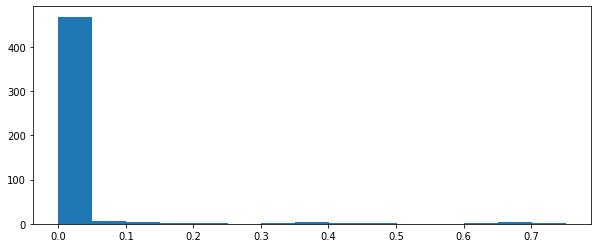

In [11]:
class_idx = 1
#score_list = memory_buffer.meta_score[class_idx, ..., 0]
# Remove the support = 0
score_list = memory_buffer.meta_score[class_idx,...,0][memory_buffer.meta_score[class_idx, ...,1] != 0]

fig, ax =  plt.subplots(figsize=(10,4))
ax.hist(score_list, bins=15)

(array([189.,  56.,  42.,  33.,  18.,  16.,  27.,  33.,  17.,  10.,  13.,
         13.,  16.,   3.,   3.]),
 array([0.00138924, 0.05524644, 0.10910364, 0.16296083, 0.21681803,
        0.27067523, 0.32453243, 0.37838962, 0.43224682, 0.48610402,
        0.53996121, 0.59381841, 0.64767561, 0.70153281, 0.75539   ,
        0.8092472 ]),
 <BarContainer object of 15 artists>)

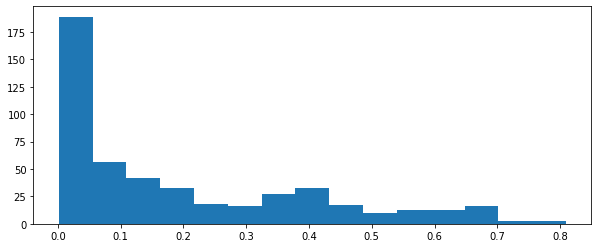

In [12]:
class_idx = 8
#score_list = memory_buffer.meta_score[class_idx, ..., 0]
# Remove the support = 0
score_list = memory_buffer.meta_score[class_idx,...,0][memory_buffer.meta_score[class_idx, ...,1] != 0]

fig, ax =  plt.subplots(figsize=(10,4))
ax.hist(score_list, bins=15)

(array([174.,  61.,  38.,  28.,  31.,  26.,  16.,  10.,  16.,   9.,  10.,
         11.,   0.,   1.,   2.]),
 array([0.00676904, 0.05340992, 0.10005081, 0.1466917 , 0.19333259,
        0.23997348, 0.28661436, 0.33325525, 0.37989614, 0.42653703,
        0.47317791, 0.5198188 , 0.56645969, 0.61310058, 0.65974147,
        0.70638235]),
 <BarContainer object of 15 artists>)

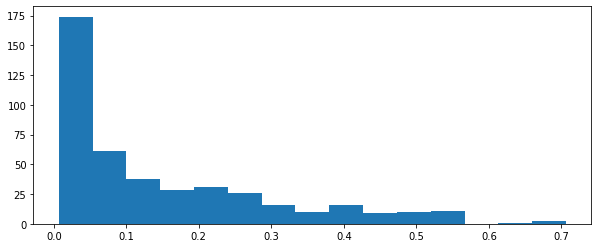

In [13]:
class_idx = 30
#score_list = memory_buffer.meta_score[class_idx, ..., 0]
# Remove the support = 0
score_list = memory_buffer.meta_score[class_idx,...,0][memory_buffer.meta_score[class_idx, ...,1] != 0]

fig, ax =  plt.subplots(figsize=(10,4))
ax.hist(score_list, bins=15)

### Plotting Adapted Conf

(array([  6.,   3.,  11., 140.,   5.,   3.,   9., 128.,   3.,  11.,  68.,
          2.,  24.,  18.,   2.]),
 array([0.11994077, 0.16731495, 0.21468912, 0.2620633 , 0.30943747,
        0.35681165, 0.40418582, 0.45156   , 0.49893417, 0.54630835,
        0.59368252, 0.6410567 , 0.68843087, 0.73580505, 0.78317922,
        0.8305534 ]),
 <BarContainer object of 15 artists>)

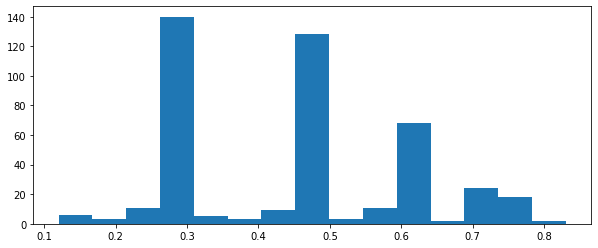

In [14]:
class_idx = 30
# Remove the support = 0
score_list = memory_buffer.meta_score[class_idx,...,2][memory_buffer.meta_score[class_idx, ...,1] != 0]

fig, ax =  plt.subplots(figsize=(10,4))
ax.hist(score_list, bins=15)

### Plotting Distribution of Scores for one sample

#Scores in ScoreList 7
# Score in sample_idx: 0.0006587579733610153
# Support in sample_idx: 7.0


(array([0., 0., 0., 0., 0., 0., 0., 7., 0., 0., 0., 0., 0., 0., 0.]),
 array([-0.49928212, -0.43261545, -0.36594879, -0.29928212, -0.23261545,
        -0.16594879, -0.09928212, -0.03261545,  0.03405121,  0.10071788,
         0.16738455,  0.23405121,  0.30071788,  0.36738455,  0.43405121,
         0.50071788]),
 <BarContainer object of 15 artists>)

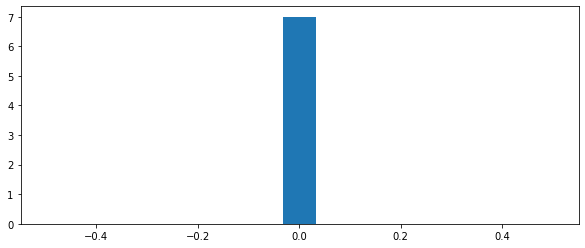

In [15]:
class_idx = 0
sample_idx = 0
score_list = memory_buffer.meta_debug[class_idx][sample_idx]

print(f"#Scores in ScoreList {len(score_list)}")
print(f"# Score in sample_idx: {memory_buffer.meta_score[class_idx, sample_idx, 0]}")
print(f"# Support in sample_idx: {memory_buffer.meta_score[class_idx, sample_idx, 1]}")

fig, ax =  plt.subplots(figsize=(10,4))
ax.hist(score_list, bins=15)

In [16]:
memory_buffer.meta_debug[class_idx].keys()

dict_keys([284, 117, 316, 346, 160, 339, 181, 11, 95, 367, 226, 335, 317, 447, 8, 34, 228, 196, 242, 14, 63, 329, 252, 21, 342, 198, 452, 188, 371, 491, 175, 266, 253, 216, 492, 165, 357, 224, 214, 44, 385, 213, 128, 243, 473, 172, 231, 398, 201, 307, 125, 51, 155, 135, 170, 42, 20, 229, 391, 246, 32, 499, 13, 185, 415, 70, 240, 361, 424, 444, 400, 300, 353, 104, 100, 407, 286, 123, 377, 1, 187, 320, 455, 204, 395, 5, 451, 39, 59, 259, 208, 234, 459, 472, 341, 24, 393, 496, 237, 194, 456, 434, 487, 331, 355, 356, 174, 18, 269, 272, 166, 330, 408, 417, 295, 74, 443, 145, 414, 106, 126, 360, 287, 161, 413, 416, 312, 404, 227, 217, 279, 139, 167, 314, 419, 292, 366, 328, 465, 147, 362, 241, 154, 401, 432, 363, 45, 46, 380, 16, 211, 72, 349, 40, 476, 449, 277, 17, 130, 257, 263, 324, 225, 273, 293, 469, 254, 12, 423, 219, 36, 308, 56, 405, 83, 88, 406, 99, 90, 364, 29, 31, 30, 9, 394, 168, 334, 323, 379, 475, 113, 262, 140, 193, 457, 69, 270, 291, 298, 54, 289, 223, 10, 62, 96, 48, 271, 27

# Testing

Select specific column index per row
https://stackoverflow.com/questions/23435782/numpy-selecting-specific-column-index-per-row-by-using-a-list-of-indexes

In [12]:
def evaluate(dataloader, updates, mini_batch_size, dataname=""):
    learner.rln.eval()
    learner.pln.train()
    
    all_losses, all_predictions, all_labels, all_label_conf = [], [], [], []
    all_adaptation_time = []
    # Get Query set first. and then find supporting support set
    for query_idx, (query_text, query_labels) in enumerate(dataloader):
        print(f"Query ID {query_idx}/{len(dataloader)}")
        # The task id to optimize to for support set
        # task_idx = get_task_from_label_list(query_labels, memory_buffer.task_dict)
        task_idx = dataclass_mapper[dataname]
        
    
        support_set = []
        for _ in range(updates):
            text, labels = memory_buffer.read_batch_task(batch_size=mini_batch_size, task_idx=task_idx, sort_score=True, \
                                                        sort_asc=False ) # this is changed!!!
            support_set.append((text, labels))

        with higher.innerloop_ctx(learner.pln, learner.inner_optimizer,
                                  copy_initial_weights=False, track_higher_grads=False) as (fpln, diffopt):
            
            INNER_tic = time.time()
            # Inner loop
            task_predictions, task_labels = [], []
            support_loss = []
            for text, labels in support_set:
                labels = torch.tensor(labels).to(device)
                input_dict = learner.rln.encode_text(text)
                _repr = learner.rln(input_dict)
                output = fpln(_repr)
                loss = learner.loss_fn(output, labels)
                diffopt.step(loss)
                pred = models.utils.make_prediction(output.detach())
                support_loss.append(loss.item())
                task_predictions.extend(pred.tolist())
                task_labels.extend(labels.tolist())
            INNER_toc = time.time() - INNER_tic
            all_adaptation_time.append(INNER_toc)

            acc, prec, rec, f1 = models.utils.calculate_metrics(task_predictions, task_labels)

            print('Support set metrics: Loss = {:.4f}, accuracy = {:.4f}, precision = {:.4f}, '
                        'recall = {:.4f}, F1 score = {:.4f}'.format(np.mean(support_loss), acc, prec, rec, f1))

            # Query set is now here!
            query_labels = torch.tensor(query_labels).to(device)
            query_input_dict = learner.rln.encode_text(query_text)
            with torch.no_grad():
                query_repr = learner.rln(query_input_dict)
                query_output = fpln(query_repr) # Output has size of torch.Size([16, 33]) [BATCH, CLASSES]
                query_loss = learner.loss_fn(query_output, query_labels)
            query_loss = query_loss.item()
            # print(output.detach().size())
            # output.detach().max(-1) max on each Batch, which will return [0] max, [1] indices
            query_output_softmax = F.softmax(query_output, -1)
            query_label_conf = query_output_softmax[np.arange(len(query_output_softmax)), query_labels] # Select labels in the softmax of 33 classes

            query_pred = models.utils.make_prediction(query_output.detach())
            query_acc, query_prec, query_rec, query_f1 = models.utils.calculate_metrics(query_pred.tolist(), query_labels.tolist())
            
            print('Query set metrics: Loss = {:.4f}, accuracy = {:.4f}, precision = {:.4f}, '
                'recall = {:.4f}, F1 score = {:.4f}'.format(np.mean(query_loss), query_acc, query_prec, query_rec, query_f1))

            all_losses.append(query_loss)
            all_predictions.extend(query_pred.tolist())
            all_labels.extend(query_labels.tolist())
            all_label_conf.extend(query_label_conf.tolist())

    acc, prec, rec, f1 = models.utils.calculate_metrics(all_predictions, all_labels)
    print('Test metrics: Loss = {:.4f}, accuracy = {:.4f}, precision = {:.4f}, recall = {:.4f}, '
                'F1 score = {:.4f}'.format(np.mean(all_losses), acc, prec, rec, f1))
    return acc, prec, rec, f1, all_predictions, all_labels, all_label_conf, all_adaptation_time

In [13]:
tic = time.time()
print('----------Testing on test set starts here----------')

accuracies, precisions, recalls, f1s = [], [], [], []
all_adapt_time = []
# Data for Visualization: [data_idx, label, label_conf, pred]
data_for_visual = []

for test_dataset in test_datasets:
    print('Testing on {}'.format(test_dataset.__class__.__name__))
    test_dataloader = data.DataLoader(test_dataset, batch_size=mini_batch_size, shuffle=False,
                                      collate_fn=datasets.utils.batch_encode)
    acc, prec, rec, f1, all_pred, all_label, all_label_conf, all_adaptation_time = evaluate(dataloader=test_dataloader, updates=updates, 
                                                mini_batch_size=mini_batch_size, dataname=test_dataset.__class__.__name__)
    
    data_ids = [test_dataset.__class__.__name__ + str(i) for i in range(len(all_label))]
    data_for_visual.extend(list(zip(data_ids, all_label, all_label_conf, all_pred)))
    all_adapt_time.extend(all_adaptation_time)
#     print(data_ids)
#     print(all_label)
#     raise Exception("BREAKPOINT")
    
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)


print()
print("COPY PASTA - not really but ok")
for row in accuracies:
    print(row)
print()
print('Overall test metrics: Accuracy = {:.4f}, precision = {:.4f}, recall = {:.4f}, '
            'F1 score = {:.4f}'.format(np.mean(accuracies), np.mean(precisions), np.mean(recalls), np.mean(f1s)))

toc = time.time() - tic
print(f"Total Time used: {toc//60} minutes")

----------Testing on test set starts here----------
Testing on YelpDataset
Query ID 0/475
Support set metrics: Loss = 2.2470, accuracy = 0.0375, precision = 0.0375, recall = 0.0300, F1 score = 0.0333
Query set metrics: Loss = 0.6242, accuracy = 0.8125, precision = 0.9167, recall = 0.8000, F1 score = 0.8132
Query ID 1/475
Support set metrics: Loss = 2.2827, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.9250, accuracy = 0.7500, precision = 0.7267, recall = 0.7933, F1 score = 0.7200
Query ID 2/475
Support set metrics: Loss = 2.1473, accuracy = 0.0125, precision = 0.0111, recall = 0.0100, F1 score = 0.0105
Query set metrics: Loss = 0.8936, accuracy = 0.5000, precision = 0.3300, recall = 0.4500, F1 score = 0.3778
Query ID 3/475
Support set metrics: Loss = 2.3281, accuracy = 0.0125, precision = 0.0143, recall = 0.0133, F1 score = 0.0138
Query set metrics: Loss = 0.8558, accuracy = 0.6250, precision = 0.6033, recall = 0.6000, F1 score = 

Support set metrics: Loss = 2.3433, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.6452, accuracy = 0.7500, precision = 0.7625, recall = 0.7625, F1 score = 0.7625
Query ID 36/475
Support set metrics: Loss = 2.2591, accuracy = 0.0125, precision = 0.0111, recall = 0.0100, F1 score = 0.0105
Query set metrics: Loss = 0.8067, accuracy = 0.7500, precision = 0.5600, recall = 0.7000, F1 score = 0.6111
Query ID 37/475
Support set metrics: Loss = 2.2062, accuracy = 0.0125, precision = 0.0118, recall = 0.0100, F1 score = 0.0108
Query set metrics: Loss = 0.7317, accuracy = 0.6875, precision = 0.6200, recall = 0.5833, F1 score = 0.5452
Query ID 38/475
Support set metrics: Loss = 2.2835, accuracy = 0.0375, precision = 0.0286, recall = 0.0300, F1 score = 0.0293
Query set metrics: Loss = 0.8519, accuracy = 0.6250, precision = 0.5133, recall = 0.6200, F1 score = 0.5578
Query ID 39/475
Support set metrics: Loss = 2.1845, accuracy = 0.0875, precision

Query set metrics: Loss = 1.2194, accuracy = 0.5000, precision = 0.4200, recall = 0.4933, F1 score = 0.4367
Query ID 71/475
Support set metrics: Loss = 2.2439, accuracy = 0.0125, precision = 0.0095, recall = 0.0100, F1 score = 0.0098
Query set metrics: Loss = 0.9479, accuracy = 0.6875, precision = 0.6833, recall = 0.5833, F1 score = 0.6033
Query ID 72/475
Support set metrics: Loss = 2.2197, accuracy = 0.0125, precision = 0.0111, recall = 0.0100, F1 score = 0.0105
Query set metrics: Loss = 0.7757, accuracy = 0.5625, precision = 0.5667, recall = 0.5400, F1 score = 0.5467
Query ID 73/475
Support set metrics: Loss = 2.2448, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.8315, accuracy = 0.7500, precision = 0.6600, recall = 0.6533, F1 score = 0.6425
Query ID 74/475
Support set metrics: Loss = 2.3002, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.8767, accuracy = 0.6875, precision =

Query set metrics: Loss = 0.7731, accuracy = 0.6250, precision = 0.6700, recall = 0.6333, F1 score = 0.6143
Query ID 106/475
Support set metrics: Loss = 2.2830, accuracy = 0.0125, precision = 0.0118, recall = 0.0100, F1 score = 0.0108
Query set metrics: Loss = 1.2324, accuracy = 0.3125, precision = 0.3167, recall = 0.4000, F1 score = 0.3371
Query ID 107/475
Support set metrics: Loss = 2.3023, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.9265, accuracy = 0.6875, precision = 0.6500, recall = 0.6500, F1 score = 0.6433
Query ID 108/475
Support set metrics: Loss = 2.2304, accuracy = 0.0250, precision = 0.0200, recall = 0.0200, F1 score = 0.0200
Query set metrics: Loss = 1.1583, accuracy = 0.3125, precision = 0.1857, recall = 0.3000, F1 score = 0.2200
Query ID 109/475
Support set metrics: Loss = 2.2569, accuracy = 0.0125, precision = 0.0100, recall = 0.0100, F1 score = 0.0100
Query set metrics: Loss = 1.0509, accuracy = 0.5000, precisi

Query set metrics: Loss = 0.6384, accuracy = 0.6875, precision = 0.7700, recall = 0.7200, F1 score = 0.6767
Query ID 141/475
Support set metrics: Loss = 2.1789, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.7178, accuracy = 0.7500, precision = 0.6643, recall = 0.6500, F1 score = 0.6288
Query ID 142/475
Support set metrics: Loss = 2.2548, accuracy = 0.0250, precision = 0.0222, recall = 0.0200, F1 score = 0.0211
Query set metrics: Loss = 0.8550, accuracy = 0.5625, precision = 0.7167, recall = 0.6300, F1 score = 0.6286
Query ID 143/475
Support set metrics: Loss = 2.1976, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.6318, accuracy = 0.6875, precision = 0.6667, recall = 0.6333, F1 score = 0.6361
Query ID 144/475
Support set metrics: Loss = 2.2100, accuracy = 0.0625, precision = 0.0455, recall = 0.0500, F1 score = 0.0476
Query set metrics: Loss = 0.8712, accuracy = 0.6250, precisi

Query set metrics: Loss = 0.8913, accuracy = 0.5625, precision = 0.5800, recall = 0.5467, F1 score = 0.5076
Query ID 176/475
Support set metrics: Loss = 2.3051, accuracy = 0.0125, precision = 0.0105, recall = 0.0100, F1 score = 0.0103
Query set metrics: Loss = 1.0031, accuracy = 0.4375, precision = 0.4800, recall = 0.3833, F1 score = 0.3960
Query ID 177/475
Support set metrics: Loss = 2.2873, accuracy = 0.0250, precision = 0.0222, recall = 0.0200, F1 score = 0.0211
Query set metrics: Loss = 0.7961, accuracy = 0.6250, precision = 0.7917, recall = 0.7333, F1 score = 0.6792
Query ID 178/475
Support set metrics: Loss = 2.0763, accuracy = 0.0750, precision = 0.0667, recall = 0.0600, F1 score = 0.0632
Query set metrics: Loss = 1.1721, accuracy = 0.5625, precision = 0.5200, recall = 0.5767, F1 score = 0.5455
Query ID 179/475
Support set metrics: Loss = 2.1743, accuracy = 0.0250, precision = 0.0200, recall = 0.0200, F1 score = 0.0200
Query set metrics: Loss = 0.7743, accuracy = 0.5625, precisi

Query set metrics: Loss = 1.1164, accuracy = 0.5000, precision = 0.4524, recall = 0.5167, F1 score = 0.4424
Query ID 211/475
Support set metrics: Loss = 2.1685, accuracy = 0.0125, precision = 0.0118, recall = 0.0100, F1 score = 0.0108
Query set metrics: Loss = 0.9709, accuracy = 0.4375, precision = 0.5833, recall = 0.5333, F1 score = 0.4571
Query ID 212/475
Support set metrics: Loss = 2.2621, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.8116, accuracy = 0.6875, precision = 0.7933, recall = 0.6500, F1 score = 0.6787
Query ID 213/475
Support set metrics: Loss = 2.2175, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.7390, accuracy = 0.6250, precision = 0.5000, recall = 0.5000, F1 score = 0.4943
Query ID 214/475
Support set metrics: Loss = 2.2381, accuracy = 0.0250, precision = 0.0235, recall = 0.0200, F1 score = 0.0216
Query set metrics: Loss = 1.0424, accuracy = 0.3750, precisi

Support set metrics: Loss = 2.2396, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.8752, accuracy = 0.6250, precision = 0.5533, recall = 0.6000, F1 score = 0.5524
Query ID 247/475
Support set metrics: Loss = 2.1901, accuracy = 0.0500, precision = 0.0421, recall = 0.0400, F1 score = 0.0410
Query set metrics: Loss = 1.1571, accuracy = 0.5625, precision = 0.5771, recall = 0.6500, F1 score = 0.5556
Query ID 248/475
Support set metrics: Loss = 2.3167, accuracy = 0.0375, precision = 0.0364, recall = 0.0333, F1 score = 0.0348
Query set metrics: Loss = 0.8261, accuracy = 0.6875, precision = 0.7600, recall = 0.7000, F1 score = 0.6978
Query ID 249/475
Support set metrics: Loss = 2.1986, accuracy = 0.0125, precision = 0.0105, recall = 0.0100, F1 score = 0.0103
Query set metrics: Loss = 0.8794, accuracy = 0.6250, precision = 0.6857, recall = 0.7310, F1 score = 0.6679
Query ID 250/475
Support set metrics: Loss = 2.2634, accuracy = 0.0500, preci

Support set metrics: Loss = 2.3254, accuracy = 0.0375, precision = 0.0375, recall = 0.0300, F1 score = 0.0333
Query set metrics: Loss = 0.8780, accuracy = 0.6250, precision = 0.6333, recall = 0.7600, F1 score = 0.6333
Query ID 282/475
Support set metrics: Loss = 2.2483, accuracy = 0.0250, precision = 0.0261, recall = 0.0233, F1 score = 0.0246
Query set metrics: Loss = 1.0301, accuracy = 0.5000, precision = 0.4833, recall = 0.6000, F1 score = 0.4952
Query ID 283/475
Support set metrics: Loss = 2.2874, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.0154, accuracy = 0.6250, precision = 0.7143, recall = 0.6000, F1 score = 0.5931
Query ID 284/475
Support set metrics: Loss = 2.1131, accuracy = 0.0625, precision = 0.0642, recall = 0.0600, F1 score = 0.0616
Query set metrics: Loss = 0.7253, accuracy = 0.6875, precision = 0.7429, recall = 0.7429, F1 score = 0.6905
Query ID 285/475
Support set metrics: Loss = 2.2018, accuracy = 0.0250, preci

Support set metrics: Loss = 2.1762, accuracy = 0.0500, precision = 0.0444, recall = 0.0400, F1 score = 0.0421
Query set metrics: Loss = 0.7101, accuracy = 0.7500, precision = 0.7333, recall = 0.7333, F1 score = 0.7143
Query ID 317/475
Support set metrics: Loss = 2.2990, accuracy = 0.0250, precision = 0.0250, recall = 0.0200, F1 score = 0.0222
Query set metrics: Loss = 0.9477, accuracy = 0.5625, precision = 0.3429, recall = 0.4667, F1 score = 0.3800
Query ID 318/475
Support set metrics: Loss = 2.2764, accuracy = 0.0125, precision = 0.0095, recall = 0.0100, F1 score = 0.0098
Query set metrics: Loss = 0.9690, accuracy = 0.5625, precision = 0.5600, recall = 0.5833, F1 score = 0.4769
Query ID 319/475
Support set metrics: Loss = 2.2814, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.9272, accuracy = 0.5625, precision = 0.4833, recall = 0.5833, F1 score = 0.5167
Query ID 320/475
Support set metrics: Loss = 2.1534, accuracy = 0.0875, preci

Support set metrics: Loss = 2.1248, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.0914, accuracy = 0.6875, precision = 0.7000, recall = 0.6857, F1 score = 0.6533
Query ID 352/475
Support set metrics: Loss = 2.1907, accuracy = 0.0125, precision = 0.0111, recall = 0.0100, F1 score = 0.0105
Query set metrics: Loss = 0.7047, accuracy = 0.7500, precision = 0.7381, recall = 0.7714, F1 score = 0.7124
Query ID 353/475
Support set metrics: Loss = 2.2100, accuracy = 0.0500, precision = 0.0500, recall = 0.0400, F1 score = 0.0444
Query set metrics: Loss = 1.1595, accuracy = 0.3750, precision = 0.3429, recall = 0.2333, F1 score = 0.2538
Query ID 354/475
Support set metrics: Loss = 2.2418, accuracy = 0.0250, precision = 0.0267, recall = 0.0233, F1 score = 0.0248
Query set metrics: Loss = 0.9064, accuracy = 0.6250, precision = 0.6267, recall = 0.6800, F1 score = 0.5863
Query ID 355/475
Support set metrics: Loss = 2.1721, accuracy = 0.0250, preci

Support set metrics: Loss = 2.3029, accuracy = 0.0375, precision = 0.0333, recall = 0.0300, F1 score = 0.0316
Query set metrics: Loss = 1.0388, accuracy = 0.3750, precision = 0.3833, recall = 0.3467, F1 score = 0.3514
Query ID 387/475
Support set metrics: Loss = 2.2674, accuracy = 0.0250, precision = 0.0286, recall = 0.0200, F1 score = 0.0235
Query set metrics: Loss = 1.4388, accuracy = 0.4375, precision = 0.5167, recall = 0.4238, F1 score = 0.4203
Query ID 388/475
Support set metrics: Loss = 2.2155, accuracy = 0.0125, precision = 0.0133, recall = 0.0100, F1 score = 0.0114
Query set metrics: Loss = 0.7200, accuracy = 0.6875, precision = 0.7733, recall = 0.7167, F1 score = 0.6654
Query ID 389/475
Support set metrics: Loss = 2.2031, accuracy = 0.0500, precision = 0.0381, recall = 0.0400, F1 score = 0.0390
Query set metrics: Loss = 0.9494, accuracy = 0.5000, precision = 0.5900, recall = 0.6333, F1 score = 0.4952
Query ID 390/475
Support set metrics: Loss = 2.0617, accuracy = 0.0750, preci

Support set metrics: Loss = 2.1687, accuracy = 0.0375, precision = 0.0336, recall = 0.0333, F1 score = 0.0334
Query set metrics: Loss = 1.0803, accuracy = 0.3750, precision = 0.2771, recall = 0.3786, F1 score = 0.2667
Query ID 422/475
Support set metrics: Loss = 2.1258, accuracy = 0.0125, precision = 0.0154, recall = 0.0100, F1 score = 0.0121
Query set metrics: Loss = 1.1589, accuracy = 0.6875, precision = 0.7600, recall = 0.7600, F1 score = 0.7467
Query ID 423/475
Support set metrics: Loss = 2.1517, accuracy = 0.0500, precision = 0.0500, recall = 0.0433, F1 score = 0.0464
Query set metrics: Loss = 0.9112, accuracy = 0.6250, precision = 0.5833, recall = 0.6833, F1 score = 0.6114
Query ID 424/475
Support set metrics: Loss = 2.3054, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.9658, accuracy = 0.6250, precision = 0.6583, recall = 0.6750, F1 score = 0.6540
Query ID 425/475
Support set metrics: Loss = 2.2116, accuracy = 0.0000, preci

Support set metrics: Loss = 2.2295, accuracy = 0.0375, precision = 0.0300, recall = 0.0300, F1 score = 0.0300
Query set metrics: Loss = 1.2154, accuracy = 0.5625, precision = 0.6500, recall = 0.5533, F1 score = 0.5867
Query ID 457/475
Support set metrics: Loss = 2.2396, accuracy = 0.0375, precision = 0.0344, recall = 0.0333, F1 score = 0.0338
Query set metrics: Loss = 0.5525, accuracy = 0.8125, precision = 0.8533, recall = 0.8333, F1 score = 0.8381
Query ID 458/475
Support set metrics: Loss = 2.2769, accuracy = 0.0625, precision = 0.0526, recall = 0.0500, F1 score = 0.0513
Query set metrics: Loss = 1.1703, accuracy = 0.6250, precision = 0.3614, recall = 0.4914, F1 score = 0.3714
Query ID 459/475
Support set metrics: Loss = 2.1500, accuracy = 0.0250, precision = 0.0190, recall = 0.0200, F1 score = 0.0195
Query set metrics: Loss = 0.6377, accuracy = 0.8125, precision = 0.8200, recall = 0.8500, F1 score = 0.7633
Query ID 460/475
Support set metrics: Loss = 2.2567, accuracy = 0.0250, preci

Support set metrics: Loss = 1.7576, accuracy = 0.2250, precision = 0.2669, recall = 0.2250, F1 score = 0.2426
Query set metrics: Loss = 0.2926, accuracy = 0.8750, precision = 0.8750, recall = 0.9286, F1 score = 0.8750
Query ID 17/475
Support set metrics: Loss = 1.8043, accuracy = 0.1875, precision = 0.2525, recall = 0.1875, F1 score = 0.2141
Query set metrics: Loss = 0.2810, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Query ID 18/475
Support set metrics: Loss = 1.9587, accuracy = 0.2000, precision = 0.2329, recall = 0.2000, F1 score = 0.2145
Query set metrics: Loss = 0.3974, accuracy = 0.8125, precision = 0.8661, recall = 0.8583, F1 score = 0.8590
Query ID 19/475
Support set metrics: Loss = 1.8961, accuracy = 0.2500, precision = 0.2396, recall = 0.2500, F1 score = 0.2443
Query set metrics: Loss = 0.5414, accuracy = 0.8125, precision = 0.8333, recall = 0.8021, F1 score = 0.7333
Query ID 20/475
Support set metrics: Loss = 2.0106, accuracy = 0.1750, precision

Support set metrics: Loss = 2.0847, accuracy = 0.1625, precision = 0.1865, recall = 0.1625, F1 score = 0.1733
Query set metrics: Loss = 0.2162, accuracy = 0.9375, precision = 0.9375, recall = 0.9500, F1 score = 0.9365
Query ID 53/475
Support set metrics: Loss = 1.9962, accuracy = 0.2000, precision = 0.2477, recall = 0.2000, F1 score = 0.2204
Query set metrics: Loss = 0.1462, accuracy = 0.9375, precision = 0.9583, recall = 0.9167, F1 score = 0.9273
Query ID 54/475
Support set metrics: Loss = 2.0156, accuracy = 0.1625, precision = 0.1864, recall = 0.1625, F1 score = 0.1723
Query set metrics: Loss = 0.3503, accuracy = 0.8750, precision = 0.6250, recall = 0.6667, F1 score = 0.6439
Query ID 55/475
Support set metrics: Loss = 1.8518, accuracy = 0.2500, precision = 0.2371, recall = 0.2500, F1 score = 0.2417
Query set metrics: Loss = 0.0984, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 56/475
Support set metrics: Loss = 1.8179, accuracy = 0.2625, precision

Support set metrics: Loss = 1.9451, accuracy = 0.1000, precision = 0.1417, recall = 0.1000, F1 score = 0.1172
Query set metrics: Loss = 0.3338, accuracy = 0.8750, precision = 0.8250, recall = 0.8667, F1 score = 0.8167
Query ID 89/475
Support set metrics: Loss = 1.9545, accuracy = 0.1750, precision = 0.2022, recall = 0.1750, F1 score = 0.1873
Query set metrics: Loss = 0.1409, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 90/475
Support set metrics: Loss = 1.9846, accuracy = 0.1250, precision = 0.1250, recall = 0.1250, F1 score = 0.1250
Query set metrics: Loss = 0.2207, accuracy = 0.8750, precision = 0.8875, recall = 0.8750, F1 score = 0.8532
Query ID 91/475
Support set metrics: Loss = 1.8481, accuracy = 0.1625, precision = 0.1912, recall = 0.1625, F1 score = 0.1757
Query set metrics: Loss = 0.1868, accuracy = 0.9375, precision = 0.9583, recall = 0.9167, F1 score = 0.9273
Query ID 92/475
Support set metrics: Loss = 2.0279, accuracy = 0.1250, precision

Support set metrics: Loss = 1.8049, accuracy = 0.2000, precision = 0.2451, recall = 0.2000, F1 score = 0.2195
Query set metrics: Loss = 0.1646, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 124/475
Support set metrics: Loss = 2.1415, accuracy = 0.1375, precision = 0.1890, recall = 0.1375, F1 score = 0.1584
Query set metrics: Loss = 0.3361, accuracy = 0.8125, precision = 0.8661, recall = 0.7917, F1 score = 0.7816
Query ID 125/475
Support set metrics: Loss = 1.8111, accuracy = 0.2750, precision = 0.2605, recall = 0.2750, F1 score = 0.2670
Query set metrics: Loss = 0.4752, accuracy = 0.9375, precision = 0.9688, recall = 0.9375, F1 score = 0.9476
Query ID 126/475
Support set metrics: Loss = 1.8202, accuracy = 0.2250, precision = 0.2696, recall = 0.2250, F1 score = 0.2448
Query set metrics: Loss = 0.2554, accuracy = 0.8750, precision = 0.8667, recall = 0.8667, F1 score = 0.8667
Query ID 127/475
Support set metrics: Loss = 1.9002, accuracy = 0.1500, preci

Support set metrics: Loss = 2.0940, accuracy = 0.1000, precision = 0.1384, recall = 0.1000, F1 score = 0.1160
Query set metrics: Loss = 0.1997, accuracy = 0.8750, precision = 0.8750, recall = 0.8750, F1 score = 0.8750
Query ID 159/475
Support set metrics: Loss = 1.7954, accuracy = 0.1625, precision = 0.1667, recall = 0.1625, F1 score = 0.1643
Query set metrics: Loss = 0.1164, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 160/475
Support set metrics: Loss = 1.7297, accuracy = 0.2125, precision = 0.2017, recall = 0.2125, F1 score = 0.2063
Query set metrics: Loss = 0.3276, accuracy = 0.8750, precision = 0.8333, recall = 0.9167, F1 score = 0.8250
Query ID 161/475
Support set metrics: Loss = 1.9877, accuracy = 0.1750, precision = 0.1854, recall = 0.1750, F1 score = 0.1799
Query set metrics: Loss = 0.2589, accuracy = 0.8750, precision = 0.8750, recall = 0.8810, F1 score = 0.8747
Query ID 162/475
Support set metrics: Loss = 1.7599, accuracy = 0.2250, preci

Support set metrics: Loss = 1.8145, accuracy = 0.2625, precision = 0.2793, recall = 0.2625, F1 score = 0.2679
Query set metrics: Loss = 0.2488, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 194/475
Support set metrics: Loss = 1.9861, accuracy = 0.1625, precision = 0.2235, recall = 0.1625, F1 score = 0.1845
Query set metrics: Loss = 0.1489, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 195/475
Support set metrics: Loss = 1.9397, accuracy = 0.2250, precision = 0.2467, recall = 0.2250, F1 score = 0.2353
Query set metrics: Loss = 0.3281, accuracy = 0.9375, precision = 0.9167, recall = 0.9500, F1 score = 0.9222
Query ID 196/475
Support set metrics: Loss = 1.6787, accuracy = 0.2000, precision = 0.2274, recall = 0.2000, F1 score = 0.2127
Query set metrics: Loss = 0.1977, accuracy = 0.9375, precision = 0.9500, recall = 0.9167, F1 score = 0.9222
Query ID 197/475
Support set metrics: Loss = 1.9873, accuracy = 0.2125, preci

Support set metrics: Loss = 1.9999, accuracy = 0.1625, precision = 0.1812, recall = 0.1625, F1 score = 0.1712
Query set metrics: Loss = 0.1321, accuracy = 0.9375, precision = 0.8750, recall = 0.9375, F1 score = 0.8810
Query ID 229/475
Support set metrics: Loss = 1.9887, accuracy = 0.2500, precision = 0.2530, recall = 0.2500, F1 score = 0.2514
Query set metrics: Loss = 0.0769, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 230/475
Support set metrics: Loss = 1.8891, accuracy = 0.1875, precision = 0.1945, recall = 0.1875, F1 score = 0.1894
Query set metrics: Loss = 0.2316, accuracy = 0.9375, precision = 0.9500, recall = 0.9500, F1 score = 0.9444
Query ID 231/475
Support set metrics: Loss = 1.8874, accuracy = 0.1750, precision = 0.2464, recall = 0.1750, F1 score = 0.2046
Query set metrics: Loss = 0.4363, accuracy = 0.8750, precision = 0.8875, recall = 0.8393, F1 score = 0.8339
Query ID 232/475
Support set metrics: Loss = 2.0822, accuracy = 0.2000, preci

Support set metrics: Loss = 2.0651, accuracy = 0.0875, precision = 0.1287, recall = 0.0875, F1 score = 0.1029
Query set metrics: Loss = 0.2138, accuracy = 0.9375, precision = 0.9583, recall = 0.9167, F1 score = 0.9273
Query ID 264/475
Support set metrics: Loss = 1.9979, accuracy = 0.2000, precision = 0.2068, recall = 0.2000, F1 score = 0.2033
Query set metrics: Loss = 0.2679, accuracy = 0.8750, precision = 0.8542, recall = 0.9286, F1 score = 0.8726
Query ID 265/475
Support set metrics: Loss = 1.8932, accuracy = 0.1750, precision = 0.2345, recall = 0.1750, F1 score = 0.2004
Query set metrics: Loss = 0.2417, accuracy = 0.9375, precision = 0.9375, recall = 0.9500, F1 score = 0.9365
Query ID 266/475
Support set metrics: Loss = 1.8279, accuracy = 0.2000, precision = 0.1418, recall = 0.2000, F1 score = 0.1656
Query set metrics: Loss = 0.4515, accuracy = 0.8750, precision = 0.9000, recall = 0.9000, F1 score = 0.8944
Query ID 267/475
Support set metrics: Loss = 1.8800, accuracy = 0.1625, preci

Support set metrics: Loss = 1.9584, accuracy = 0.1875, precision = 0.1881, recall = 0.1875, F1 score = 0.1871
Query set metrics: Loss = 0.2242, accuracy = 0.8750, precision = 0.6518, recall = 0.7143, F1 score = 0.6786
Query ID 299/475
Support set metrics: Loss = 1.8299, accuracy = 0.1125, precision = 0.1324, recall = 0.1125, F1 score = 0.1216
Query set metrics: Loss = 0.2495, accuracy = 0.9375, precision = 0.9500, recall = 0.9583, F1 score = 0.9495
Query ID 300/475
Support set metrics: Loss = 1.7906, accuracy = 0.2000, precision = 0.2306, recall = 0.2000, F1 score = 0.2140
Query set metrics: Loss = 0.3989, accuracy = 0.8750, precision = 0.9018, recall = 0.8810, F1 score = 0.8786
Query ID 301/475
Support set metrics: Loss = 2.0466, accuracy = 0.1750, precision = 0.2028, recall = 0.1750, F1 score = 0.1876
Query set metrics: Loss = 0.1762, accuracy = 0.9375, precision = 0.9167, recall = 0.9500, F1 score = 0.9222
Query ID 302/475
Support set metrics: Loss = 2.0018, accuracy = 0.2500, preci

Support set metrics: Loss = 1.7985, accuracy = 0.2250, precision = 0.2372, recall = 0.2250, F1 score = 0.2305
Query set metrics: Loss = 0.2051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 334/475
Support set metrics: Loss = 1.8259, accuracy = 0.2250, precision = 0.2569, recall = 0.2250, F1 score = 0.2396
Query set metrics: Loss = 0.3302, accuracy = 0.9375, precision = 0.9500, recall = 0.9500, F1 score = 0.9444
Query ID 335/475
Support set metrics: Loss = 2.0867, accuracy = 0.1500, precision = 0.1746, recall = 0.1500, F1 score = 0.1610
Query set metrics: Loss = 0.5845, accuracy = 0.9375, precision = 0.8750, recall = 0.9643, F1 score = 0.8974
Query ID 336/475
Support set metrics: Loss = 2.1763, accuracy = 0.1000, precision = 0.1697, recall = 0.1000, F1 score = 0.1253
Query set metrics: Loss = 0.4890, accuracy = 0.8125, precision = 0.7500, recall = 0.8125, F1 score = 0.7643
Query ID 337/475
Support set metrics: Loss = 2.0915, accuracy = 0.1125, preci

Support set metrics: Loss = 1.7953, accuracy = 0.2375, precision = 0.2836, recall = 0.2375, F1 score = 0.2569
Query set metrics: Loss = 0.4294, accuracy = 0.8750, precision = 0.9286, recall = 0.8393, F1 score = 0.8558
Query ID 369/475
Support set metrics: Loss = 1.9477, accuracy = 0.2000, precision = 0.2443, recall = 0.2000, F1 score = 0.2191
Query set metrics: Loss = 0.3718, accuracy = 0.9375, precision = 0.9167, recall = 0.9583, F1 score = 0.9273
Query ID 370/475
Support set metrics: Loss = 2.0139, accuracy = 0.2375, precision = 0.2583, recall = 0.2375, F1 score = 0.2445
Query set metrics: Loss = 0.1522, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 371/475
Support set metrics: Loss = 1.9318, accuracy = 0.2375, precision = 0.2330, recall = 0.2375, F1 score = 0.2339
Query set metrics: Loss = 0.5372, accuracy = 0.7500, precision = 0.7810, recall = 0.6935, F1 score = 0.7143
Query ID 372/475
Support set metrics: Loss = 1.9470, accuracy = 0.2000, preci

Support set metrics: Loss = 1.6773, accuracy = 0.2000, precision = 0.2251, recall = 0.2000, F1 score = 0.2095
Query set metrics: Loss = 0.5572, accuracy = 0.7500, precision = 0.8750, recall = 0.7875, F1 score = 0.7929
Query ID 404/475
Support set metrics: Loss = 1.7093, accuracy = 0.2375, precision = 0.2255, recall = 0.2375, F1 score = 0.2292
Query set metrics: Loss = 0.5215, accuracy = 0.8750, precision = 0.9375, recall = 0.9000, F1 score = 0.9018
Query ID 405/475
Support set metrics: Loss = 2.0947, accuracy = 0.1875, precision = 0.1769, recall = 0.1875, F1 score = 0.1821
Query set metrics: Loss = 0.1060, accuracy = 0.9375, precision = 1.0000, recall = 0.8333, F1 score = 0.8889
Query ID 406/475
Support set metrics: Loss = 1.9919, accuracy = 0.1875, precision = 0.2388, recall = 0.1875, F1 score = 0.2100
Query set metrics: Loss = 1.1086, accuracy = 0.6875, precision = 0.7292, recall = 0.7500, F1 score = 0.6821
Query ID 407/475
Support set metrics: Loss = 1.8545, accuracy = 0.1750, preci

Support set metrics: Loss = 1.8581, accuracy = 0.2375, precision = 0.2624, recall = 0.2375, F1 score = 0.2485
Query set metrics: Loss = 0.2621, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 439/475
Support set metrics: Loss = 1.8100, accuracy = 0.1375, precision = 0.1196, recall = 0.1375, F1 score = 0.1279
Query set metrics: Loss = 0.3569, accuracy = 0.8750, precision = 0.8250, recall = 0.8250, F1 score = 0.8250
Query ID 440/475
Support set metrics: Loss = 1.9372, accuracy = 0.1875, precision = 0.2055, recall = 0.1875, F1 score = 0.1955
Query set metrics: Loss = 0.1541, accuracy = 0.9375, precision = 0.9167, recall = 0.9500, F1 score = 0.9222
Query ID 441/475
Support set metrics: Loss = 1.9494, accuracy = 0.1875, precision = 0.2630, recall = 0.1875, F1 score = 0.2135
Query set metrics: Loss = 0.2474, accuracy = 0.9375, precision = 0.9375, recall = 0.9500, F1 score = 0.9365
Query ID 442/475
Support set metrics: Loss = 2.1524, accuracy = 0.1625, preci

Support set metrics: Loss = 1.7535, accuracy = 0.2125, precision = 0.2637, recall = 0.2125, F1 score = 0.2337
Query set metrics: Loss = 0.1381, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 474/475
Support set metrics: Loss = 1.6228, accuracy = 0.3000, precision = 0.3077, recall = 0.3000, F1 score = 0.3016
Query set metrics: Loss = 0.0835, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Test metrics: Loss = 0.3184, accuracy = 0.9030, precision = 0.9075, recall = 0.9030, F1 score = 0.9040
Testing on DBPediaDataset
Query ID 0/475
Support set metrics: Loss = 0.1623, accuracy = 0.9625, precision = 0.9690, recall = 0.9643, F1 score = 0.9640
Query set metrics: Loss = 0.0054, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 1/475
Support set metrics: Loss = 0.1825, accuracy = 0.9250, precision = 0.9393, recall = 0.9286, F1 score = 0.9199
Query set metrics: Loss = 0.0056, accuracy = 1.0000, precisi

Support set metrics: Loss = 0.1172, accuracy = 0.9500, precision = 0.9667, recall = 0.9500, F1 score = 0.9562
Query set metrics: Loss = 0.0124, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 34/475
Support set metrics: Loss = 0.2046, accuracy = 0.9125, precision = 0.9296, recall = 0.9214, F1 score = 0.9179
Query set metrics: Loss = 0.0044, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 35/475
Support set metrics: Loss = 0.1059, accuracy = 0.9750, precision = 0.9762, recall = 0.9714, F1 score = 0.9711
Query set metrics: Loss = 0.0155, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 36/475
Support set metrics: Loss = 0.0487, accuracy = 0.9875, precision = 1.0000, recall = 0.9929, F1 score = 0.9962
Query set metrics: Loss = 0.4277, accuracy = 0.9375, precision = 0.9500, recall = 0.9500, F1 score = 0.9333
Query ID 37/475
Support set metrics: Loss = 0.1171, accuracy = 0.9500, precision

Support set metrics: Loss = 0.1125, accuracy = 0.9750, precision = 0.9714, recall = 0.9714, F1 score = 0.9714
Query set metrics: Loss = 0.0052, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 70/475
Support set metrics: Loss = 0.1836, accuracy = 0.9500, precision = 0.9558, recall = 0.9500, F1 score = 0.9456
Query set metrics: Loss = 0.4671, accuracy = 0.9375, precision = 0.8889, recall = 0.8889, F1 score = 0.8889
Query ID 71/475
Support set metrics: Loss = 0.0719, accuracy = 0.9750, precision = 0.9762, recall = 0.9786, F1 score = 0.9753
Query set metrics: Loss = 0.0490, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 72/475
Support set metrics: Loss = 0.1042, accuracy = 0.9750, precision = 0.9816, recall = 0.9714, F1 score = 0.9742
Query set metrics: Loss = 0.0050, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 73/475
Support set metrics: Loss = 0.0769, accuracy = 0.9750, precision

Support set metrics: Loss = 0.2078, accuracy = 0.9500, precision = 0.9632, recall = 0.9429, F1 score = 0.9417
Query set metrics: Loss = 0.0066, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 105/475
Support set metrics: Loss = 0.2031, accuracy = 0.9375, precision = 0.9478, recall = 0.9429, F1 score = 0.9400
Query set metrics: Loss = 0.0065, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 106/475
Support set metrics: Loss = 0.0853, accuracy = 0.9625, precision = 0.9738, recall = 0.9643, F1 score = 0.9675
Query set metrics: Loss = 0.2026, accuracy = 0.9375, precision = 0.9500, recall = 0.9800, F1 score = 0.9556
Query ID 107/475
Support set metrics: Loss = 0.1029, accuracy = 0.9375, precision = 0.9677, recall = 0.9500, F1 score = 0.9511
Query set metrics: Loss = 0.0552, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 108/475
Support set metrics: Loss = 0.1522, accuracy = 0.9500, preci

Support set metrics: Loss = 0.2422, accuracy = 0.9250, precision = 0.9493, recall = 0.9214, F1 score = 0.9243
Query set metrics: Loss = 0.0110, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 140/475
Support set metrics: Loss = 0.1439, accuracy = 0.9625, precision = 0.9697, recall = 0.9571, F1 score = 0.9598
Query set metrics: Loss = 0.1026, accuracy = 0.9375, precision = 0.9545, recall = 0.9697, F1 score = 0.9515
Query ID 141/475
Support set metrics: Loss = 0.2010, accuracy = 0.9500, precision = 0.9578, recall = 0.9500, F1 score = 0.9495
Query set metrics: Loss = 0.0110, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 142/475
Support set metrics: Loss = 0.1045, accuracy = 0.9750, precision = 0.9881, recall = 0.9786, F1 score = 0.9818
Query set metrics: Loss = 0.0061, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 143/475
Support set metrics: Loss = 0.1700, accuracy = 0.9500, preci

Support set metrics: Loss = 0.0492, accuracy = 0.9750, precision = 0.9762, recall = 0.9714, F1 score = 0.9711
Query set metrics: Loss = 0.0045, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 175/475
Support set metrics: Loss = 0.0652, accuracy = 0.9500, precision = 0.9677, recall = 0.9500, F1 score = 0.9520
Query set metrics: Loss = 0.0047, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 176/475
Support set metrics: Loss = 0.3078, accuracy = 0.9000, precision = 0.9314, recall = 0.9143, F1 score = 0.9156
Query set metrics: Loss = 0.0352, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 177/475
Support set metrics: Loss = 0.1365, accuracy = 0.9625, precision = 0.9677, recall = 0.9571, F1 score = 0.9558
Query set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 178/475
Support set metrics: Loss = 0.0957, accuracy = 0.9500, preci

Support set metrics: Loss = 0.1968, accuracy = 0.9500, precision = 0.9745, recall = 0.9500, F1 score = 0.9572
Query set metrics: Loss = 0.0048, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 210/475
Support set metrics: Loss = 0.0929, accuracy = 0.9625, precision = 0.9802, recall = 0.9714, F1 score = 0.9743
Query set metrics: Loss = 0.0041, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 211/475
Support set metrics: Loss = 0.0914, accuracy = 0.9625, precision = 0.9643, recall = 0.9643, F1 score = 0.9609
Query set metrics: Loss = 0.1560, accuracy = 0.9375, precision = 0.8636, recall = 0.9091, F1 score = 0.8788
Query ID 212/475
Support set metrics: Loss = 0.2345, accuracy = 0.9375, precision = 0.9459, recall = 0.9357, F1 score = 0.9365
Query set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 213/475
Support set metrics: Loss = 0.1469, accuracy = 0.9375, preci

Support set metrics: Loss = 0.1348, accuracy = 0.9375, precision = 0.9478, recall = 0.9429, F1 score = 0.9380
Query set metrics: Loss = 0.3245, accuracy = 0.9375, precision = 0.9545, recall = 0.9773, F1 score = 0.9567
Query ID 245/475
Support set metrics: Loss = 0.1395, accuracy = 0.9375, precision = 0.9431, recall = 0.9429, F1 score = 0.9403
Query set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 246/475
Support set metrics: Loss = 0.1040, accuracy = 0.9625, precision = 0.9762, recall = 0.9643, F1 score = 0.9674
Query set metrics: Loss = 0.0046, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 247/475
Support set metrics: Loss = 0.0725, accuracy = 0.9625, precision = 0.9810, recall = 0.9643, F1 score = 0.9705
Query set metrics: Loss = 0.0077, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 248/475
Support set metrics: Loss = 0.2302, accuracy = 0.9375, preci

Support set metrics: Loss = 0.1110, accuracy = 0.9500, precision = 0.9683, recall = 0.9571, F1 score = 0.9599
Query set metrics: Loss = 0.0053, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 280/475
Support set metrics: Loss = 0.1140, accuracy = 0.9500, precision = 0.9631, recall = 0.9500, F1 score = 0.9546
Query set metrics: Loss = 0.0126, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 281/475
Support set metrics: Loss = 0.0546, accuracy = 0.9750, precision = 0.9881, recall = 0.9786, F1 score = 0.9818
Query set metrics: Loss = 0.0064, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 282/475
Support set metrics: Loss = 0.0946, accuracy = 0.9750, precision = 0.9810, recall = 0.9786, F1 score = 0.9784
Query set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 283/475
Support set metrics: Loss = 0.0809, accuracy = 0.9750, preci

Support set metrics: Loss = 0.0998, accuracy = 0.9875, precision = 0.9881, recall = 0.9857, F1 score = 0.9856
Query set metrics: Loss = 0.0059, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 315/475
Support set metrics: Loss = 0.1835, accuracy = 0.9750, precision = 0.9816, recall = 0.9714, F1 score = 0.9742
Query set metrics: Loss = 0.0066, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 316/475
Support set metrics: Loss = 0.1255, accuracy = 0.9375, precision = 0.9595, recall = 0.9429, F1 score = 0.9491
Query set metrics: Loss = 0.0047, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 317/475
Support set metrics: Loss = 0.1546, accuracy = 0.9500, precision = 0.9578, recall = 0.9429, F1 score = 0.9454
Query set metrics: Loss = 0.0057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 318/475
Support set metrics: Loss = 0.0266, accuracy = 1.0000, preci

Support set metrics: Loss = 0.2074, accuracy = 0.9625, precision = 0.9702, recall = 0.9571, F1 score = 0.9618
Query set metrics: Loss = 0.1271, accuracy = 0.9375, precision = 0.9545, recall = 0.9697, F1 score = 0.9515
Query ID 350/475
Support set metrics: Loss = 0.1530, accuracy = 0.9500, precision = 0.9751, recall = 0.9500, F1 score = 0.9575
Query set metrics: Loss = 0.0054, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 351/475
Support set metrics: Loss = 0.0630, accuracy = 0.9750, precision = 0.9929, recall = 0.9786, F1 score = 0.9849
Query set metrics: Loss = 0.0124, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 352/475
Support set metrics: Loss = 0.0700, accuracy = 0.9500, precision = 0.9802, recall = 0.9571, F1 score = 0.9664
Query set metrics: Loss = 0.0052, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 353/475
Support set metrics: Loss = 0.2117, accuracy = 0.9500, preci

Support set metrics: Loss = 0.1698, accuracy = 0.9625, precision = 0.9677, recall = 0.9571, F1 score = 0.9558
Query set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 385/475
Support set metrics: Loss = 0.0939, accuracy = 0.9875, precision = 0.9881, recall = 0.9857, F1 score = 0.9856
Query set metrics: Loss = 0.0124, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 386/475
Support set metrics: Loss = 0.1679, accuracy = 0.9500, precision = 0.9530, recall = 0.9429, F1 score = 0.9457
Query set metrics: Loss = 0.0052, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 387/475
Support set metrics: Loss = 0.2102, accuracy = 0.9250, precision = 0.9394, recall = 0.9214, F1 score = 0.9222
Query set metrics: Loss = 0.0040, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 388/475
Support set metrics: Loss = 0.1205, accuracy = 0.9750, preci

Support set metrics: Loss = 0.0838, accuracy = 0.9625, precision = 0.9786, recall = 0.9643, F1 score = 0.9706
Query set metrics: Loss = 0.0050, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 420/475
Support set metrics: Loss = 0.1926, accuracy = 0.9500, precision = 0.9558, recall = 0.9429, F1 score = 0.9414
Query set metrics: Loss = 0.0048, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 421/475
Support set metrics: Loss = 0.2544, accuracy = 0.9250, precision = 0.9326, recall = 0.9214, F1 score = 0.9201
Query set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 422/475
Support set metrics: Loss = 0.0651, accuracy = 0.9750, precision = 0.9816, recall = 0.9714, F1 score = 0.9742
Query set metrics: Loss = 0.3521, accuracy = 0.9375, precision = 1.0000, recall = 0.9750, F1 score = 0.9857
Query ID 423/475
Support set metrics: Loss = 0.0298, accuracy = 0.9875, preci

Support set metrics: Loss = 0.1754, accuracy = 0.9500, precision = 0.9558, recall = 0.9429, F1 score = 0.9414
Query set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 455/475
Support set metrics: Loss = 0.0980, accuracy = 0.9875, precision = 0.9881, recall = 0.9857, F1 score = 0.9856
Query set metrics: Loss = 0.0058, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 456/475
Support set metrics: Loss = 0.0504, accuracy = 0.9750, precision = 0.9816, recall = 0.9714, F1 score = 0.9722
Query set metrics: Loss = 0.1393, accuracy = 0.9375, precision = 0.9500, recall = 0.9750, F1 score = 0.9524
Query ID 457/475
Support set metrics: Loss = 0.0300, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0305, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 458/475
Support set metrics: Loss = 0.2055, accuracy = 0.9250, preci

Support set metrics: Loss = 2.3561, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.9153, accuracy = 0.7500, precision = 0.6500, recall = 0.6714, F1 score = 0.6227
Query ID 15/475
Support set metrics: Loss = 2.2144, accuracy = 0.0250, precision = 0.0267, recall = 0.0200, F1 score = 0.0229
Query set metrics: Loss = 1.2765, accuracy = 0.5000, precision = 0.4933, recall = 0.5800, F1 score = 0.4571
Query ID 16/475
Support set metrics: Loss = 2.2665, accuracy = 0.0125, precision = 0.0118, recall = 0.0100, F1 score = 0.0108
Query set metrics: Loss = 0.6995, accuracy = 0.6875, precision = 0.8444, recall = 0.6833, F1 score = 0.6762
Query ID 17/475
Support set metrics: Loss = 2.2352, accuracy = 0.0375, precision = 0.0353, recall = 0.0300, F1 score = 0.0324
Query set metrics: Loss = 0.9005, accuracy = 0.6875, precision = 0.7222, recall = 0.5667, F1 score = 0.5883
Query ID 18/475
Support set metrics: Loss = 2.2975, accuracy = 0.0250, precision

Support set metrics: Loss = 2.3786, accuracy = 0.0125, precision = 0.0154, recall = 0.0100, F1 score = 0.0121
Query set metrics: Loss = 0.8437, accuracy = 0.7500, precision = 0.5548, recall = 0.7000, F1 score = 0.6160
Query ID 51/475
Support set metrics: Loss = 2.3976, accuracy = 0.0125, precision = 0.0125, recall = 0.0100, F1 score = 0.0111
Query set metrics: Loss = 0.9208, accuracy = 0.6250, precision = 0.5333, recall = 0.5667, F1 score = 0.5410
Query ID 52/475
Support set metrics: Loss = 2.2663, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.8127, accuracy = 0.5625, precision = 0.5690, recall = 0.6000, F1 score = 0.5248
Query ID 53/475
Support set metrics: Loss = 2.3352, accuracy = 0.0125, precision = 0.0118, recall = 0.0100, F1 score = 0.0108
Query set metrics: Loss = 0.8525, accuracy = 0.6250, precision = 0.4095, recall = 0.4667, F1 score = 0.4333
Query ID 54/475
Support set metrics: Loss = 2.2884, accuracy = 0.0000, precision

Support set metrics: Loss = 2.3849, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.0030, accuracy = 0.4375, precision = 0.5167, recall = 0.4500, F1 score = 0.4238
Query ID 87/475
Support set metrics: Loss = 2.3415, accuracy = 0.0250, precision = 0.0222, recall = 0.0200, F1 score = 0.0211
Query set metrics: Loss = 0.9886, accuracy = 0.5625, precision = 0.5533, recall = 0.4700, F1 score = 0.4600
Query ID 88/475
Support set metrics: Loss = 2.1829, accuracy = 0.0250, precision = 0.0286, recall = 0.0200, F1 score = 0.0235
Query set metrics: Loss = 1.3337, accuracy = 0.5000, precision = 0.3758, recall = 0.4381, F1 score = 0.3333
Query ID 89/475
Support set metrics: Loss = 2.2451, accuracy = 0.0125, precision = 0.0125, recall = 0.0100, F1 score = 0.0111
Query set metrics: Loss = 0.9971, accuracy = 0.5625, precision = 0.5100, recall = 0.5000, F1 score = 0.4825
Query ID 90/475
Support set metrics: Loss = 2.2592, accuracy = 0.0250, precision

Support set metrics: Loss = 2.2070, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.0996, accuracy = 0.3125, precision = 0.3733, recall = 0.4400, F1 score = 0.3056
Query ID 122/475
Support set metrics: Loss = 2.2728, accuracy = 0.0125, precision = 0.0087, recall = 0.0100, F1 score = 0.0093
Query set metrics: Loss = 0.8818, accuracy = 0.5625, precision = 0.6429, recall = 0.5238, F1 score = 0.5318
Query ID 123/475
Support set metrics: Loss = 2.2639, accuracy = 0.0125, precision = 0.0133, recall = 0.0100, F1 score = 0.0114
Query set metrics: Loss = 1.1051, accuracy = 0.5000, precision = 0.4810, recall = 0.4600, F1 score = 0.4600
Query ID 124/475
Support set metrics: Loss = 2.1627, accuracy = 0.0500, precision = 0.0471, recall = 0.0400, F1 score = 0.0432
Query set metrics: Loss = 1.4826, accuracy = 0.4375, precision = 0.4857, recall = 0.5333, F1 score = 0.4900
Query ID 125/475
Support set metrics: Loss = 2.2865, accuracy = 0.0000, preci

Support set metrics: Loss = 2.3000, accuracy = 0.0250, precision = 0.0310, recall = 0.0233, F1 score = 0.0263
Query set metrics: Loss = 1.1627, accuracy = 0.4375, precision = 0.5905, recall = 0.5467, F1 score = 0.4889
Query ID 157/475
Support set metrics: Loss = 2.3196, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.1790, accuracy = 0.5000, precision = 0.4667, recall = 0.4533, F1 score = 0.4452
Query ID 158/475
Support set metrics: Loss = 2.2386, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.1538, accuracy = 0.5000, precision = 0.4233, recall = 0.5000, F1 score = 0.4443
Query ID 159/475
Support set metrics: Loss = 2.2680, accuracy = 0.0250, precision = 0.0235, recall = 0.0200, F1 score = 0.0216
Query set metrics: Loss = 0.8419, accuracy = 0.6250, precision = 0.5933, recall = 0.6733, F1 score = 0.5933
Query ID 160/475
Support set metrics: Loss = 2.1931, accuracy = 0.0250, preci

Support set metrics: Loss = 2.2908, accuracy = 0.0125, precision = 0.0111, recall = 0.0100, F1 score = 0.0105
Query set metrics: Loss = 1.3990, accuracy = 0.3750, precision = 0.3917, recall = 0.5000, F1 score = 0.3262
Query ID 192/475
Support set metrics: Loss = 2.3049, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.2745, accuracy = 0.3125, precision = 0.4750, recall = 0.3083, F1 score = 0.3472
Query ID 193/475
Support set metrics: Loss = 2.3048, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.8271, accuracy = 0.6250, precision = 0.6250, recall = 0.5750, F1 score = 0.5972
Query ID 194/475
Support set metrics: Loss = 2.2558, accuracy = 0.0250, precision = 0.0286, recall = 0.0200, F1 score = 0.0235
Query set metrics: Loss = 1.2529, accuracy = 0.3750, precision = 0.4000, recall = 0.3900, F1 score = 0.2967
Query ID 195/475
Support set metrics: Loss = 2.2683, accuracy = 0.0125, preci

Support set metrics: Loss = 2.2008, accuracy = 0.0125, precision = 0.0143, recall = 0.0100, F1 score = 0.0118
Query set metrics: Loss = 1.1165, accuracy = 0.6250, precision = 0.7143, recall = 0.5625, F1 score = 0.5808
Query ID 227/475
Support set metrics: Loss = 2.2023, accuracy = 0.0125, precision = 0.0143, recall = 0.0100, F1 score = 0.0118
Query set metrics: Loss = 1.2087, accuracy = 0.5625, precision = 0.5500, recall = 0.5667, F1 score = 0.4867
Query ID 228/475
Support set metrics: Loss = 2.2205, accuracy = 0.0125, precision = 0.0167, recall = 0.0100, F1 score = 0.0125
Query set metrics: Loss = 0.8395, accuracy = 0.6250, precision = 0.6333, recall = 0.6200, F1 score = 0.6190
Query ID 229/475
Support set metrics: Loss = 2.2738, accuracy = 0.0250, precision = 0.0276, recall = 0.0233, F1 score = 0.0251
Query set metrics: Loss = 1.2742, accuracy = 0.4375, precision = 0.5467, recall = 0.3800, F1 score = 0.4222
Query ID 230/475
Support set metrics: Loss = 2.1585, accuracy = 0.0625, preci

Support set metrics: Loss = 2.3425, accuracy = 0.0125, precision = 0.0118, recall = 0.0100, F1 score = 0.0108
Query set metrics: Loss = 0.7220, accuracy = 0.6875, precision = 0.6667, recall = 0.6300, F1 score = 0.6009
Query ID 262/475
Support set metrics: Loss = 2.3778, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.8693, accuracy = 0.6875, precision = 0.6929, recall = 0.6867, F1 score = 0.6467
Query ID 263/475
Support set metrics: Loss = 2.2673, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.6159, accuracy = 0.4375, precision = 0.5700, recall = 0.4524, F1 score = 0.4133
Query ID 264/475
Support set metrics: Loss = 2.2766, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.3111, accuracy = 0.5000, precision = 0.4833, recall = 0.4300, F1 score = 0.4076
Query ID 265/475
Support set metrics: Loss = 2.2215, accuracy = 0.0000, preci

Support set metrics: Loss = 2.3441, accuracy = 0.0125, precision = 0.0133, recall = 0.0100, F1 score = 0.0114
Query set metrics: Loss = 0.9818, accuracy = 0.5625, precision = 0.5400, recall = 0.5000, F1 score = 0.4843
Query ID 297/475
Support set metrics: Loss = 2.2392, accuracy = 0.0125, precision = 0.0133, recall = 0.0100, F1 score = 0.0114
Query set metrics: Loss = 1.0458, accuracy = 0.5000, precision = 0.4306, recall = 0.4333, F1 score = 0.4036
Query ID 298/475
Support set metrics: Loss = 2.2068, accuracy = 0.0250, precision = 0.0250, recall = 0.0200, F1 score = 0.0222
Query set metrics: Loss = 1.2963, accuracy = 0.4375, precision = 0.5556, recall = 0.6000, F1 score = 0.4667
Query ID 299/475
Support set metrics: Loss = 2.3104, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.8372, accuracy = 0.6250, precision = 0.6633, recall = 0.6867, F1 score = 0.6622
Query ID 300/475
Support set metrics: Loss = 2.2615, accuracy = 0.0125, preci

Support set metrics: Loss = 2.2623, accuracy = 0.0125, precision = 0.0143, recall = 0.0100, F1 score = 0.0118
Query set metrics: Loss = 0.9770, accuracy = 0.6250, precision = 0.5067, recall = 0.5083, F1 score = 0.4356
Query ID 332/475
Support set metrics: Loss = 2.1960, accuracy = 0.0125, precision = 0.0182, recall = 0.0100, F1 score = 0.0129
Query set metrics: Loss = 1.2337, accuracy = 0.4375, precision = 0.4167, recall = 0.4500, F1 score = 0.4070
Query ID 333/475
Support set metrics: Loss = 2.3517, accuracy = 0.0125, precision = 0.0118, recall = 0.0133, F1 score = 0.0125
Query set metrics: Loss = 0.9418, accuracy = 0.5000, precision = 0.4267, recall = 0.6000, F1 score = 0.4508
Query ID 334/475
Support set metrics: Loss = 2.1902, accuracy = 0.0250, precision = 0.0265, recall = 0.0233, F1 score = 0.0242
Query set metrics: Loss = 1.0728, accuracy = 0.6250, precision = 0.8171, recall = 0.6500, F1 score = 0.6133
Query ID 335/475
Support set metrics: Loss = 2.1783, accuracy = 0.0500, preci

Support set metrics: Loss = 2.1789, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.0971, accuracy = 0.5625, precision = 0.5833, recall = 0.4833, F1 score = 0.4900
Query ID 367/475
Support set metrics: Loss = 2.2261, accuracy = 0.0625, precision = 0.0629, recall = 0.0567, F1 score = 0.0596
Query set metrics: Loss = 1.1855, accuracy = 0.4375, precision = 0.6389, recall = 0.6354, F1 score = 0.5931
Query ID 368/475
Support set metrics: Loss = 2.1536, accuracy = 0.0250, precision = 0.0235, recall = 0.0200, F1 score = 0.0216
Query set metrics: Loss = 0.9818, accuracy = 0.5625, precision = 0.5250, recall = 0.6000, F1 score = 0.5139
Query ID 369/475
Support set metrics: Loss = 2.2446, accuracy = 0.0500, precision = 0.0615, recall = 0.0400, F1 score = 0.0485
Query set metrics: Loss = 0.6392, accuracy = 0.6875, precision = 0.7708, recall = 0.6143, F1 score = 0.6641
Query ID 370/475
Support set metrics: Loss = 2.2169, accuracy = 0.0375, preci

Support set metrics: Loss = 2.1768, accuracy = 0.0250, precision = 0.0235, recall = 0.0200, F1 score = 0.0216
Query set metrics: Loss = 1.0254, accuracy = 0.4375, precision = 0.2812, recall = 0.3500, F1 score = 0.3034
Query ID 402/475
Support set metrics: Loss = 2.3241, accuracy = 0.0125, precision = 0.0118, recall = 0.0100, F1 score = 0.0108
Query set metrics: Loss = 1.0222, accuracy = 0.6250, precision = 0.5333, recall = 0.5367, F1 score = 0.5310
Query ID 403/475
Support set metrics: Loss = 2.3789, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 1.0460, accuracy = 0.5625, precision = 0.6200, recall = 0.5800, F1 score = 0.5443
Query ID 404/475
Support set metrics: Loss = 2.2896, accuracy = 0.0375, precision = 0.0333, recall = 0.0300, F1 score = 0.0316
Query set metrics: Loss = 0.7731, accuracy = 0.6250, precision = 0.6600, recall = 0.6143, F1 score = 0.6000
Query ID 405/475
Support set metrics: Loss = 2.3374, accuracy = 0.0000, preci

Support set metrics: Loss = 2.2963, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.9777, accuracy = 0.7500, precision = 0.8667, recall = 0.7667, F1 score = 0.7867
Query ID 437/475
Support set metrics: Loss = 2.3528, accuracy = 0.0125, precision = 0.0118, recall = 0.0100, F1 score = 0.0108
Query set metrics: Loss = 1.0369, accuracy = 0.5625, precision = 0.6900, recall = 0.5367, F1 score = 0.5533
Query ID 438/475
Support set metrics: Loss = 2.2875, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.9505, accuracy = 0.5625, precision = 0.6750, recall = 0.6333, F1 score = 0.6024
Query ID 439/475
Support set metrics: Loss = 2.2928, accuracy = 0.0250, precision = 0.0333, recall = 0.0200, F1 score = 0.0250
Query set metrics: Loss = 1.0347, accuracy = 0.5625, precision = 0.4000, recall = 0.5400, F1 score = 0.4086
Query ID 440/475
Support set metrics: Loss = 2.2599, accuracy = 0.0125, preci

Support set metrics: Loss = 2.2126, accuracy = 0.0125, precision = 0.0133, recall = 0.0100, F1 score = 0.0114
Query set metrics: Loss = 0.8409, accuracy = 0.5625, precision = 0.5167, recall = 0.5500, F1 score = 0.4648
Query ID 472/475
Support set metrics: Loss = 2.3401, accuracy = 0.0000, precision = 0.0000, recall = 0.0000, F1 score = 0.0000
Query set metrics: Loss = 0.8984, accuracy = 0.5625, precision = 0.5667, recall = 0.5133, F1 score = 0.5156
Query ID 473/475
Support set metrics: Loss = 2.2769, accuracy = 0.0125, precision = 0.0143, recall = 0.0100, F1 score = 0.0118
Query set metrics: Loss = 0.8086, accuracy = 0.6250, precision = 0.4200, recall = 0.5500, F1 score = 0.4548
Query ID 474/475
Support set metrics: Loss = 2.2674, accuracy = 0.0125, precision = 0.0125, recall = 0.0100, F1 score = 0.0111
Query set metrics: Loss = 1.0457, accuracy = 0.5000, precision = 0.5500, recall = 0.4500, F1 score = 0.4300
Test metrics: Loss = 1.0753, accuracy = 0.5501, precision = 0.5667, recall = 

Query set metrics: Loss = 0.8537, accuracy = 0.7500, precision = 0.8750, recall = 0.7708, F1 score = 0.8000
Query ID 31/475
Support set metrics: Loss = 2.1199, accuracy = 0.1875, precision = 0.1556, recall = 0.1500, F1 score = 0.1514
Query set metrics: Loss = 1.1080, accuracy = 0.6875, precision = 0.7500, recall = 0.6875, F1 score = 0.6875
Query ID 32/475
Support set metrics: Loss = 2.4514, accuracy = 0.1625, precision = 0.1087, recall = 0.1300, F1 score = 0.1134
Query set metrics: Loss = 0.9305, accuracy = 0.6250, precision = 0.6111, recall = 0.6852, F1 score = 0.6111
Query ID 33/475
Support set metrics: Loss = 2.4871, accuracy = 0.1625, precision = 0.1705, recall = 0.1300, F1 score = 0.1429
Query set metrics: Loss = 1.5391, accuracy = 0.6250, precision = 0.7083, recall = 0.6250, F1 score = 0.6000
Query ID 34/475
Support set metrics: Loss = 2.3245, accuracy = 0.1875, precision = 0.1962, recall = 0.1600, F1 score = 0.1646
Query set metrics: Loss = 1.1187, accuracy = 0.6875, precision =

Support set metrics: Loss = 2.1725, accuracy = 0.2250, precision = 0.1967, recall = 0.2000, F1 score = 0.1925
Query set metrics: Loss = 0.7094, accuracy = 0.8125, precision = 0.8214, recall = 0.8286, F1 score = 0.8209
Query ID 67/475
Support set metrics: Loss = 2.3784, accuracy = 0.1500, precision = 0.1288, recall = 0.1200, F1 score = 0.1232
Query set metrics: Loss = 1.0030, accuracy = 0.5625, precision = 0.4542, recall = 0.4542, F1 score = 0.4500
Query ID 68/475
Support set metrics: Loss = 2.2486, accuracy = 0.2125, precision = 0.1761, recall = 0.1700, F1 score = 0.1667
Query set metrics: Loss = 0.7405, accuracy = 0.6875, precision = 0.7778, recall = 0.7222, F1 score = 0.7407
Query ID 69/475
Support set metrics: Loss = 2.3190, accuracy = 0.2125, precision = 0.1549, recall = 0.1700, F1 score = 0.1571
Query set metrics: Loss = 0.9591, accuracy = 0.6250, precision = 0.5556, recall = 0.5556, F1 score = 0.5370
Query ID 70/475
Support set metrics: Loss = 2.3173, accuracy = 0.2125, precision

Support set metrics: Loss = 2.2386, accuracy = 0.1750, precision = 0.1571, recall = 0.1500, F1 score = 0.1481
Query set metrics: Loss = 0.9776, accuracy = 0.8125, precision = 0.9583, recall = 0.8646, F1 score = 0.8905
Query ID 103/475
Support set metrics: Loss = 2.4026, accuracy = 0.1625, precision = 0.1264, recall = 0.1300, F1 score = 0.1274
Query set metrics: Loss = 0.8847, accuracy = 0.6875, precision = 0.4881, recall = 0.5714, F1 score = 0.5224
Query ID 104/475
Support set metrics: Loss = 2.2046, accuracy = 0.1750, precision = 0.1229, recall = 0.1400, F1 score = 0.1258
Query set metrics: Loss = 0.9395, accuracy = 0.6875, precision = 0.7976, recall = 0.7381, F1 score = 0.6939
Query ID 105/475
Support set metrics: Loss = 2.3335, accuracy = 0.1750, precision = 0.1804, recall = 0.1500, F1 score = 0.1503
Query set metrics: Loss = 0.5770, accuracy = 0.8750, precision = 0.6852, recall = 0.7778, F1 score = 0.7185
Query ID 106/475
Support set metrics: Loss = 2.2411, accuracy = 0.2000, preci

Support set metrics: Loss = 2.4998, accuracy = 0.1875, precision = 0.1562, recall = 0.1600, F1 score = 0.1526
Query set metrics: Loss = 0.5530, accuracy = 0.7500, precision = 0.7500, recall = 0.6458, F1 score = 0.6833
Query ID 138/475
Support set metrics: Loss = 2.4240, accuracy = 0.1500, precision = 0.1221, recall = 0.1200, F1 score = 0.1185
Query set metrics: Loss = 1.4574, accuracy = 0.6250, precision = 0.5375, recall = 0.6042, F1 score = 0.5361
Query ID 139/475
Support set metrics: Loss = 2.1736, accuracy = 0.2000, precision = 0.1867, recall = 0.1600, F1 score = 0.1698
Query set metrics: Loss = 0.5442, accuracy = 0.8125, precision = 0.7778, recall = 0.8333, F1 score = 0.7741
Query ID 140/475
Support set metrics: Loss = 2.4549, accuracy = 0.1875, precision = 0.1234, recall = 0.1500, F1 score = 0.1342
Query set metrics: Loss = 0.5463, accuracy = 0.8125, precision = 0.6917, recall = 0.7500, F1 score = 0.7157
Query ID 141/475
Support set metrics: Loss = 2.4513, accuracy = 0.1000, preci

Support set metrics: Loss = 2.3641, accuracy = 0.1625, precision = 0.1800, recall = 0.1300, F1 score = 0.1413
Query set metrics: Loss = 0.8551, accuracy = 0.7500, precision = 0.7208, recall = 0.7292, F1 score = 0.7063
Query ID 173/475
Support set metrics: Loss = 2.3600, accuracy = 0.1375, precision = 0.1242, recall = 0.1100, F1 score = 0.1165
Query set metrics: Loss = 0.9745, accuracy = 0.6875, precision = 0.7037, recall = 0.6852, F1 score = 0.6630
Query ID 174/475
Support set metrics: Loss = 2.2625, accuracy = 0.1875, precision = 0.1279, recall = 0.1600, F1 score = 0.1411
Query set metrics: Loss = 0.5648, accuracy = 0.8125, precision = 0.8571, recall = 0.8690, F1 score = 0.8272
Query ID 175/475
Support set metrics: Loss = 2.4358, accuracy = 0.1500, precision = 0.1297, recall = 0.1200, F1 score = 0.1231
Query set metrics: Loss = 0.8847, accuracy = 0.7500, precision = 0.8125, recall = 0.7500, F1 score = 0.7458
Query ID 176/475
Support set metrics: Loss = 2.3976, accuracy = 0.1625, preci

Support set metrics: Loss = 2.2189, accuracy = 0.1875, precision = 0.1760, recall = 0.1600, F1 score = 0.1606
Query set metrics: Loss = 0.9980, accuracy = 0.6875, precision = 0.6222, recall = 0.6667, F1 score = 0.6019
Query ID 208/475
Support set metrics: Loss = 2.3443, accuracy = 0.1625, precision = 0.1181, recall = 0.1300, F1 score = 0.1181
Query set metrics: Loss = 0.9762, accuracy = 0.6875, precision = 0.5833, recall = 0.7000, F1 score = 0.6167
Query ID 209/475
Support set metrics: Loss = 2.4925, accuracy = 0.1750, precision = 0.1200, recall = 0.1400, F1 score = 0.1280
Query set metrics: Loss = 0.9706, accuracy = 0.6875, precision = 0.7708, recall = 0.7083, F1 score = 0.7000
Query ID 210/475
Support set metrics: Loss = 2.2783, accuracy = 0.2125, precision = 0.2438, recall = 0.1800, F1 score = 0.1840
Query set metrics: Loss = 0.7781, accuracy = 0.7500, precision = 0.9583, recall = 0.7500, F1 score = 0.8206
Query ID 211/475
Support set metrics: Loss = 2.2937, accuracy = 0.2000, preci

Support set metrics: Loss = 2.2872, accuracy = 0.1625, precision = 0.1571, recall = 0.1300, F1 score = 0.1322
Query set metrics: Loss = 1.2148, accuracy = 0.6875, precision = 0.5741, recall = 0.6667, F1 score = 0.5667
Query ID 243/475
Support set metrics: Loss = 2.3668, accuracy = 0.2250, precision = 0.1978, recall = 0.2000, F1 score = 0.1930
Query set metrics: Loss = 1.3429, accuracy = 0.5625, precision = 0.6042, recall = 0.5521, F1 score = 0.5667
Query ID 244/475
Support set metrics: Loss = 2.3864, accuracy = 0.2125, precision = 0.1978, recall = 0.1900, F1 score = 0.1821
Query set metrics: Loss = 0.3597, accuracy = 0.9375, precision = 0.8333, recall = 0.8889, F1 score = 0.8519
Query ID 245/475
Support set metrics: Loss = 2.4035, accuracy = 0.1625, precision = 0.1451, recall = 0.1300, F1 score = 0.1333
Query set metrics: Loss = 1.1170, accuracy = 0.6875, precision = 0.7315, recall = 0.7037, F1 score = 0.6767
Query ID 246/475
Support set metrics: Loss = 2.4634, accuracy = 0.1375, preci

Support set metrics: Loss = 2.2871, accuracy = 0.2000, precision = 0.1236, recall = 0.1600, F1 score = 0.1387
Query set metrics: Loss = 0.9580, accuracy = 0.7500, precision = 0.5536, recall = 0.5714, F1 score = 0.5619
Query ID 278/475
Support set metrics: Loss = 2.3461, accuracy = 0.1750, precision = 0.1750, recall = 0.1600, F1 score = 0.1636
Query set metrics: Loss = 1.6452, accuracy = 0.5625, precision = 0.5833, recall = 0.6458, F1 score = 0.6042
Query ID 279/475
Support set metrics: Loss = 2.2185, accuracy = 0.2250, precision = 0.1992, recall = 0.1900, F1 score = 0.1890
Query set metrics: Loss = 1.5360, accuracy = 0.6250, precision = 0.5357, recall = 0.5357, F1 score = 0.5119
Query ID 280/475
Support set metrics: Loss = 2.5501, accuracy = 0.1625, precision = 0.1686, recall = 0.1300, F1 score = 0.1382
Query set metrics: Loss = 0.6404, accuracy = 0.8125, precision = 0.7500, recall = 0.8250, F1 score = 0.7604
Query ID 281/475
Support set metrics: Loss = 2.2678, accuracy = 0.1875, preci

Support set metrics: Loss = 2.2952, accuracy = 0.1875, precision = 0.1804, recall = 0.1600, F1 score = 0.1625
Query set metrics: Loss = 0.7009, accuracy = 0.8125, precision = 0.7083, recall = 0.8125, F1 score = 0.7250
Query ID 313/475
Support set metrics: Loss = 2.3118, accuracy = 0.2125, precision = 0.1575, recall = 0.1700, F1 score = 0.1546
Query set metrics: Loss = 0.7432, accuracy = 0.7500, precision = 0.8750, recall = 0.8833, F1 score = 0.8423
Query ID 314/475
Support set metrics: Loss = 2.4811, accuracy = 0.1250, precision = 0.1400, recall = 0.1000, F1 score = 0.1098
Query set metrics: Loss = 0.4757, accuracy = 0.8125, precision = 0.8095, recall = 0.7738, F1 score = 0.7891
Query ID 315/475
Support set metrics: Loss = 2.4591, accuracy = 0.1625, precision = 0.0956, recall = 0.1300, F1 score = 0.1060
Query set metrics: Loss = 1.0918, accuracy = 0.6875, precision = 0.7143, recall = 0.6190, F1 score = 0.6143
Query ID 316/475
Support set metrics: Loss = 2.2307, accuracy = 0.2500, preci

Support set metrics: Loss = 2.2777, accuracy = 0.2250, precision = 0.1740, recall = 0.1800, F1 score = 0.1696
Query set metrics: Loss = 0.8702, accuracy = 0.6875, precision = 0.5208, recall = 0.5625, F1 score = 0.5375
Query ID 348/475
Support set metrics: Loss = 2.2805, accuracy = 0.1500, precision = 0.1181, recall = 0.1200, F1 score = 0.1148
Query set metrics: Loss = 0.8797, accuracy = 0.7500, precision = 0.6481, recall = 0.7222, F1 score = 0.6481
Query ID 349/475
Support set metrics: Loss = 2.1593, accuracy = 0.2625, precision = 0.1819, recall = 0.2100, F1 score = 0.1890
Query set metrics: Loss = 0.8513, accuracy = 0.7500, precision = 0.7500, recall = 0.7500, F1 score = 0.7034
Query ID 350/475
Support set metrics: Loss = 2.4093, accuracy = 0.2125, precision = 0.2136, recall = 0.1700, F1 score = 0.1615
Query set metrics: Loss = 0.7874, accuracy = 0.6250, precision = 0.6667, recall = 0.6458, F1 score = 0.6389
Query ID 351/475
Support set metrics: Loss = 2.4217, accuracy = 0.2000, preci

Support set metrics: Loss = 2.3715, accuracy = 0.1875, precision = 0.1326, recall = 0.1500, F1 score = 0.1381
Query set metrics: Loss = 0.8889, accuracy = 0.8125, precision = 0.7619, recall = 0.7143, F1 score = 0.6905
Query ID 383/475
Support set metrics: Loss = 2.5208, accuracy = 0.1500, precision = 0.0925, recall = 0.1200, F1 score = 0.1035
Query set metrics: Loss = 0.9465, accuracy = 0.6875, precision = 0.7571, recall = 0.6619, F1 score = 0.6619
Query ID 384/475
Support set metrics: Loss = 2.4587, accuracy = 0.1375, precision = 0.1488, recall = 0.1200, F1 score = 0.1306
Query set metrics: Loss = 1.4190, accuracy = 0.5625, precision = 0.4917, recall = 0.6167, F1 score = 0.5167
Query ID 385/475
Support set metrics: Loss = 2.3791, accuracy = 0.1625, precision = 0.1560, recall = 0.1300, F1 score = 0.1416
Query set metrics: Loss = 1.4547, accuracy = 0.5625, precision = 0.6458, recall = 0.5938, F1 score = 0.5863
Query ID 386/475
Support set metrics: Loss = 2.1364, accuracy = 0.2250, preci

Support set metrics: Loss = 2.4917, accuracy = 0.1500, precision = 0.1028, recall = 0.1200, F1 score = 0.1095
Query set metrics: Loss = 0.7091, accuracy = 0.6875, precision = 0.6833, recall = 0.7000, F1 score = 0.6705
Query ID 418/475
Support set metrics: Loss = 2.3232, accuracy = 0.1625, precision = 0.1497, recall = 0.1300, F1 score = 0.1287
Query set metrics: Loss = 1.0085, accuracy = 0.7500, precision = 0.7292, recall = 0.8125, F1 score = 0.7583
Query ID 419/475
Support set metrics: Loss = 2.3639, accuracy = 0.2000, precision = 0.1717, recall = 0.1600, F1 score = 0.1609
Query set metrics: Loss = 1.0040, accuracy = 0.6250, precision = 0.7361, recall = 0.7083, F1 score = 0.6651
Query ID 420/475
Support set metrics: Loss = 2.4730, accuracy = 0.1625, precision = 0.1679, recall = 0.1400, F1 score = 0.1472
Query set metrics: Loss = 0.9651, accuracy = 0.6875, precision = 0.4630, recall = 0.6111, F1 score = 0.5148
Query ID 421/475
Support set metrics: Loss = 2.3724, accuracy = 0.1875, preci

Support set metrics: Loss = 2.3110, accuracy = 0.1875, precision = 0.1469, recall = 0.1500, F1 score = 0.1447
Query set metrics: Loss = 0.5398, accuracy = 0.8750, precision = 0.9286, recall = 0.9048, F1 score = 0.8952
Query ID 453/475
Support set metrics: Loss = 2.2544, accuracy = 0.1750, precision = 0.1200, recall = 0.1400, F1 score = 0.1283
Query set metrics: Loss = 0.7002, accuracy = 0.6875, precision = 0.7292, recall = 0.7083, F1 score = 0.6917
Query ID 454/475
Support set metrics: Loss = 2.4193, accuracy = 0.1625, precision = 0.1367, recall = 0.1300, F1 score = 0.1271
Query set metrics: Loss = 0.7463, accuracy = 0.7500, precision = 0.6000, recall = 0.7000, F1 score = 0.6333
Query ID 455/475
Support set metrics: Loss = 2.1730, accuracy = 0.2250, precision = 0.1853, recall = 0.1800, F1 score = 0.1796
Query set metrics: Loss = 0.6015, accuracy = 0.8750, precision = 0.8611, recall = 0.8519, F1 score = 0.8508
Query ID 456/475
Support set metrics: Loss = 2.2767, accuracy = 0.2250, preci

In [14]:
_model_path0 = os.path.splitext(model_path)[0]
csv_filename = _model_path0 + "_update"+ str(updates) +"_results_sr_ta_ss8.csv" # for selective replay
with open(csv_filename, 'w') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["data_idx", "label", "label_conf", "pred"])
    csv_writer.writerows(data_for_visual)
print(f"Done writing CSV File at {csv_filename}")

Done writing CSV File at /data/model_runs/original_oml/aOML-order1-inlr010-2022-08-30-sr-query/OML-order1-id4-2022-08-30_05-21-18.854228_update5_results_sr_ta_ss8.csv


In [15]:
# Log Time for Inference
_model_path0 = os.path.splitext(model_path)[0]
time_txt_filename = _model_path0 + "_update"+ str(updates) +"_time_inference_sr_ta_ss8.csv" 
with open(time_txt_filename, 'w') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["time_id", "time"])
    csv_writer.writerow(["Total Time", f"{toc//60} minutes"])
    csv_writer.writerow(["mean Adapt Time", f"{np.mean(all_adapt_time)} s"])
print(f"Done writing Time CSV File at {time_txt_filename}")

Done writing Time CSV File at /data/model_runs/original_oml/aOML-order1-inlr010-2022-08-30-sr-query/OML-order1-id4-2022-08-30_05-21-18.854228_update5_time_inference_sr_ta_ss8.csv
